In [2]:
#%matplotlib notebook
#%matplotlib auto

from scipy import stats
import galpy.potential
from galpy.orbit import Orbit
from astropy import units as u
from galpy.potential import LogarithmicHaloPotential
import numpy as np
from galpy.potential import MWPotential2014,PowerSphericalPotential
#from galpy.potential import FerrersPotential,DehnenBarPotential
import matplotlib.pyplot as plt
#import gala.integrate as gi
#import gala.dynamics as gd
#import gala.potential as gp
#from gala.units import galactic
import astropy.units as u
from orbit_functions import *
import pickle
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
from galpy.potential import plotRotcurve
from functools import partial
import emd

from scipy.fft import *
from scipy import interpolate, optimize, signal
from astropy.io import fits
from astropy.table import Table


# read pickle of orbits

In [3]:
class Loader():
    o_cache = None
    o_cache_name = None
    oo = None
    new = False

    def load_model(self, model, time, xmin=1000, xmax=3000, phi_range=0.2, maxvr=20):
        
        if model == 'MW_Sgr':
            Rmax=16.
            snap=str(int(np.round(time*100))) if time>=1 else '0'+str(int(time*100))
            df = Table.read('MW_Sgr/disk'+snap+'.fits', format='fits').to_pandas()
            df['X'],df['Y'],df['Z'],df['VX'],df['VY'],df['VZ']=cyl2cart(df['R'],df['phi'],df['Z'],df['VR'],df['Vphi'],df['VZ'])
            ind=df['R']<Rmax
            df=df[ind]    
            x,y,z,VR,Vphi,VZ,R,phi=df['X'],df['Y'],df['Z'],df['VR'],df['Vphi'],df['VZ'],df['R'],df['phi']
            Vphi=Vphi*-1.
            Lz=R*Vphi
        else:
            if self.o_cache_name == model:
                o = self.o_cache
            else:
                file='o_galpy/o_'+model+'.pkl'
                with open(file, 'rb') as f:#for orbits after perturbation
                    o = pickle.load(f)
                self.o_cache = o
                self.o_cache_name = model

            t=time*u.Gyr
            x=o.x(t)
            y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
            VR=o.vr(t)
            Vphi=o.vphi(t)*o.r(t)
            R=o.r(t)
            Lz=R*Vphi
            phi=o.phi(t)

        indphi=(np.abs(phi)>np.pi-phi_range)&(np.abs(phi)<np.pi+phi_range)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        indphi=(np.abs(VR)<maxvr)&(Lz>xmin)&(Lz<xmax)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        DATA = False
        
        return x,y,VR,Vphi,R,Lz,phi

    def load_data(self, xmin=1500, xmax=3500, phi_range=0.4, new=False):
        if self.oo == None or self.new != new:
            path = 'o_galpy/SoS_SH_Gaia_test_GAL6D.fits'
            if new:
                path = 'o_galpy/DR3_SH_ruwe14_fidelity05_pioe5_GAL6D.fits'
            self.oo = Table.read(path, format='fits')
        oo = self.oo
        self.new = new

        VR,Vphi,VZ,x,y,Z,R,phi=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi']))
        Lz=-oo['Vphi']*oo['R']
        phi=-np.deg2rad(phi)
        Vphi=-Vphi
        
        indphi = abs(phi) < phi_range
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        indphi=(Lz>xmin)&(Lz<xmax)
        x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
        
        DATA = True
        return x,y,VR,Vphi,R,Lz,phi

def smooth_bins(x, y, xmin, xmax, binsize):
    binsLZ=np.arange(xmin,xmax,binsize)
    m,xedge,binnumber=stats.binned_statistic(x, y, statistic='mean', bins=[binsLZ]) 
    nx = np.arange(xmin-binsize/2, xmax, binsize)
    xpol = nx + binsize/2
    means = []
    for k in nx:
        rel = y[(k<x) & (x<k+binsize)]
        if len(rel) == 0:
            if len(means) == 0:
                means.append(0)
            else:
                means.append(means[-1])
        else:
            means.append(np.mean(rel))
    ypol = np.array(means)
    return xpol, ypol

l = Loader()
CURMODEL = 'Dhot_log'
#CURMODEL = 'Dhot_log_2perturb'
#CURMODEL = 'Dhotn10_pn10'
#CURMODEL = 'Dhotn_10_pn_10'


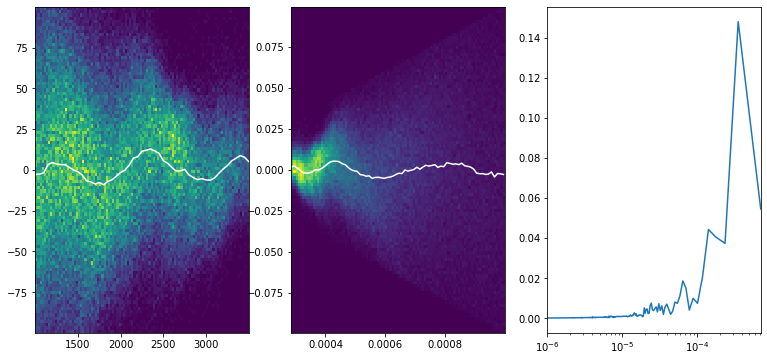

In [719]:

BIAS = -840*0

TIME = 2.0
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = False

#XMIN=1000
#XMAX=3000
#BINSIZE = 50
#x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = True

TIME = 3.0
XMIN=1000
XMAX=3500
BINSIZE = 50
x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2, maxvr=100)
DATA = False

fig, ax = plt.subplots(1,3,figsize=(13,6))

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
#f = interpolate.interp1d(nx, ny, kind='linear')
#xpol = np.linspace(nx[0], nx[-1], N)
#ypol = f(xpol)
if DATA:
    ax[0].hist2d(Lz[abs(VR)<40], VR[abs(VR)<40], bins=100);
else:
    ax[0].hist2d(Lz, VR, bins=100);
ax[0].plot(nx, ny, c='white')
ax[0].set_aspect('auto')

nx, ny = smooth_bins(1/Lz, VR/Lz, 1/XMAX, 1/XMIN, 1e-5)
N = 100000
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)

#ypol = 5*np.sin(0.02*xpol)
#ax[0].hist2d(np.log10(Lz)**P, VR/Lz, bins=100);
#ax[0].plot(xpol, ypol, c='white')
#ax[0].set_aspect('auto')
#plt.scatter(roots, np.zeros(len(roots)), s=10, color='red', zorder=2)
if DATA:
    nvr = VR/Lz
    ax[1].hist2d(1/Lz[abs(nvr)<0.1], nvr[abs(nvr)<0.1], bins=100);
else:
    ax[1].hist2d(1/Lz, VR/Lz, bins=100);
ax[1].plot(xpol, ypol, c='white')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

CUT = 3
xfr = ((nx[-1]-nx[0]) / abs(xf * N))
ax[2].plot(xfr, np.abs(yf)/np.sum(np.abs(yf)))
#ax[1].plot(xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1], np.abs(yf)[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1]/np.sum(np.abs(yf)))
#ax[1].set_xlim(1e-2, 2.0)
ax[2].set_xlim(1e-6, max(xfr))
ax[2].set_xscale('log')
#ax[2].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[2].set_aspect('auto')
#plt.scatter(roots, np.zeros(len(roots)), s=10, color='red', zorder=2)
#plt.ylim(0, 1)
#plt.show()
#
#CUT = 1
yf2 = np.copy(yf)
yf2[0:abs(yf).argmax()+CUT+1] = 0
#ax[1].plot(xfr, np.abs(yf2)/np.sum(np.abs(yf)))
#ax[0].plot(xpol[1:], ifft(yf)/20, color='y')


/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

3.5440680443502757
0.0007140000000000175


Text(0.5, 0, 'Wavelength of $1/L_z$')

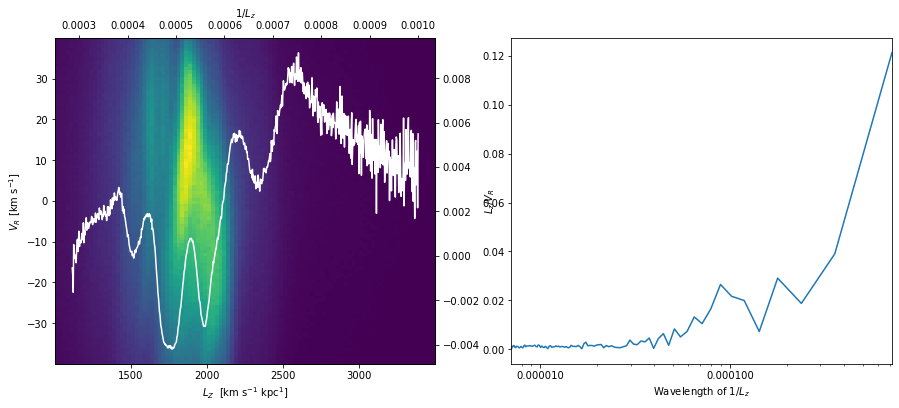

In [724]:
BIAS = -840*0

#TIME = 2.0
#XMIN=1200
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = False

XMIN=1000
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2, new=True)
DATA = True

#TIME = 4.8
#XMIN=1000
#XMAX=3500
#BINSIZE = 50
#x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2, maxvr=100)
#DATA = False

fig, ax = plt.subplots(1,2,figsize=(15,6))

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
#f = interpolate.interp1d(nx, ny, kind='linear')
#xpol = np.linspace(nx[0], nx[-1], N)
#ypol = f(xpol)
if DATA:
    ax[0].hist2d(Lz[abs(VR)<40], VR[abs(VR)<40], bins=100);
else:
    ax[0].hist2d(Lz, VR, bins=100);
ax[0].set_aspect('auto')
ax[0].set_xlabel(r'$L_Z$  [km s$^{-1}$ kpc$^{1}$]')
ax[0].set_ylabel(r'$V_R$ [km s$^{-1}$] ')

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
ny = ny
nxo = nx
nx = np.log10(nx+BIAS)**P
f = interpolate.interp1d(nx, ny, kind='linear')
print(nx[-1])
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)

#ypol = 5*np.sin(0.02*xpol)
#ax[0].hist2d(np.log10(Lz)**P, VR/Lz, bins=100);
#ax[0].plot(xpol, ypol, c='white')
#ax[0].set_aspect('auto')
#plt.scatter(roots, np.zeros(len(roots)), s=10, color='red', zorder=2)
#ax[0].plot(*smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE), c='grey', ls='--')
#ax[1].hist2d(np.log10(Lz+BIAS), VR/Lz, bins=100);
#ax[0].set_ylim(min(ypol), max(ypol))

nx, ny = smooth_bins(1/Lz, VR/Lz, 1/XMAX, 1/XMIN, 1e-6)
N = 100000
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[0].twiny()
ax_right.set_xlabel('1/$L_z$')
ax_right = ax_right.twinx()
ax_right.plot(xpol, ypol, c='white')
ax_right.set_ylabel('$L_z/V_R$')


#ypol = 5*np.sin(0.02*xpol)
#ax[0].hist2d(np.log10(Lz)**P, VR/Lz, bins=100);
#ax[0].plot(xpol, ypol, c='white')
#ax[0].set_aspect('auto')
#plt.scatter(roots, np.zeros(len(roots)), s=10, color='red', zorder=2)

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]


CUT = 3
xfr = ((nx[-1]-nx[0]) / abs(xf * N))
#axb = ax[1].twiny()
#axb.set_xlim(xfr[100], max(xfr))
#axb.set_xscale('log')
#axb.xaxis.set_major_formatter(ticker.ScalarFormatter())
#axb.set_xlabel('Wavelength in log($L_z-b$)')
ax[1].plot(xfr, np.abs(yf)/np.sum(np.abs(yf)))
print(xfr[abs(yf).argmax()])
#ax[1].plot(xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1], np.abs(yf)[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1]/np.sum(np.abs(yf)))
#ax[1].set_xlim(1e-2, 2.0)
ax[1].set_xlim(xfr[100], max(xfr))
ax[1].set_xscale('log')
ax[1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[1].set_aspect('auto')
ax[1].set_xlabel('Wavelength of $1/L_z$')
#plt.scatter(roots, np.zeros(len(roots)), s=10, color='red', zorder=2)
#plt.ylim(0, 1)
#plt.show()
#
#CUT = 1

In [877]:
times = np.arange(0.1, 3.0, 0.1)

wls = []
for time in times:
    XMIN=1200
    XMAX=3500
    BINSIZE = 10
    x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)
    DATA = False

    nx, ny = smooth_bins(1/Lz, VR, 1/XMAX, 1/XMIN, 2e-5)

    maxIndex_it = signal.find_peaks_cwt(ny,widths=np.arange(10,30,1),min_snr=1)

    goodIndex = []
    for index_it in maxIndex_it:
        countIt = np.sum(ny[index_it-5:index_it+6])
        if countIt/np.max(ny)<0.2:
            continue
        goodIndex.append(index_it)
    
    xpeaks = nx[goodIndex]
    wls.append(np.mean(xpeaks[1:] - xpeaks[:-1]))

plt.plot(times, 1/np.array(wls))

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



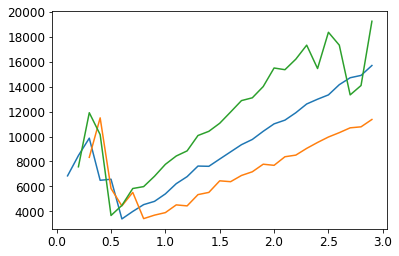

In [882]:

times = np.arange(0.1, 3.0, 0.1)

model_labels = ['n = 0', 'n = 0.1', 'n = -0.1']
for model_i, model in enumerate(['Dhot_log', 'Dhotn10_pn10', 'Dhotn_10_pn_10']):
    wls = []
    for time in times:
        XMIN=1200
        XMAX=3500
        BINSIZE = 10
        x,y,VR,Vphi,R,Lz,phi=l.load_model(model, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)
        DATA = False

        nx, ny = smooth_bins(1/Lz, VR, 1/XMAX, 1/XMIN, 2e-6)

        maxIndex_it = signal.find_peaks_cwt(ny,widths=np.arange(10,30,1),min_snr=1)

        goodIndex = []
        for index_it in maxIndex_it:
            countIt = np.sum(ny[index_it-5:index_it+6])
            if countIt/np.max(ny)<0.2:
                continue
            goodIndex.append(index_it)

        xpeaks = nx[goodIndex]
        wls.append(np.mean(xpeaks[1:] - xpeaks[:-1]))

    plt.plot(times, 1/np.array(wls))

3.424881636631067
0.21714478396594494
/tmp/ipykernel_563989/3833509438.py:54: RuntimeWarning: divide by zero encountered in true_divide
  xfr = ((nx[-1]-nx[0]) / abs(xf * N))

[0.08685791 0.09650879 0.10857239 0.12408273 0.14476319 0.17371583
 0.21714478 0.28952638 0.43428957 0.86857914]
[ 232.38422187  258.3055775   290.75249159  332.55324198  388.45484208
  467.09417046  586.05380624  787.72485206 1208.92630844 2726.42626291]
586.0538062399313
/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)



(-20.0, 20.0)

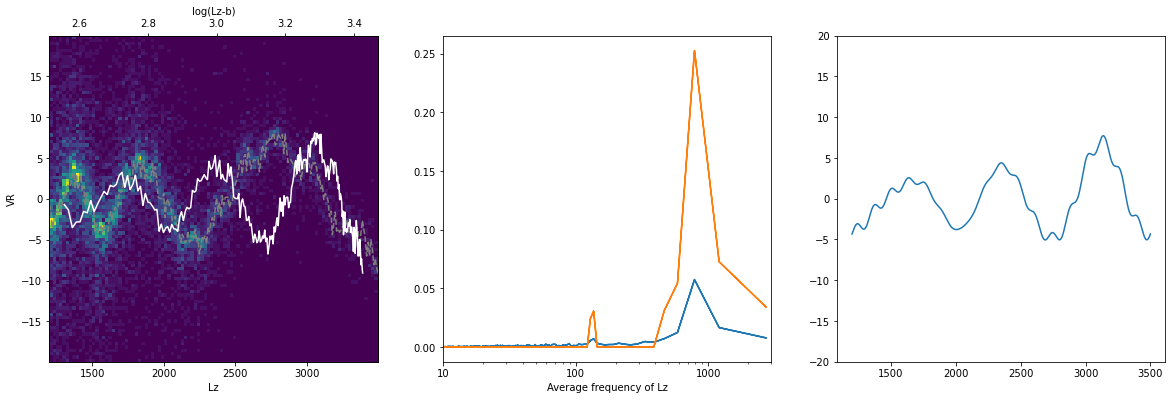

In [226]:

BIAS = -840

TIME = 1.0
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = False

#XMIN=1000
#XMAX=3000
#BINSIZE = 50
#x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = True

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
ny = ny
nx = np.log10(nx+BIAS)**P
f = interpolate.interp1d(nx, ny, kind='linear')
print(nx[-1])
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)

fig, ax = plt.subplots(1,3,figsize=(20,6))
#ypol = 5*np.sin(0.02*xpol)
#ax[0].hist2d(np.log10(Lz)**P, VR/Lz, bins=100);
#ax[0].plot(xpol, ypol, c='white')
#ax[0].set_aspect('auto')
#plt.scatter(roots, np.zeros(len(roots)), s=10, color='red', zorder=2)
ax[0].hist2d(Lz, VR, bins=100);
ax[0].set_xlabel('Lz')
ax[0].set_ylabel('VR')
ax[0].plot(*smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE), c='grey', ls='--')
#ax[1].hist2d(np.log10(Lz+BIAS), VR/Lz, bins=100);
ax_right = ax[0].twiny()
ax_right.plot(xpol, ypol, c='white')
ax_right.set_xlabel('log(Lz-b)')
#ax[0].set_ylim(min(ypol), max(ypol))

yparams = [ypol.mean(), ypol.min(), ypol.max()]
ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
#yf = yf[xf>0]
#xf = xf[xf>0]
print((nx[-1]-nx[0]) / abs(xf[yf.argmax()] * N))

CUT = 3
xfr = ((nx[-1]-nx[0]) / abs(xf * N))
avglz = (nx[-1] - nx[0])/2
avglz = np.log10((XMIN + XMAX)/2)
avglz = np.log10(2000+BIAS)
xfr = (10**(avglz+xfr/2) - 10**(avglz-xfr/2))
ax[1].plot(xfr, np.abs(yf)/np.sum(np.abs(yf)))
print(xfr[yf.argmax()])
#ax[1].plot(xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1], np.abs(yf)[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1]/np.sum(np.abs(yf)))
#ax[1].set_xlim(1e-2, 2.0)
ax[1].set_xlim(10, 3000)
ax[1].set_xscale('log')
ax[1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[1].set_aspect('auto')
ax[1].set_xlabel('Average frequency of Lz')
#plt.scatter(roots, np.zeros(len(roots)), s=10, color='red', zorder=2)
#plt.ylim(0, 1)
#plt.show()
#
#CUT = 1
yf2 = np.copy(yf)
yf2[0:abs(yf).argmax()+CUT+1] = 0
#ax[1].plot(xfr, np.abs(yf2)/np.sum(np.abs(yf)))
#ax[0].plot(xpol[1:], ifft(yf)/20, color='y')

yf[np.abs(yf)/np.sum(np.abs(yf)) < 0.005] = 0
ax[1].plot(xfr, np.abs(yf)/np.sum(np.abs(yf)))
ax[2].plot(np.linspace(XMIN, XMAX, N), ifft(yf) * (yparams[2] - yparams[1]) + yparams[0])
ax[2].set_ylim(-20,20)


/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

3500.0
1250.0
3.5440680443502757
0.1813560147834252
3.424881636631067
0.3051904134937855


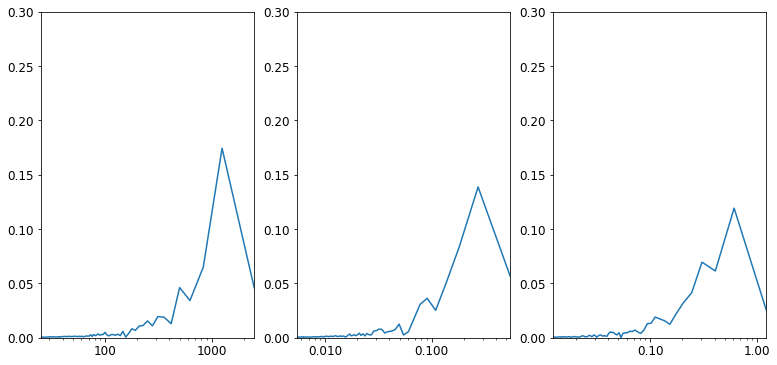

In [520]:
BIAS = -840

TIME = 1.0
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)

XMIN=1000
XMAX=3000
BINSIZE = 50
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)

TIME = 3.0
XMIN=1000
XMAX=3500
BINSIZE = 50
x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2, maxvr=100)
DATA = False

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
nxs = [nx, np.log10(nx), np.log10(nx+BIAS)]
nx_names = ["Lz", "log(Lz)", "log(Lz+bias)"]
fig, ax = plt.subplots(1,3,figsize=(13,6))
for nxi, nx in enumerate(nxs):
    N = 100000
    f = interpolate.interp1d(nx, ny, kind='linear')
    print(nx[-1])
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    N = len(ypol)

    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    yf = yf[xf>0]
    xf = xf[xf>0]

    CUT = 3
    xfr = ((nx[-1]-nx[0]) / abs(xf * N))
    #avglz = (nx[-1] - nx[0])/2
    #avglz = np.log10((XMIN + XMAX)/2)
    #avglz = np.log10(2000+BIAS)
    #xfr = (10**(avglz+xfr/2) - 10**(avglz-xfr/2))
    ax[nxi].plot(xfr, np.abs(yf)/np.sum(np.abs(yf)))
    print(xfr[yf.argmax()])
    #ax[1].plot(xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1], np.abs(yf)[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1]/np.sum(np.abs(yf)))
    #ax[1].set_xlim(1e-2, 2.0)
    ax[nxi].set_xlim(min(xfr[:100]), max(xfr))
    ax[nxi].set_ylim(0, 0.3)
    ax[nxi].set_xscale('log')
    ax[nxi].xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax[nxi].set_aspect('auto')
    #ax[nxi].set_title(nx_names[i])


-900.0
-869.4915254237288
-838.9830508474577
-808.4745762711864
-777.9661016949152
-747.457627118644
-716.9491525423729
-686.4406779661017
-655.9322033898305
-625.4237288135594
-594.9152542372881
-564.406779661017
-533.8983050847457
-503.3898305084746
-472.8813559322034
-442.3728813559322
-411.864406779661
-381.3559322033898
-350.8474576271186
-320.33898305084745
-289.8305084745763
-259.3220338983051
-228.81355932203394
-198.30508474576266
-167.7966101694915
-137.28813559322032
-106.77966101694915
-76.27118644067798
-45.76271186440681
-15.254237288135528
15.254237288135641
45.76271186440681
76.27118644067798
106.77966101694915
137.28813559322043
167.7966101694915
198.30508474576277
228.81355932203383
259.3220338983051
289.8305084745764
320.33898305084745
350.84745762711873
381.3559322033898
411.86440677966107
442.3728813559321
472.8813559322034
503.3898305084747
533.8983050847457
564.406779661017
594.9152542372881
625.4237288135594
655.9322033898304
686.4406779661017
716.949152542373
7

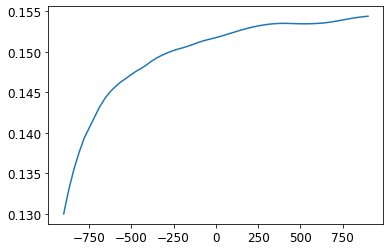

In [441]:
#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')


TIME = 1.4
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)

#XMIN=1500
#XMAX=2300
#BINSIZE = 1
#x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)

TIME = 2.5
XMIN=1000
XMAX=3500
BINSIZE = 50
x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2, maxvr=100)
indphi=(Lz>1000)
x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
DATA = False

biases = np.linspace(-900, 900, 60)
peaks = []
for bias in biases:
    print(bias)
    nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
    N = 100000
    P = 1
    ny = ny
    nx = np.log10(nx+bias)**P
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    N = len(ypol)

    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    yf = yf[xf>0]
    xf = xf[xf>0]
    CUT = 5
    xfr = ((nx[-1]-nx[0]) / abs(xf * N))
    peaks.append(np.max(abs(yf)) / np.sum(abs(yf)))

plt.plot(biases, peaks)
print(biases[np.argmax(peaks)])

0.1 900.0
0.30000000000000004 -777.9661016949152
0.5000000000000001 -472.8813559322034
0.7000000000000001 -503.3898305084746
0.9000000000000001 -625.4237288135594
1.1000000000000003 -655.9322033898305
1.3000000000000003 900.0
1.5000000000000004 -900.0
1.7000000000000004 472.8813559322034
1.9000000000000004 -686.4406779661017
2.1000000000000005 -900.0
2.3000000000000007 900.0
2.5000000000000004 -655.9322033898305
2.7000000000000006 900.0
2.900000000000001 900.0
3.1000000000000005 900.0
3.3000000000000007 900.0
3.500000000000001 900.0
3.7000000000000006 686.4406779661017
3.900000000000001 869.491525423729
4.1000000000000005 -228.81355932203394
4.300000000000001 198.30508474576277
4.500000000000001 900.0
4.7 900.0
4.9 289.8305084745764
5.1000000000000005 472.8813559322034
5.300000000000001 900.0
5.500000000000001 167.7966101694915
5.700000000000001 900.0
5.9 900.0
6.1000000000000005 900.0
6.300000000000001 -869.4915254237288
6.500000000000001 -900.0
6.700000000000001 900.0
6.9000000000000

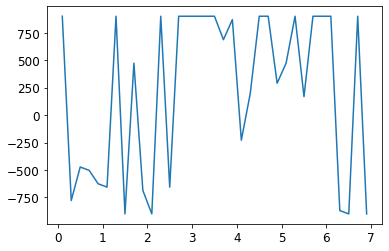

In [442]:
#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')


#xtime = np.linspace(0.1, 3, 25)
xtime = np.arange(0.1, 7, 0.2)
ytime = []

for TIME in xtime:
    #XMIN=1200
    #XMAX=3500
    #BINSIZE = 10
    #x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)

    #XMIN=1500
    #XMAX=2300
    #BINSIZE = 1
    #x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
    
    XMIN=1000
    XMAX=3500
    BINSIZE = 50
    x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2, maxvr=100)
    indphi=(Lz>1000)
    x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
    DATA = False
    
    #biases = np.linspace(-1000, 0, 50)
    biases = np.linspace(-900, 900, 60)
    peaks = []
    for bias in biases:
        nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
        N = 100000
        P = 1
        ny = ny / nx
        nx = np.log10(nx+bias)**P
        f = interpolate.interp1d(nx, ny, kind='linear')
        xpol = np.linspace(nx[0], nx[-1], N)
        ypol = f(xpol)
        xpol = xpol[~np.isnan(ypol)]
        ypol = ypol[~np.isnan(ypol)]
        N = len(ypol)

        ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
        yf = fft(ypol)
        xf = fftfreq(N)
        yf = yf[xf>0]
        xf = xf[xf>0]
        CUT = 5
        xfr = ((nx[-1]-nx[0]) / abs(xf * N))
        peaks.append(np.max(abs(yf)) / np.sum(abs(yf)))

    #plt.plot(biases, peaks)
    print(TIME, biases[np.argmax(peaks)])
    ytime.append(biases[np.argmax(peaks)])

plt.plot(xtime, ytime)
print(np.mean(ytime))

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5000000000000004
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1
4.2
4.3
4.3999999999999995
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9


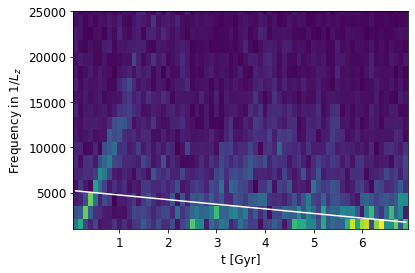

In [695]:

#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')

BIAS = -840*0
eps = 0.00001
#times = np.arange(eps, 3.0+eps, 0.02)
times = np.arange(0.1, 7.0, 0.1)
vtimes = list(times)

fourier = []
freqs = []
freqs2 = []
for time in times:
    print(time)
    
    #XMIN=1200
    #XMAX=3500
    #BINSIZE = 10
    #x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)
    
    XMIN=1000
    XMAX=3500
    BINSIZE = 50
    x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', time, xmin=XMIN, xmax=XMAX, phi_range=0.2, maxvr=100)
    DATA = False
    
    nx, ny = smooth_bins(1/Lz, VR/Lz, 1/XMAX, 1/XMIN, 1e-5)
    N = 100000
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    N = len(ypol)
    
    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    yf = yf[xf>0]
    xf = xf[xf>0]
    xfr = ((nx[-1]-nx[0]) / abs(xf * N))
    fourier.append(yf)
    
    CUT = 4
    relxfr = xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
    relyf = yf[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
    freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
    if time > 2 and 1/freq < 1:  # Outliers (wrong peak detected)
        vtimes.remove(time)
        continue
    freqs.append(freq)
    
    CUT = 4
    yfb = yf.copy()
    yfb[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1] = 0
    relxfr = xfr[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1]
    relyf = yfb[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1]
    freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
    freqs2.append(freq)

np.save('fourier_time_mwsgr_10_35.npy', fourier)
    
fourier = np.abs(np.array(fourier))
xfr = xfr[:100]
fourier = fourier[:,:100]

Z = fourier.T/np.sum(fourier, axis=1)
#f = [interpolate.interp1d(xfr,fou,kind='linear') for fou in fourier]
#y_coords = np.linspace(min(xfr),max(xfr),500)
#Z = [fi(y_coords) for fi in f]
#Z = np.array(Z).T
#plt.imshow(fourier,extent=[min(times),max(times),0,max(times)],origin="lower")
#f = interpolate.interp2d(times,xfr,fourier,kind="linear")
#x_coords = times
#y_coords = np.linspace(min(xfr),max(xfr),200)
#Z = f(x_coords,y_coords)
#Z = Z/Z.sum(axis=1,keepdims=1)
#plt.imshow((Z/np.max(Z)),extent=[min(times),max(times),min(xfr),max(xfr)],origin="lower",aspect="auto",cmap='viridis')
#plt.pcolormesh(times, xfr, fourier.T, shading='gouraud', cmap='viridis')
#plt.pcolormesh(times, 1/xfr, fourier.T, cmap='viridis')
plt.pcolormesh(times, 1/xfr, Z, cmap='viridis')
plt.xlabel('t [Gyr]')
plt.ylabel(r'Frequency in $1/L_z$')
plt.ylim(1000,25000)


#plt.plot(vtimes, np.array(freqs), color='w')
 
fit = np.polyfit(vtimes, 1/np.array(freqs), 1)
pol = np.poly1d(fit)
#plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w')
plt.plot(times, pol(times), c='w')

fit = np.polyfit(vtimes, 1/np.array(freqs2), 1)
pol = np.poly1d(fit)
#plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w', ls='--')
#plt.plot(times, pol(times), c='w', ls='--')


namef='plots/fourier_time'+('data' if DATA else CURMODEL)+'.png'
plt.savefig(namef, bbox_inches='tight')

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5000000000000004
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1
4.2
4.3
4.3999999999999995
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9


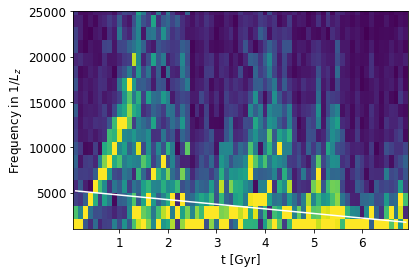

In [706]:

#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')

BIAS = -840*0
eps = 0.00001
#times = np.arange(eps, 3.0+eps, 0.02)
times = np.arange(0.1, 7.0, 0.1)
vtimes = list(times)

fourier = []
freqs = []
freqs2 = []
for time in times:
    print(time)
    
    #XMIN=1200
    #XMAX=3500
    #BINSIZE = 10
    #x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)
    
    XMIN=1000
    XMAX=3500
    BINSIZE = 50
    x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', time, xmin=XMIN, xmax=XMAX, phi_range=0.2, maxvr=100)
    DATA = False
    
    nx, ny = smooth_bins(1/Lz, VR/Lz, 1/XMAX, 1/XMIN, 1e-5)
    N = 100000
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    N = len(ypol)
    
    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    yf = yf[xf>0]
    xf = xf[xf>0]
    xfr = ((nx[-1]-nx[0]) / abs(xf * N))
    fourier.append(yf)
    
    CUT = 4
    relxfr = xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
    relyf = yf[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
    freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
    if time > 2 and 1/freq < 1:  # Outliers (wrong peak detected)
        vtimes.remove(time)
        continue
    freqs.append(freq)
    
    CUT = 4
    yfb = yf.copy()
    yfb[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1] = 0
    relxfr = xfr[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1]
    relyf = yfb[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1]
    freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
    freqs2.append(freq)

np.save('fourier_time_mwsgr_10_35.npy', fourier)
    
fourier = np.abs(np.array(fourier))
xfr = xfr[:100]
fourier = fourier[:,:100]

Z = fourier.T/np.max(fourier, axis=1)
#f = [interpolate.interp1d(xfr,fou,kind='linear') for fou in fourier]
#y_coords = np.linspace(min(xfr),max(xfr),500)
#Z = [fi(y_coords) for fi in f]
#Z = np.array(Z).T
#plt.imshow(fourier,extent=[min(times),max(times),0,max(times)],origin="lower")
#f = interpolate.interp2d(times,xfr,fourier,kind="linear")
#x_coords = times
#y_coords = np.linspace(min(xfr),max(xfr),200)
#Z = f(x_coords,y_coords)
#Z = Z/Z.sum(axis=1,keepdims=1)
#plt.imshow((Z/np.max(Z)),extent=[min(times),max(times),min(xfr),max(xfr)],origin="lower",aspect="auto",cmap='viridis')
#plt.pcolormesh(times, xfr, fourier.T, shading='gouraud', cmap='viridis')
#plt.pcolormesh(times, 1/xfr, fourier.T, cmap='viridis')
plt.pcolormesh(times, 1/xfr, Z, cmap='viridis')
plt.xlabel('t [Gyr]')
plt.ylabel(r'Frequency in $1/L_z$')
plt.ylim(1000,25000)


#plt.plot(vtimes, np.array(freqs), color='w')
 
fit = np.polyfit(vtimes, 1/np.array(freqs), 1)
pol = np.poly1d(fit)
#plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w')
plt.plot(times, pol(times), c='w')

fit = np.polyfit(vtimes, 1/np.array(freqs2), 1)
pol = np.poly1d(fit)
#plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w', ls='--')
#plt.plot(times, pol(times), c='w', ls='--')


namef='plots/fourier_time'+('data' if DATA else CURMODEL)+'.png'
plt.savefig(namef, bbox_inches='tight')

In [ ]:
fourier ¡

fourier = np.abs(np.array(fourier))
xfr = xfr[:100]
fourier = fourier[:,:100]

Z = fourier.T/np.sum(fourier, axis=1)
#f = [interpolate.interp1d(xfr,fou,kind='linear') for fou in fourier]
#y_coords = np.linspace(min(xfr),max(xfr),500)
#Z = [fi(y_coords) for fi in f]
#Z = np.array(Z).T
#plt.imshow(fourier,extent=[min(times),max(times),0,max(times)],origin="lower")
#f = interpolate.interp2d(times,xfr,fourier,kind="linear")
#x_coords = times
#y_coords = np.linspace(min(xfr),max(xfr),200)
#Z = f(x_coords,y_coords)
#Z = Z/Z.sum(axis=1,keepdims=1)
#plt.imshow((Z/np.max(Z)),extent=[min(times),max(times),min(xfr),max(xfr)],origin="lower",aspect="auto",cmap='viridis')
#plt.pcolormesh(times, xfr, fourier.T, shading='gouraud', cmap='viridis')
#plt.pcolormesh(times, 1/xfr, fourier.T, cmap='viridis')
plt.pcolormesh(times, 1/xfr, Z, cmap='viridis')
plt.xlabel('t [Gyr]')
plt.ylabel(r'Frequency in $1/L_z$')
plt.ylim(1000,25000)


#plt.plot(vtimes, np.array(freqs), color='w')
 
fit = np.polyfit(vtimes, 1/np.array(freqs), 1)
pol = np.poly1d(fit)
#plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w')
plt.plot(times, pol(times), c='w')

fit = np.polyfit(vtimes, 1/np.array(freqs2), 1)
pol = np.poly1d(fit)
#plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w', ls='--')
#plt.plot(times, pol(times), c='w', ls='--')


namef='plots/fourier_time'+('data' if DATA else CURMODEL)+'.png'
plt.savefig(namef, bbox_inches='tight')

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5000000000000004
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1
4.2
4.3
4.3999999999999995
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9


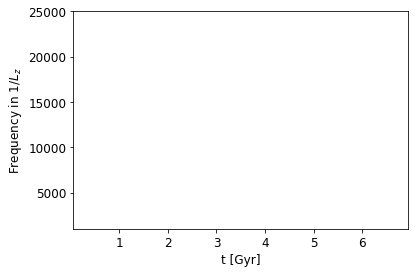

In [699]:

#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')

BIAS = -840*0
eps = 0.00001
#times = np.arange(eps, 3.0+eps, 0.02)
times = np.arange(0.1, 7.0, 0.1)
vtimes = list(times)

fourier = []
freqs = []
freqs2 = []
for time in times:
    print(time)
    
    #XMIN=1200
    #XMAX=3500
    #BINSIZE = 10
    #x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)
    
    XMIN=1000
    XMAX=3500
    BINSIZE = 50
    x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', time, xmin=XMIN, xmax=XMAX, phi_range=0.2, maxvr=100)
    DATA = False
    
    nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, 20)
    N = 100000
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    N = len(ypol)
    
    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    yf = yf[xf>0]
    xf = xf[xf>0]
    xfr = ((nx[-1]-nx[0]) / abs(xf * N))
    fourier.append(yf)
    
    CUT = 4
    relxfr = xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
    relyf = yf[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
    freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
    if time > 2 and 1/freq < 1:  # Outliers (wrong peak detected)
        vtimes.remove(time)
        continue
    freqs.append(freq)
    
    CUT = 4
    yfb = yf.copy()
    yfb[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1] = 0
    relxfr = xfr[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1]
    relyf = yfb[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1]
    freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
    freqs2.append(freq)

np.save('fourier_time_mwsgr_10_35.npy', fourier)
    
fourier = np.abs(np.array(fourier))
xfr = xfr[:100]
fourier = fourier[:,:100]

Z = fourier.T/np.sum(fourier, axis=1)
#f = [interpolate.interp1d(xfr,fou,kind='linear') for fou in fourier]
#y_coords = np.linspace(min(xfr),max(xfr),500)
#Z = [fi(y_coords) for fi in f]
#Z = np.array(Z).T
#plt.imshow(fourier,extent=[min(times),max(times),0,max(times)],origin="lower")
#f = interpolate.interp2d(times,xfr,fourier,kind="linear")
#x_coords = times
#y_coords = np.linspace(min(xfr),max(xfr),200)
#Z = f(x_coords,y_coords)
#Z = Z/Z.sum(axis=1,keepdims=1)
#plt.imshow((Z/np.max(Z)),extent=[min(times),max(times),min(xfr),max(xfr)],origin="lower",aspect="auto",cmap='viridis')
#plt.pcolormesh(times, xfr, fourier.T, shading='gouraud', cmap='viridis')
#plt.pcolormesh(times, 1/xfr, fourier.T, cmap='viridis')
plt.pcolormesh(times, 1/xfr, Z, cmap='viridis')
plt.xlabel('t [Gyr]')
plt.ylabel(r'Frequency in $1/L_z$')
plt.ylim(1000,25000)


#plt.plot(vtimes, np.array(freqs), color='w')
 
fit = np.polyfit(vtimes, 1/np.array(freqs), 1)
pol = np.poly1d(fit)
#plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w')
plt.plot(times, pol(times), c='w')

fit = np.polyfit(vtimes, 1/np.array(freqs2), 1)
pol = np.poly1d(fit)
#plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w', ls='--')
#plt.plot(times, pol(times), c='w', ls='--')


namef='plots/fourier_time'+('data' if DATA else CURMODEL)+'.png'
plt.savefig(namef, bbox_inches='tight')

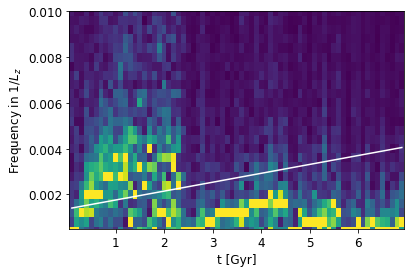

In [705]:

fourier = np.abs(np.array(fourier))
xfr = xfr[:100]
fourier = fourier[:,:100]

Z = fourier.T/np.max(fourier, axis=1)
#f = [interpolate.interp1d(xfr,fou,kind='linear') for fou in fourier]
#y_coords = np.linspace(min(xfr),max(xfr),500)
#Z = [fi(y_coords) for fi in f]
#Z = np.array(Z).T
#plt.imshow(fourier,extent=[min(times),max(times),0,max(times)],origin="lower")
#f = interpolate.interp2d(times,xfr,fourier,kind="linear")
#x_coords = times
#y_coords = np.linspace(min(xfr),max(xfr),200)
#Z = f(x_coords,y_coords)
#Z = Z/Z.sum(axis=1,keepdims=1)
#plt.imshow((Z/np.max(Z)),extent=[min(times),max(times),min(xfr),max(xfr)],origin="lower",aspect="auto",cmap='viridis')
#plt.pcolormesh(times, xfr, fourier.T, shading='gouraud', cmap='viridis')
#plt.pcolormesh(times, 1/xfr, fourier.T, cmap='viridis')
plt.pcolormesh(times, 1/xfr, Z, cmap='viridis')
plt.xlabel('t [Gyr]')
plt.ylabel(r'Frequency in $1/L_z$')
plt.ylim(0.0005,0.01)


#plt.plot(vtimes, np.array(freqs), color='w')
 
fit = np.polyfit(vtimes, 1/np.array(freqs), 1)
pol = np.poly1d(fit)
#plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w')
plt.plot(times, pol(times), c='w')

fit = np.polyfit(vtimes, 1/np.array(freqs2), 1)
pol = np.poly1d(fit)
#plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w', ls='--')
#plt.plot(times, pol(times), c='w', ls='--')


namef='plots/fourier_time'+('data' if DATA else CURMODEL)+'.png'
plt.savefig(namef, bbox_inches='tight')

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5000000000000004
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1
4.2
4.3
4.3999999999999995
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9


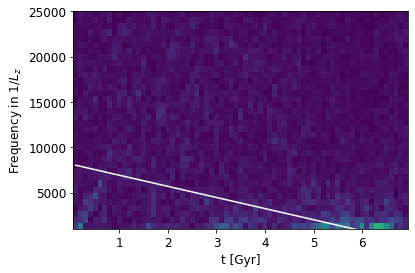

In [696]:

#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')

BIAS = -840*0
eps = 0.00001
#times = np.arange(eps, 3.0+eps, 0.02)
times = np.arange(0.1, 7.0, 0.1)
vtimes = list(times)

fourier = []
freqs = []
freqs2 = []
for time in times:
    print(time)
    
    #XMIN=1200
    #XMAX=3500
    #BINSIZE = 10
    #x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)
    
    XMIN=500
    XMAX=2000
    BINSIZE = 50
    x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', time, xmin=XMIN, xmax=XMAX, phi_range=0.2, maxvr=100)
    DATA = False
    
    nx, ny = smooth_bins(1/Lz, VR/Lz, 1/XMAX, 1/XMIN, 1e-5)
    N = 100000
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    N = len(ypol)
    
    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    yf = yf[xf>0]
    xf = xf[xf>0]
    xfr = ((nx[-1]-nx[0]) / abs(xf * N))
    fourier.append(yf)
    
    CUT = 4
    relxfr = xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
    relyf = yf[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
    freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
    if time > 2 and 1/freq < 1:  # Outliers (wrong peak detected)
        vtimes.remove(time)
        continue
    freqs.append(freq)
    
    CUT = 4
    yfb = yf.copy()
    yfb[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1] = 0
    relxfr = xfr[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1]
    relyf = yfb[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1]
    freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
    freqs2.append(freq)

    
np.save('fourier_time_mwsgr_5_20.npy', fourier)

fourier = np.abs(np.array(fourier))
xfr = xfr[:100]
fourier = fourier[:,:100]

Z = fourier.T/np.sum(fourier, axis=1)
#f = [interpolate.interp1d(xfr,fou,kind='linear') for fou in fourier]
#y_coords = np.linspace(min(xfr),max(xfr),500)
#Z = [fi(y_coords) for fi in f]
#Z = np.array(Z).T
#plt.imshow(fourier,extent=[min(times),max(times),0,max(times)],origin="lower")
#f = interpolate.interp2d(times,xfr,fourier,kind="linear")
#x_coords = times
#y_coords = np.linspace(min(xfr),max(xfr),200)
#Z = f(x_coords,y_coords)
#Z = Z/Z.sum(axis=1,keepdims=1)
#plt.imshow((Z/np.max(Z)),extent=[min(times),max(times),min(xfr),max(xfr)],origin="lower",aspect="auto",cmap='viridis')
#plt.pcolormesh(times, xfr, fourier.T, shading='gouraud', cmap='viridis')
#plt.pcolormesh(times, 1/xfr, fourier.T, cmap='viridis')
plt.pcolormesh(times, 1/xfr, Z, cmap='viridis')
plt.xlabel('t [Gyr]')
plt.ylabel(r'Frequency in $1/L_z$')
plt.ylim(1000,25000)


#plt.plot(vtimes, np.array(freqs), color='w')
 
fit = np.polyfit(vtimes, 1/np.array(freqs), 1)
pol = np.poly1d(fit)
#plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w')
plt.plot(times, pol(times), c='w')

fit = np.polyfit(vtimes, 1/np.array(freqs2), 1)
pol = np.poly1d(fit)
#plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w', ls='--')
#plt.plot(times, pol(times), c='w', ls='--')


namef='plots/fourier_time'+('data' if DATA else CURMODEL)+'.png'
plt.savefig(namef, bbox_inches='tight')

Dhot_log
Dhotn10_pn10
Dhotn_10_pn_10
Dhot_log_2perturb


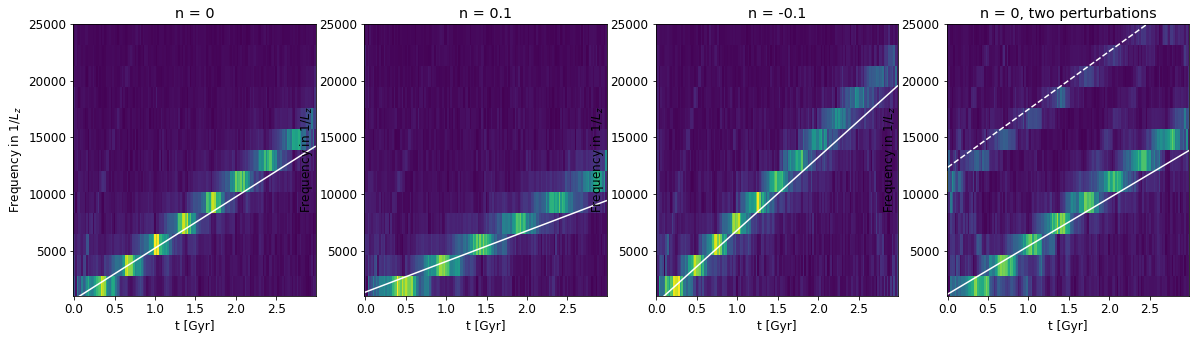

In [692]:

#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')


eps = 0.00001
times = np.arange(eps, 3.0+eps, 0.02)
vtimes = list(times)

fig, ax = plt.subplots(1,4,figsize=(20,5))
#fig = plt.figure(constrained_layout=False,figsize=(ncols*2.45,nrows*2.5))
#gs = fig.add_gridspec(nrows,ncols, hspace=0., wspace=0.)
#ax = gs.subplots(sharex=True,sharey=True)

model_labels = ['n = 0', 'n = 0.1', 'n = -0.1', 'n = 0, two perturbations']
for model_i, model in enumerate(['Dhot_log', 'Dhotn10_pn10', 'Dhotn_10_pn_10', 'Dhot_log_2perturb']):
    print(model)
    fourier = []
    freqs = []
    freqs2 = []
    for time in times:
        XMIN=1200
        XMAX=3500
        BINSIZE = 10
        x,y,VR,Vphi,R,Lz,phi=l.load_model(model, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)
        DATA = False

        nx, ny = smooth_bins(1/Lz, VR/Lz, 1/XMAX, 1/XMIN, 1e-5)
        N = 100000
        f = interpolate.interp1d(nx, ny, kind='linear')
        xpol = np.linspace(nx[0], nx[-1], N)
        ypol = f(xpol)
        xpol = xpol[~np.isnan(ypol)]
        ypol = ypol[~np.isnan(ypol)]
        N = len(ypol)

        ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
        yf = fft(ypol)
        xf = fftfreq(N)
        yf = yf[xf>0]
        xf = xf[xf>0]
        xfr = ((nx[-1]-nx[0]) / abs(xf * N))
        fourier.append(yf)

        CUT = 4
        relxfr = xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        relyf = yf[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        if time > 2 and 1/freq < 1:  # Outliers (wrong peak detected)
            vtimes.remove(time)
            continue
        freqs.append(freq)

        CUT = 4
        yfb = yf.copy()
        yfb[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1] = 0
        relxfr = xfr[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1]
        relyf = yfb[max(0,abs(yfb).argmax()-CUT):abs(yfb).argmax()+CUT+1]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        freqs2.append(freq)

    fourier = np.abs(np.array(fourier))
    xfr = xfr[:100]
    fourier = fourier[:,:100]

    #Z = fourier.T/np.max(fourier, axis=1)
    Z = fourier.T/np.sum(fourier, axis=1)
    #f = [interpolate.interp1d(xfr,fou,kind='linear') for fou in fourier]
    #y_coords = np.linspace(min(xfr),max(xfr),500)
    #Z = [fi(y_coords) for fi in f]
    #Z = np.array(Z).T
    #plt.imshow(fourier,extent=[min(times),max(times),0,max(times)],origin="lower")
    #f = interpolate.interp2d(times,xfr,fourier,kind="linear")
    #x_coords = times
    #y_coords = np.linspace(min(xfr),max(xfr),200)
    #Z = f(x_coords,y_coords)
    #Z = Z/Z.sum(axis=1,keepdims=1)
    #plt.imshow((Z/np.max(Z)),extent=[min(times),max(times),min(xfr),max(xfr)],origin="lower",aspect="auto",cmap='viridis')
    #plt.pcolormesh(times, xfr, fourier.T, shading='gouraud', cmap='viridis')
    #plt.pcolormesh(times, 1/xfr, fourier.T, cmap='viridis')
    ax[model_i].pcolormesh(times, 1/xfr, Z, cmap='viridis')
    ax[model_i].set_xlabel('t [Gyr]')
    ax[model_i].set_ylabel(r'Frequency in $1/L_z$')
    ax[model_i].set_ylim(1000,25000)
    ax[model_i].set_title(model_labels[model_i])


    #plt.plot(vtimes, np.array(freqs), color='w')

    fit = np.polyfit(vtimes, 1/np.array(freqs), 1)
    pol = np.poly1d(fit)
    #plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w')
    ax[model_i].plot(times, pol(times), c='w')

    if model == 'Dhot_log_2perturb':
        fit = np.polyfit(vtimes, 1/np.array(freqs2), 1)
        pol = np.poly1d(fit)
        #plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w', ls='--')
        ax[model_i].plot(times, pol(times), c='w', ls='--')


    namef='plots/fourier_time'+'_simplemodels'+'.png'
    plt.savefig(namef, bbox_inches='tight')

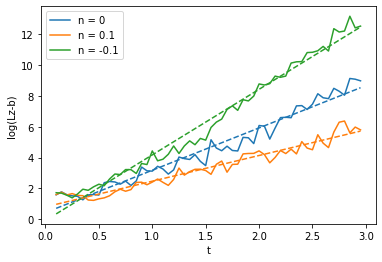

In [320]:
model_labels = ['n = 0', 'n = 0.1', 'n = -0.1']
for model_i, model in enumerate(['Dhot_log', 'Dhotn10_pn10', 'Dhotn_10_pn_10']):
#for model_i, model in enumerate(['Dhotn_10_pn_10']):
    
    BIAS = -840
    times = np.arange(0.1, 3.0, 0.05)
    vtimes = list(times)
    freqs = []
    freqs2 = []

    for time in times:
        XMIN=1200
        XMAX=3500
        BINSIZE = 10
        x,y,VR,Vphi,R,Lz,phi=l.load_model(model, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)
        DATA = False

        nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
        N = 100000
        P = 1
        ny = ny / nx
        nx = np.log10(nx+BIAS)**P
        f = interpolate.interp1d(nx, ny, kind='linear')
        xpol = np.linspace(nx[0], nx[-1], N)
        ypol = f(xpol)
        xpol = xpol[~np.isnan(ypol)]
        ypol = ypol[~np.isnan(ypol)]
        N = len(ypol)
        
        ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
        yf = fft(ypol)
        xf = fftfreq(N)
        yf = yf[xf>0]
        xf = xf[xf>0]
        xfr = ((nx[-1]-nx[0]) / abs(xf * N))
        #print(time, xfr[yf.argmax()])
        #freqs.append(xfr[yf.argmax()])
        CUT = 5
        #freqs2.append(sum(xfr*np.abs(yf))/sum(abs(yf)))
        relxfr = xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        relyf = yf[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        if time > 2 and 1/freq < 1:  # Outliers (wrong peak detected)
            vtimes.remove(time)
            continue
        freqs.append(freq)
        #if (1/freq < 2 and time > 2):
        #    print(time,1/freq)
        CUT = 0
        #freqs2.append(sum(xfr*np.abs(yf))/sum(abs(yf)))
        relxfr = xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1]
        relyf = yf[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        freqs2.append(freq)


    #plt.plot(times, 1/np.array(freqs2))
    plt.plot(vtimes, 1/np.array(freqs), c=f'C{model_i}', label=model_labels[model_i])

    fit = np.polyfit(vtimes, 1/np.array(freqs), 1)
    
    pol = np.poly1d(fit)
    plt.plot(times, pol(times), c=f'C{model_i}', ls='--')

plt.xlabel('t')
plt.ylabel('log(Lz-b)')
plt.legend()

namef='plots/frequency_time.png'
plt.savefig(namef, bbox_inches='tight')

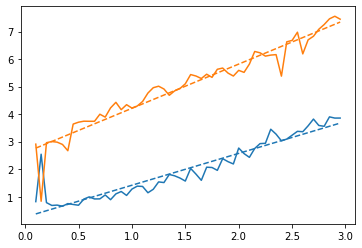

In [104]:
for model_i, model in enumerate(['Dhot_log_2perturb']):
    
    BIAS = -840
    times = np.arange(0.1, 3.0, 0.05)
    vtimes = list(times)
    freqs = []
    freqs2 = []

    for time in times:
        XMIN=1200
        XMAX=3500
        BINSIZE = 10
        x,y,VR,Vphi,R,Lz,phi=l.load_model(model, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)

        nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
        N = 100000
        P = 1
        ny = ny / nx
        nx = np.log10(nx+BIAS)**P
        f = interpolate.interp1d(nx, ny, kind='linear')
        xpol = np.linspace(nx[0], nx[-1], N)
        ypol = f(xpol)
        xpol = xpol[~np.isnan(ypol)]
        ypol = ypol[~np.isnan(ypol)]
        N = len(ypol)
        
        ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
        yf = fft(ypol)
        xf = fftfreq(N)
        yf = yf[xf>0]
        xf = xf[xf>0]
        xfr = ((nx[-1]-nx[0]) / abs(xf * N))
        #print(time, xfr[yf.argmax()])
        #freqs.append(xfr[yf.argmax()])
        CUT = 5
        #freqs2.append(sum(xfr*np.abs(yf))/sum(abs(yf)))
        relxfr = xfr[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        relyf = yf[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        if time > 2 and 1/freq < 1:  # Outliers (wrong peak detected)
            vtimes.remove(time)
            continue
        freqs.append(freq)
        #if (1/freq < 2 and time > 2):
        #    print(time,1/freq)
        CUT = 4
        #freqs2.append(sum(xfr*np.abs(yf))/sum(abs(yf)))
        yf2 = np.copy(yf)
        yf2[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1] = 0
        ax[0].plot(xfr, 2.0/N * np.abs(yf-yf2))
        ax[1].plot(xfr, 2.0/N * np.abs(yf2))
        relxfr = xfr[max(0,abs(yf2).argmax()-CUT):abs(yf2).argmax()+CUT+1]
        relyf = yf[max(0,abs(yf2).argmax()-CUT):abs(yf2).argmax()+CUT+1]
        freq = sum(relxfr*abs(relyf))/sum(abs(relyf))
        freqs2.append(freq)


    plt.plot(vtimes, 1/np.array(freqs), c='C0')
    plt.plot(vtimes, 1/np.array(freqs2), c='C1')

    fit = np.polyfit(vtimes, 1/np.array(freqs), 1)
    pol = np.poly1d(fit)
    plt.plot(times, pol(times), c=f'C0', ls='--')
    fit = np.polyfit(vtimes, 1/np.array(freqs2), 1)
    pol = np.poly1d(fit)
    plt.plot(times, pol(times), c=f'C1', ls='--')
    

namef='plots/frequency_time_2perturb.png'
plt.savefig(namef, bbox_inches='tight')

0.8685791358637798
0.2895263786212599
0.21714478396594494
0.02895263786212599
0.17371582717275597


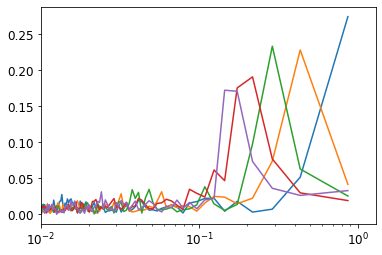

In [551]:
#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')

BIAS = -840
eps = 0.01
times = np.arange(0.5, 2.5+eps, 0.5)
freqs = []
freqs2 = []

for time in times:
    XMIN=1200
    XMAX=3500
    BINSIZE = 10
    x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)

    #XMIN=1500
    #XMAX=2300
    #BINSIZE = 1
    #x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)

    nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
    N = 100000
    P = 1
    ny = ny / nx
    nx = np.log10(nx+BIAS)**P
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    N = len(ypol)

    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    print((nx[-1]-nx[0]) / abs(xf[yf.argmax()] * N))
    yf = yf[xf>0]
    xf = xf[xf>0]
    xfr = ((nx[-1]-nx[0]) / abs(xf * N))
    
    CUT=4
    yf2 = np.copy(yf)
    yf2[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1] = 0
    
    plt.plot(xfr, 2.0/N * np.abs(yf))
    plt.xlim(1e-2, 1.3)
    plt.xscale('log')
    #plt.xaxis.set_major_formatter(ticker.ScalarFormatter())



/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

1.9999773703255894
/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

0.1999977370325589
/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

/home/hpc/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value e

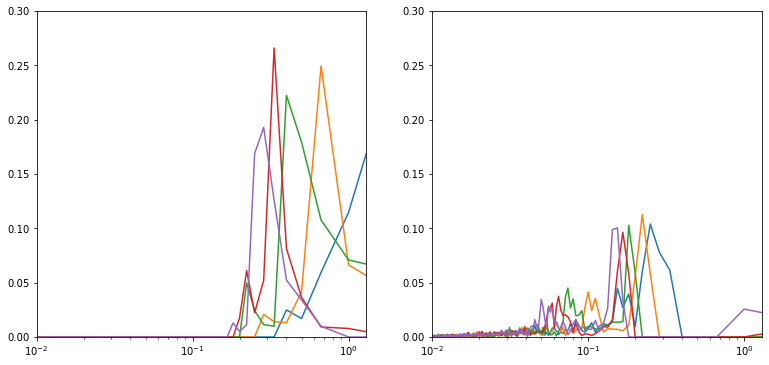

In [72]:

#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')

BIAS = -840
eps = 0.01
times = np.arange(0.5, 2.5+eps, 0.5)
freqs = []
freqs2 = []
fig, ax = plt.subplots(1,2,figsize=(13,6))

for time in times:
    XMIN=1200
    XMAX=3500
    BINSIZE = 10
    x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)

    #XMIN=1500
    #XMAX=2300
    #BINSIZE = 1
    #x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)

    nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
    N = 100000
    P = 1
    ny = ny / nx
    nx = np.log10(nx+BIAS)**P
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    N = len(ypol)

    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    print((nx[-1]-nx[0]) / abs(xf[yf.argmax()] * N))
    yf = yf[xf>0]
    xf = xf[xf>0]
    xfr = ((nx[-1]-nx[0]) / abs(xf * N))
    
    CUT=4
    yf2 = np.copy(yf)
    yf2[max(0,abs(yf).argmax()-CUT):abs(yf).argmax()+CUT+1] = 0
    
    ax[0].plot(xfr, 2.0/N * np.abs(yf-yf2))
    ax[1].plot(xfr, 2.0/N * np.abs(yf2))
    for a in ax:
        a.set_xlim(1e-2, 1.3)
        a.set_ylim(0, 0.3)
        a.set_xscale('log')
    #plt.xaxis.set_major_formatter(ticker.ScalarFormatter())


6.955515886790864 8.18721959318513
0.24634074127885325


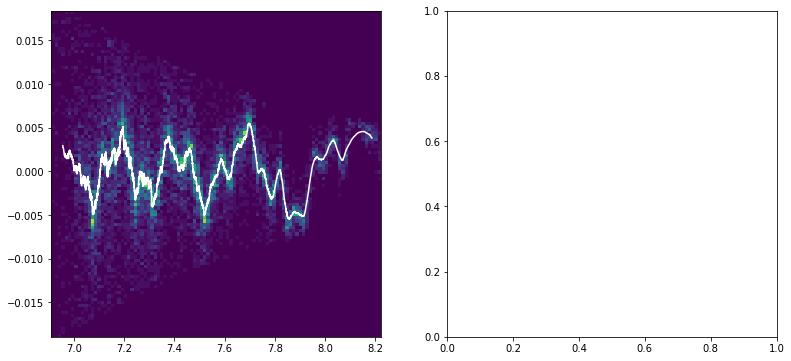

In [77]:

#N = 100000
#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')

TIME =  1.2

t=TIME*u.Gyr
x=o.x(t)
y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
VR=o.vr(t)
Vphi=o.vphi(t)*o.r(t)
R=o.r(t)
Lz=R*Vphi
phi=o.phi(t)

EPS = 0.001 * u.Gyr
AR = (VR - o.vr(t-EPS))

indphi=(np.abs(phi)>np.pi-0.2)&(np.abs(phi)<np.pi+0.2)
x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
AR = AR[indphi]
indphi=(np.abs(VR)<20)&(np.abs(Lz)>1000)
x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
AR = AR[indphi]

si = np.argsort(Lz)
sx = Lz[si]
sy = VR[si]
KNN = 100
nx = []
ny = []
for i in range(len(si)-KNN):
    nx.append(np.mean(sx[i:i+KNN]))
    ny.append(np.mean(sy[i:i+KNN]))
nx = np.array(nx)
ny = np.array(ny)

N = 100000
P = 1
ny = ny / nx
nx = np.log10(nx)**P
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
print(nx[0], nx[-1])
ypol = f(xpol)

fig, ax = plt.subplots(1,2,figsize=(13,6))
#ypol = 5*np.sin(0.02*xpol)
ax[0].hist2d(np.log10(Lz)**P, VR/Lz, bins=100);
ax[0].plot(xpol, ypol, c='white')
ax[0].set_aspect('auto')
#plt.scatter(roots, np.zeros(len(roots)), s=10, color='red', zorder=2)


ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
#yf[abs(yf) < 5000] = 0
#yf[abs(xf) > 0.0001] = 0
#print(sum(yf!=0))
print((nx[-1]-nx[0]) / abs(xf[yf.argmax()] * N))


1
0.0236716566440072


(0.0, 0.0003)

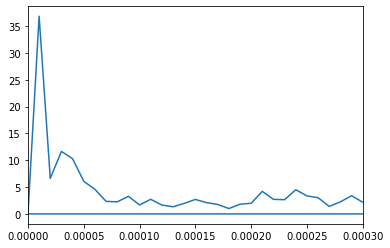

In [604]:

#N = 100000
#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')

TIME = 0.1

t=TIME*u.Gyr
x=o.x(t)
y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
VR=o.vr(t)
Vphi=o.vphi(t)*o.r(t)
R=o.r(t)
Lz=R*Vphi
phi=o.phi(t)

EPS = 0.001 * u.Gyr
AR = (VR - o.vr(t-EPS))

indphi=(np.abs(phi)>np.pi-0.2)&(np.abs(phi)<np.pi+0.2)
x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
AR = AR[indphi]
indphi=(np.abs(VR)<20)&(np.abs(Lz)>1000)
x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
AR = AR[indphi]

si = np.argsort(Lz)
sx = Lz[si]
sy = VR[si]
KNN = 100
nx = []
ny = []
for i in range(len(si)-KNN):
    nx.append(np.mean(sx[i:i+KNN]))
    ny.append(np.mean(sy[i:i+KNN]))
nx = np.array(nx)
ny = np.array(ny)
ny = ny / nx # Same amplitude

px = np.linspace(0.0005,2,100)
py = []
for P in px:
    N = 100000
    nx2 = np.log10(nx)**P
    f = interpolate.interp1d(nx2, ny, kind='linear')
    xpol = np.linspace(nx2[0], nx2[-1], N)
    ypol = f(xpol)
    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol, norm='ortho')
    xf = fftfreq(N)
    #print((nx[-1]-nx[0]) / abs(xf[yf.argmax()] * N))
    py.append(abs(yf.max()))
py = np.array(py)

P = px[py.argmax()]
P = 1
print(P)

N = 100000
nx2 = np.array(nx)
f = interpolate.interp1d(nx2, ny, kind='linear')
xpol = np.linspace(nx2[0], nx2[-1], N)
ypol = f(xpol)
ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol, norm='ortho')
xf = fftfreq(N)
#plt.plot(xf, abs(yf))


N = 100000
nx2 = np.log10(nx)**P
f = interpolate.interp1d(nx2, ny, kind='linear')
xpol = np.linspace(nx2[0], nx2[-1], N)
ypol = f(xpol)
ymean, ymax, ymin = ypol.mean(), ypol.max(), ypol.min()
ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol, norm='ortho')
xf = fftfreq(N)
print((nx2[-1]-nx2[0]) / abs(xf[yf.argmax()] * N))
plt.plot(xf, abs(yf))
#plt.xlim(0,0.0003)

#yf[abs(yf) < 5] = 0
#print(sum(yf>0))
#plt.hist2d(np.log10(Lz)**P, VR/Lz, bins=100);
#plt.plot(xpol, (ifft(yf, norm='ortho')*(ymax - ymin) + ymean), c='white')

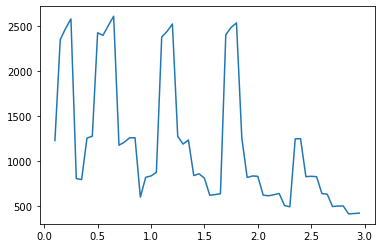

In [455]:
xtime = []
ytime = []

for time in np.arange(0.1, 3., 0.05):
    t=time*u.Gyr
    x=o.x(t)
    y=-o.y(t)#in galpy, orbits turn counterclockwise. changing sign of y we turn it into clockwise
    VR=o.vr(t)
    Vphi=o.vphi(t)*o.r(t)
    R=o.r(t)
    Lz=R*Vphi
    phi=o.phi(t)

    indphi=(np.abs(phi)>np.pi-0.2)&(np.abs(phi)<np.pi+0.2)
    x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]
    indphi=(np.abs(VR)<20)&(np.abs(Lz)>1000)
    x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]

    si = np.argsort(Lz)
    sx = Lz[si]
    sy = VR[si]
    KNN = 100
    nx = []
    ny = []
    for i in range(len(si)-KNN):
        nx.append(np.mean(sx[i:i+KNN]))
        ny.append(np.mean(sy[i:i+KNN]))

    N = 100000
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)

    ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
    yf = fft(ypol)
    xf = fftfreq(N)
    maxperiod = (nx[-1]-nx[0]) / abs(xf[yf.argmax()] * N)
    
    xtime.append(time)
    ytime.append(maxperiod)

plt.plot(xtime, ytime)
plt.show()

0.001
0.101
0.201
0.30100000000000005
0.401
0.501
0.6010000000000001
0.7010000000000001
0.801
0.901
1.001
1.101
1.201
1.301
1.401
1.501
1.601
1.701
1.801
1.901
2.001
2.101
2.201
2.301
2.4010000000000002


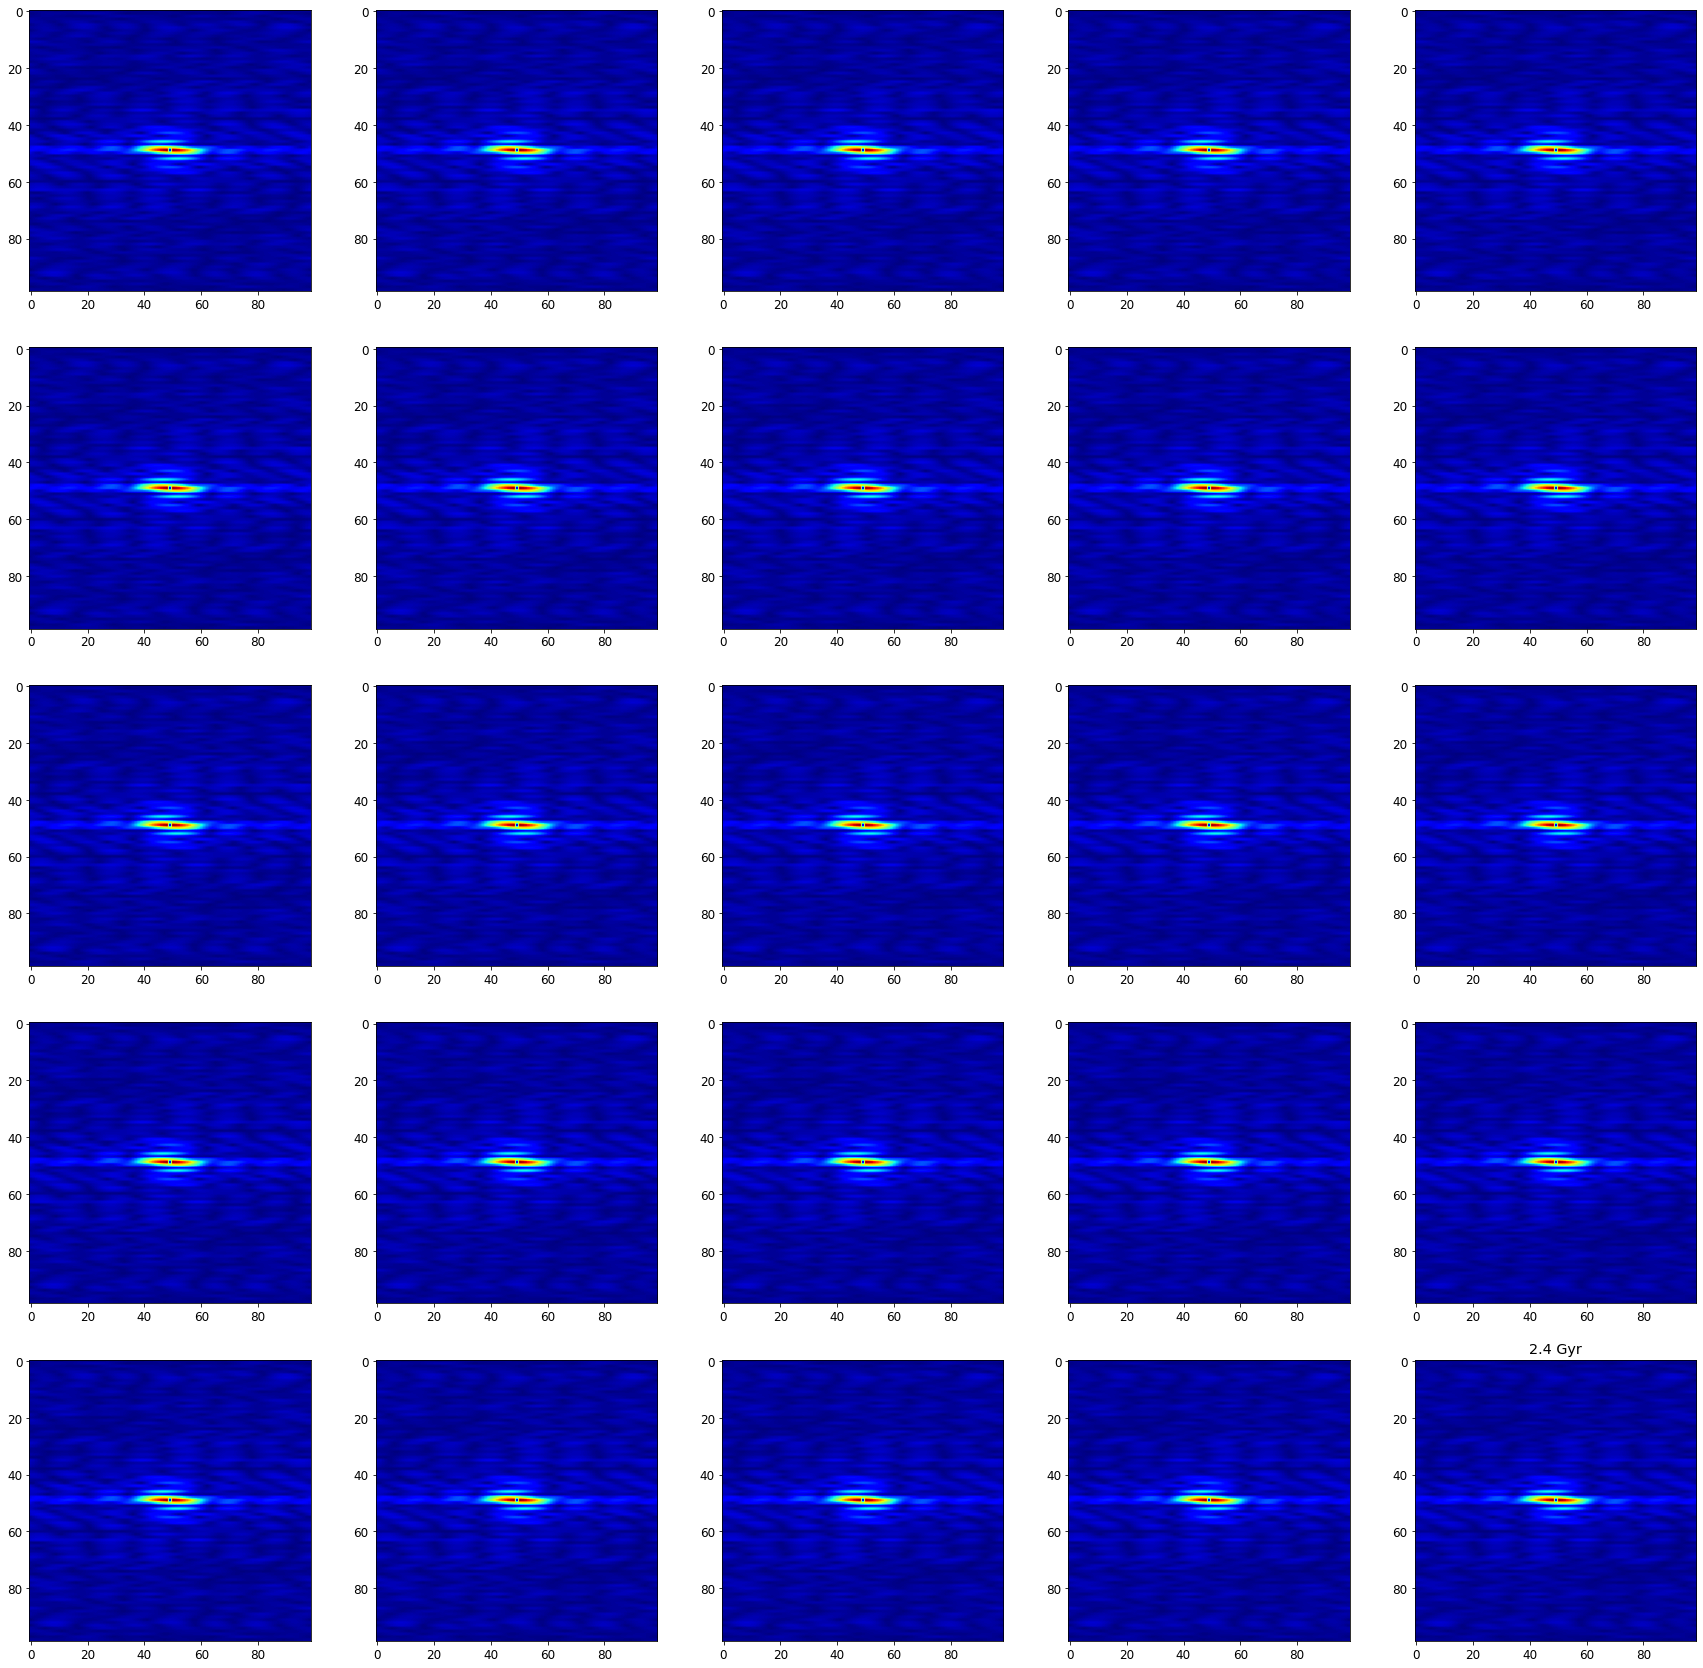

In [445]:

TIME = 1.8
BIAS = -840

def animate(frame, ax=None):
    TIME = frame * 0.1 + 0.001
    plt.title(f"{TIME:.2} Gyr")
   
    XMIN=1200
    XMAX=3500
    x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)

    VRn = VR / Lz
    binsX=np.linspace(np.log10(XMIN+BIAS),np.log10(XMAX+BIAS),100)
    binsY=np.linspace(-np.pi,np.pi,100)
    mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(np.log10(Lz+BIAS), phi, VRn, statistic='mean', bins=[binsX,binsY])    
    #plt.pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10,vmax=10)

    mVR = np.nan_to_num(mVR)
    mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
    #plt.imshow(mVR)
    f = fftshift(fft2(ifftshift(mVR)))
    #col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
    #print(col)
    #plt.imshow(matplotlib.colors.hsv_to_rgb(col))
    if ax is None:
        return plt.imshow(abs(f))
    else:
        f[len(f)//2, len(f)//2] = np.mean(f)
        ax.imshow(abs(f), cmap='jet')

from matplotlib.animation import FuncAnimation
import matplotlib.colors

#fig, ax = plt.subplots()
#anim = FuncAnimation(fig, animate, frames=200, interval=20)

fig, ax = plt.subplots(5,5, figsize=(30,30))
for i in range(25):
    animate(i, ax[i//5][i%5])

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

0.34434517985726343
(45, 49)
(-0.040816326530612235, 0.0)
4.540816326530611 1.5707963267948966


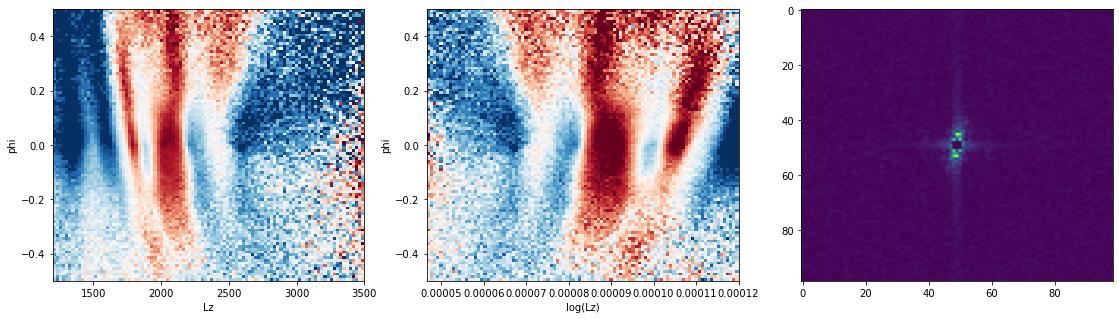

In [8]:
#TIME = 0.8
#XMIN=1200
#XMAX=3500
#x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)

#BIAS = 0
#TIME = 4.5
#XMIN=1000
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
#DATA = False

XMIN=1000
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=np.pi, new=True)
DATA = True

fig, ax = plt.subplots(1, 3, figsize=(19,5))

VRn = VR / Lz
n = -0.1
Lzl = Lz ** ((n-1)/(n+1))
#binsX=np.linspace(1200,3500,100)
binsX=np.linspace(Lzl.min(),Lzl.max(),100)
binsY=np.linspace(-np.pi,np.pi,100)
binsY=np.linspace(-0.5,0.5,100)
binsX=np.linspace(Lzl.min(),0.00012,100)
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(1200,3500,100),binsY])    
ax[0].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10,vmax=10)
ax[0].set_aspect('auto')
ax[0].set_xlabel('Lz')
ax[0].set_ylabel('phi')
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    
ax[1].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10/2500,vmax=10/2500)
ax[1].set_aspect('auto')
ax[1].set_xlabel('log(Lz)')
ax[1].set_ylabel('phi')

mVR = np.nan_to_num(mVR)
mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
#plt.imshow(mVR)
#x1, x2 = np.meshgrid(np.linspace(0, 1, 99), np.linspace(0, 1, 99))
#mVR = 2*np.cos(2*x1*2*np.pi+0.9*np.pi)
#ax[1].imshow(mVR)
f = fftshift(fft2(ifftshift(mVR)))
#col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
#print(col)
#plt.imshow(matplotlib.colors.hsv_to_rgb(col))
f[len(f)//2, len(f)//2] = np.mean(f)
import itertools
for dx,dy in itertools.product([-1,0,1],[-1,0,1]):
    f[len(f)//2+dx, len(f)//2+dy] = np.mean(f)
#ax[2].imshow(abs(f))
ax[2].imshow(abs(f))
#ax[1].imshow(np.sqrt(abs(f)))
ax[2].set_aspect('auto')

maximum = np.unravel_index(np.argmax(abs(f)), f.shape)
maxval = f[maximum]
print((-np.angle(maxval)%(np.pi))/np.pi)
print(maximum)
maximum = (maximum[0]/(len(f)-1)-0.5, maximum[1]/(len(f)-1)-0.5)
print(maximum)
freq = np.linalg.norm(maximum)*len(f) + 0.5
angle = np.arctan2(*maximum)%np.pi
print(freq, angle)


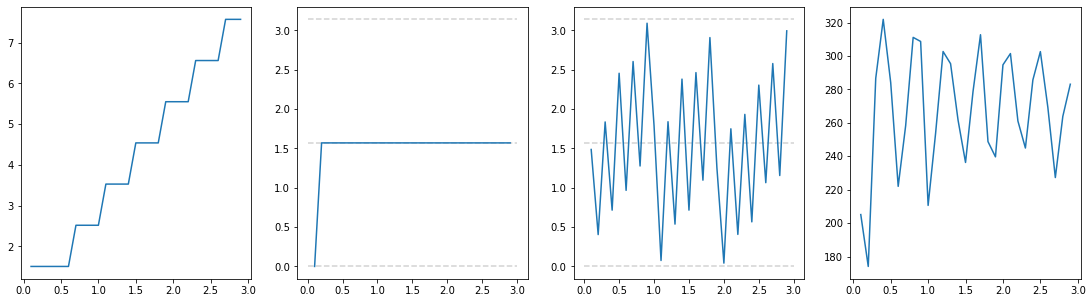

In [16]:
times = np.arange(.1,3.0,.1)
fig, ax = plt.subplots(1, 4, figsize=(19,5))
freqs = []
angles = []
phases = []
amplitudes = []

for time in times:
    XMIN=1200
    XMAX=3500
    x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhotn_10_pn_10', time, xmin=XMIN, xmax=XMAX, phi_range=np.pi)

    Lzl = Lz ** ((n-1)/(n+1))
    VRn = VR / Lz
    #binsX=np.linspace(1200,3500,100)
    #binsX=np.linspace(nx.min(),nx.max(),100)
    #binsY=np.linspace(-np.pi,np.pi,100)
    binsY=np.linspace(-0.5,0.5,100)
    binsX=np.linspace(Lzl.min(),0.00012,100)
    mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    

    mVR = np.nan_to_num(mVR)
    mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
    f = fftshift(fft2(ifftshift(mVR)))
    f[len(f)//2, len(f)//2] = np.mean(f)

    
    maximum = np.unravel_index(np.argmax(abs(f)), f.shape)
    maxval = f[maximum]
    phase = (-np.angle(maxval))%(np.pi)
    amplitude = np.abs(maxval)
    maximum = (maximum[0]/(len(f)-1)-0.5, maximum[1]/(len(f)-1)-0.5)
    freq = np.linalg.norm(maximum)*len(f)+0.5
    angle = np.arctan2(*maximum)%np.pi
    freqs.append(freq)
    angles.append(angle)
    phases.append(phase)
    amplitudes.append(amplitude)
    #print(time, freq, angle)

ax[0].plot(times, freqs)
ax[1].hlines([0,np.pi/2,np.pi],0,3,ls='--',color='lightgrey')
ax[1].plot(times, angles)
ax[2].hlines([0,np.pi/2,np.pi],0,3,ls='--',color='lightgrey')
from scipy.signal import hilbert
ax[2].plot(times, phases)
ax[3].plot(times, amplitudes)

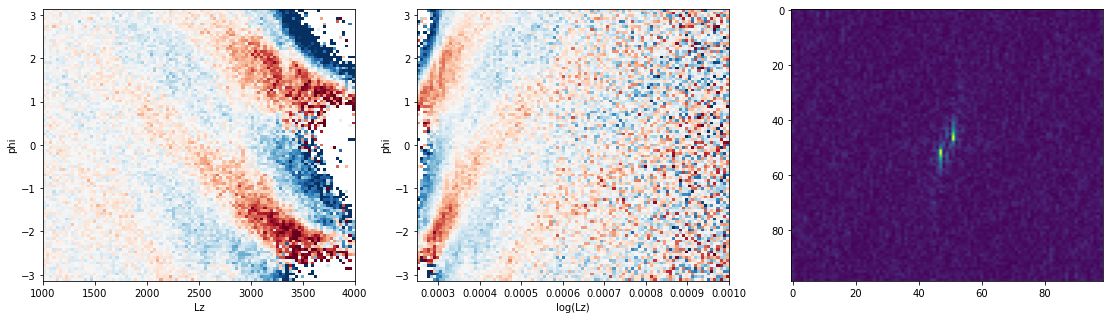

In [4]:
#TIME = 1.5
#BIAS = -840
#XMIN=1200
#XMAX=3500
#x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)

TIME = 2.8
XMIN=1000
XMAX=4000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
phi=-phi
DATA = False


fig, ax = plt.subplots(1, 3, figsize=(19,5))

VRn = VR / Lz
#Lzl = np.log10(Lz+BIAS)
Lzl = 1/Lz
#binsX=np.linspace(1200,3500,100)
#binsX=np.linspace(np.log10(XMIN+BIAS),np.log10(XMAX+BIAS),100)
binsX=np.linspace(1/XMAX,1/XMIN,100)
binsY=np.linspace(-np.pi,np.pi,100)
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(XMIN,XMAX,100),binsY])    
ax[0].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10,vmax=10)
ax[0].set_aspect('auto')
ax[0].set_xlabel('Lz')
ax[0].set_ylabel('phi')
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    
ax[1].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10/2500,vmax=10/2500)
ax[1].set_aspect('auto')
ax[1].set_xlabel('log(Lz)')
ax[1].set_ylabel('phi')

mVR = np.nan_to_num(mVR)
mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
#plt.imshow(mVR)
f = fftshift(fft2(ifftshift(mVR)))
#col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
#print(col)
#plt.imshow(matplotlib.colors.hsv_to_rgb(col))
f[len(f)//2, len(f)//2] = np.mean(f)
#ax[2].imshow(abs(f))
ax[2].imshow(abs(f))
#ax[1].imshow(np.sqrt(abs(f)))
ax[2].set_aspect('auto')


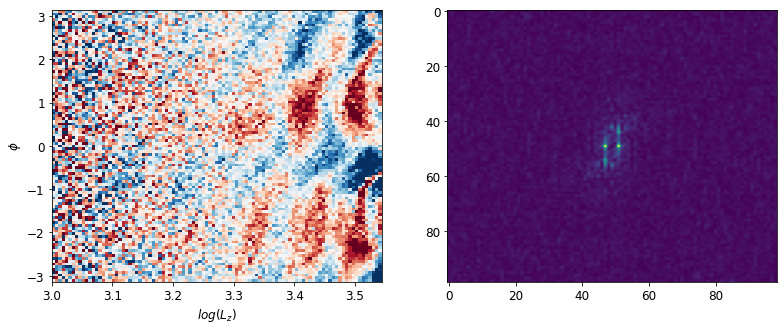

In [885]:

#TIME = 1.5
#BIAS = -840
#XMIN=1200
#XMAX=3500
#x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)

BIAS = 0
TIME = 4.5
XMIN=1000
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
DATA = False


fig, ax = plt.subplots(1, 2, figsize=(13,5))

VRn = VR / Lz
Lzl = np.log10(Lz+BIAS)
#binsX=np.linspace(1200,3500,100)
binsX=np.linspace(np.log10(XMIN+BIAS),np.log10(XMAX+BIAS),100)
binsY=np.linspace(-np.pi,np.pi,100)
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(1200,3500,100),binsY])    
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    
ax[0].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-5/2500,vmax=5/2500)
ax[0].set_aspect('auto')
ax[0].set_xlabel(r'$log(L_z)$')
ax[0].set_ylabel(r'$\phi$')

mVR = np.nan_to_num(mVR)
mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
#plt.imshow(mVR)
f = fftshift(fft2(ifftshift(mVR)))
#col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
#print(col)
#plt.imshow(matplotlib.colors.hsv_to_rgb(col))
f[len(f)//2, len(f)//2] = np.mean(f)
#ax[2].imshow(abs(f))
ax[1].imshow(abs(f))
#ax[1].imshow(np.sqrt(abs(f)))
ax[1].set_aspect('auto')

namef='plots/fourier_2d.png'
plt.savefig(namef, bbox_inches='tight')

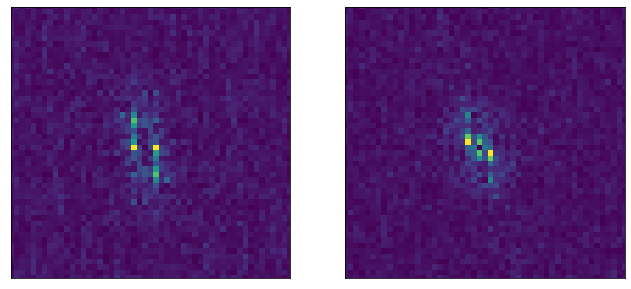

In [12]:
BIAS = 0
TIME = 4.5
XMIN=500
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
DATA = False

fig, ax = plt.subplots(1, 2, figsize=(11,5))

VRn = VR / Lz
#Lzl = 1/Lz
Lzl = Lz
#binsX=np.linspace(1200,3500,100)
binsX=np.linspace(np.min(Lzl), np.max(Lzl), 200)
binsY=np.linspace(-np.pi,np.pi,200)
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(1200,3500,100),binsY])    
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    
#ax[0].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10/2500,vmax=10/2500)
#ax[0].set_aspect('auto')
#ax[0].set_xlabel(r'$log(L_z)$')
#ax[0].set_ylabel(r'$\phi$')

mVR = np.nan_to_num(mVR)
mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
#plt.imshow(mVR)
f = fftshift(fft2(ifftshift(mVR)))
#col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
#print(col)
#plt.imshow(matplotlib.colors.hsv_to_rgb(col))
f[len(f)//2, len(f)//2] = np.mean(f)
#ax[2].imshow(abs(f))
ax[0].imshow(abs(f), cmap='viridis')
#ax[1].imshow(np.sqrt(abs(f)))
ax[0].set_aspect('auto')
ax[0].set_xlim(75,125)
ax[0].set_ylim(75,125)
ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])


BIAS = 0
TIME = 4.8
XMIN=500
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
DATA = False

VRn = VR / Lz
#Lzl = 1/Lz
Lzl = Lz
#binsX=np.linspace(1200,3500,100)
binsX=np.linspace(np.min(Lzl), np.max(Lzl), 200)
binsY=np.linspace(-np.pi,np.pi,200)
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(1200,3500,100),binsY])    
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    
#ax[0].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10/2500,vmax=10/2500)
#ax[0].set_aspect('auto')
#ax[0].set_xlabel(r'$log(L_z)$')
#ax[0].set_ylabel(r'$\phi$')

mVR = np.nan_to_num(mVR)
mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
#plt.imshow(mVR)
f = fftshift(fft2(ifftshift(mVR)))
#col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
#print(col)
#plt.imshow(matplotlib.colors.hsv_to_rgb(col))
f[len(f)//2, len(f)//2] = np.mean(f)
#ax[2].imshow(abs(f))
ax[1].imshow(abs(f), cmap='viridis')
#ax[1].imshow(np.sqrt(abs(f)))
ax[1].set_aspect('auto')
ax[1].set_xlim(75,125)
ax[1].set_ylim(75,125)
ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])

namef='plots/fourier_2d.png'
plt.savefig(namef, bbox_inches='tight')

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5000000000000004
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1
4.2
4.3
4.3999999999999995
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9


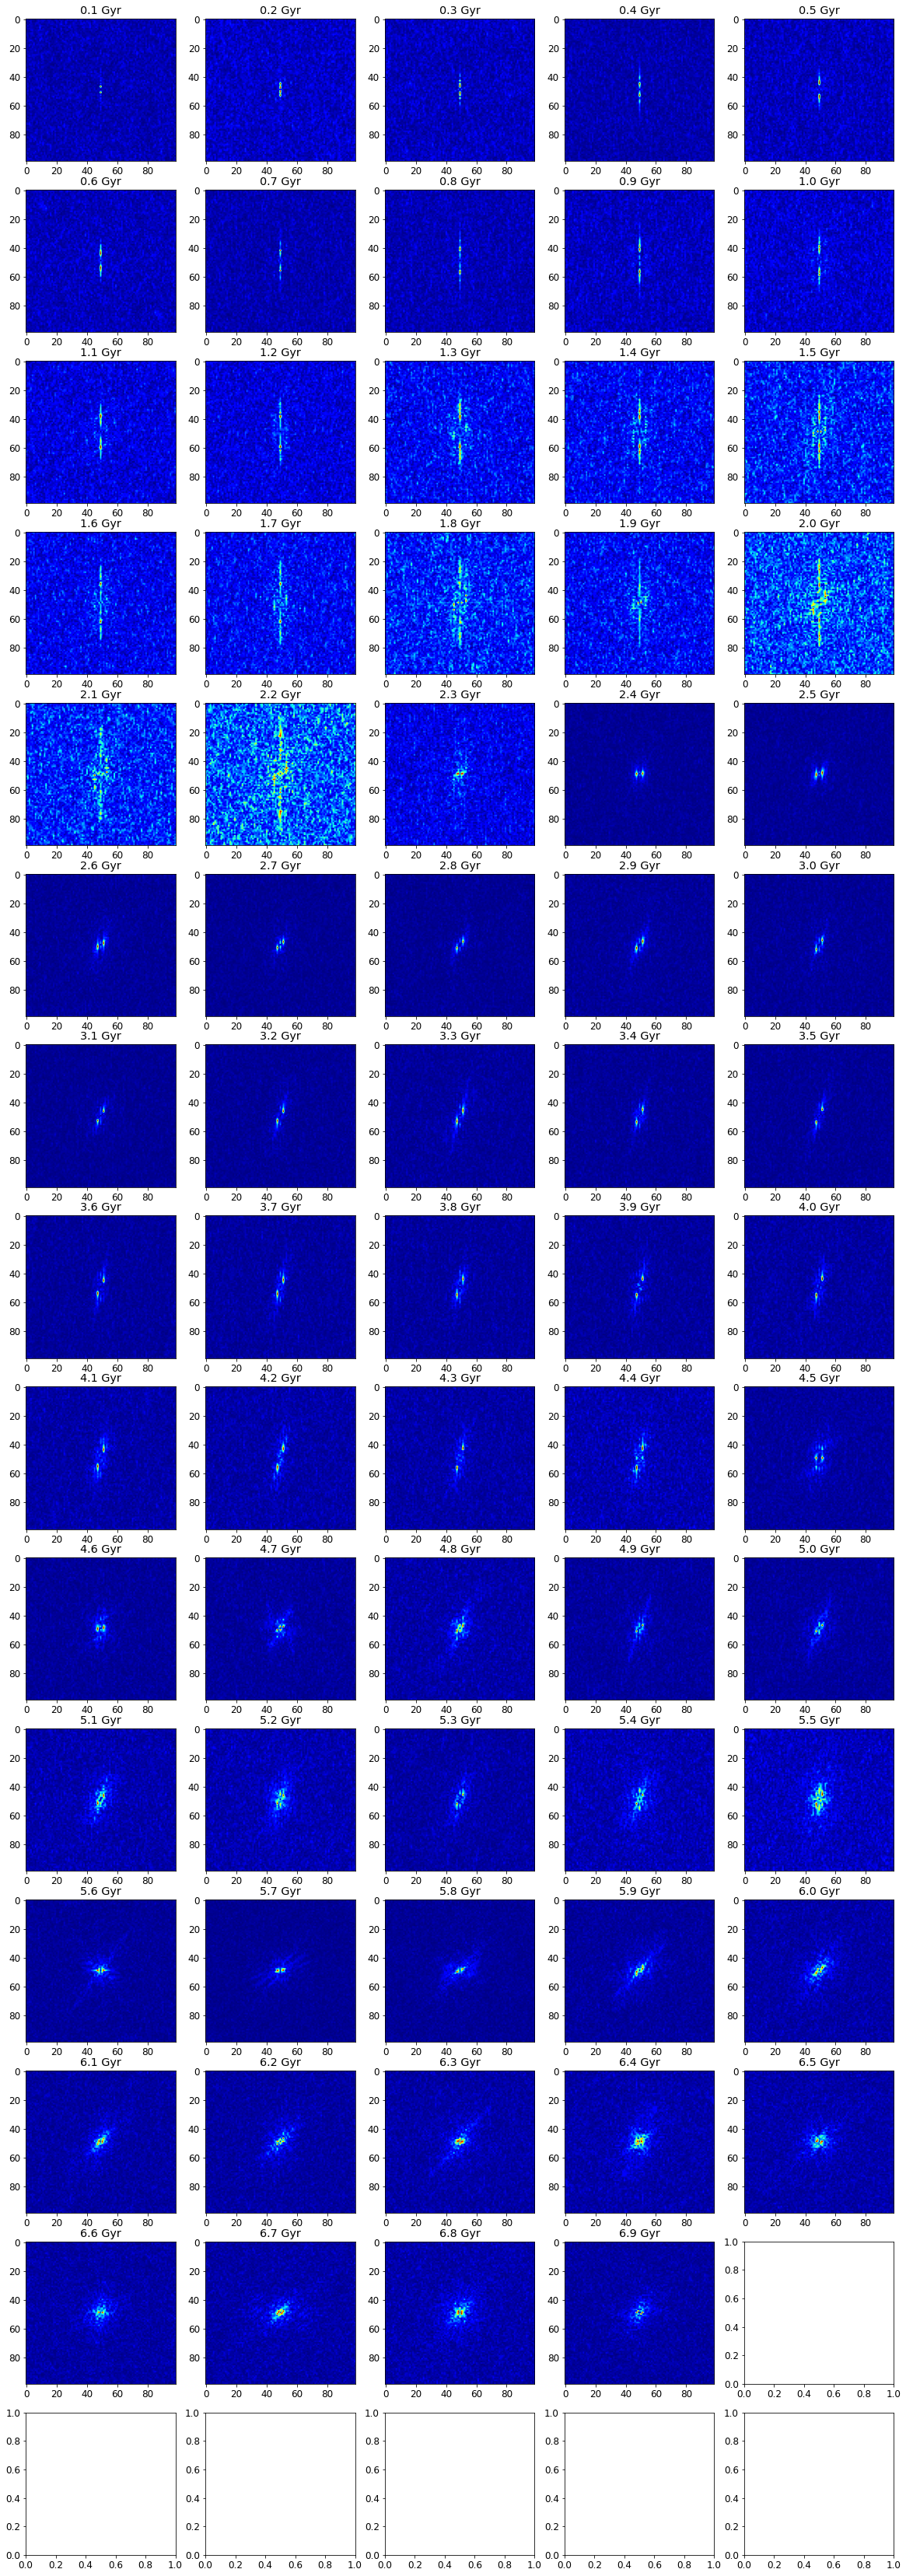

In [459]:
BIAS = 0

times = np.arange(0.1,7.0,0.1)
fig, ax = plt.subplots(15, 5, figsize=(20,60))

for timei, TIME in enumerate(times):
    print(TIME)
    XMIN=1000
    XMAX=4000
    BINSIZE = 10
    x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
    DATA = False

    VRn = VR / Lz
    Lzl = np.log10(Lz+BIAS)
    #binsX=np.linspace(1200,3500,100)
    binsX=np.linspace(np.log10(XMIN+BIAS),np.log10(XMAX+BIAS),100)
    binsY=np.linspace(-np.pi,np.pi,100)
    mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(1200,3500,100),binsY])    
    mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    

    mVR = np.nan_to_num(mVR)
    mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
    #plt.imshow(mVR)
    f = fftshift(fft2(ifftshift(mVR)))
    #col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
    #print(col)
    #plt.imshow(matplotlib.colors.hsv_to_rgb(col))
    f[len(f)//2, len(f)//2] = np.mean(f)
    cax = ax[timei//5][timei%5]
    cax.imshow(abs(f), cmap='jet')
    cax.set_aspect('auto')
    cax.set_title(f'{TIME:.2} Gyr')

Text(0, 0.5, 'phi')

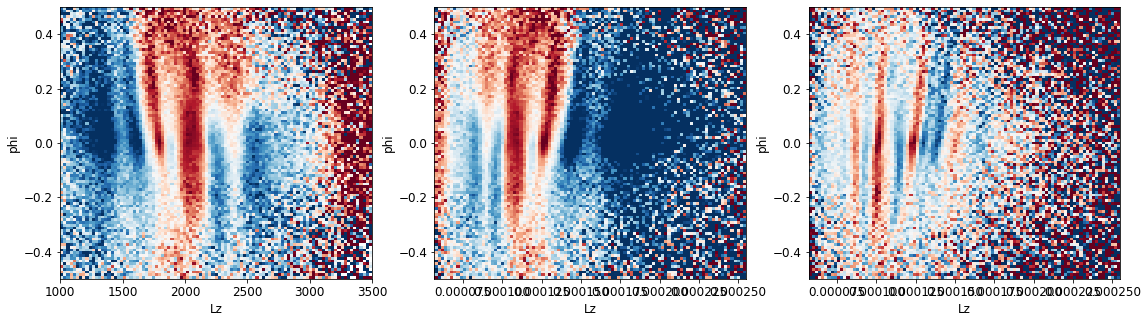

In [566]:
XMIN=1000
XMAX=3500
BINSIZE = 50
BIAS=0
PHI_RANGE = 0.2
PHI_RANGE = 0.5
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=PHI_RANGE)

fig, ax = plt.subplots(1, 3, figsize=(19,5))

VRn = VR / Lz
#Lzl = np.log10(Lz+BIAS)
n = -0.09
Lzl = (1/Lz)**((1-n)/(1+n))
#binsX=np.linspace(1200,3500,100)
#binsX=np.linspace(np.log10(XMIN+BIAS),np.log10(XMAX+BIAS),100)
binsX=np.linspace(1/XMIN,1/XMAX,100)
binsY=np.linspace(-PHI_RANGE,PHI_RANGE,100)
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(XMIN,XMAX,100),binsY])    
ax[0].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10,vmax=10)
ax[0].set_aspect('auto')
ax[0].set_xlabel('Lz')
ax[0].set_ylabel('phi')
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VR/Lz, statistic='mean', bins=[np.linspace((1/XMAX)**((1-n)/(1+n)),(1/XMIN)**((1-n)/(1+n)),100),binsY])    
ax[1].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10/2000,vmax=10/2000)
ax[1].set_aspect('auto')
ax[1].set_xlabel('Lz')
ax[1].set_ylabel('phi')
mVR = np.gradient(mVR, axis=0)
ax[2].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10/4000,vmax=10/4000)
ax[2].set_aspect('auto')
ax[2].set_xlabel('Lz')
ax[2].set_ylabel('phi')

#mVR = np.nan_to_num(mVR)
#mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
##plt.imshow(mVR)
#f = fftshift(fft2(ifftshift(mVR)))
##col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
##print(col)
##plt.imshow(matplotlib.colors.hsv_to_rgb(col))
#f[len(f)//2, len(f)//2] = np.mean(f)
##ax[2].imshow(abs(f))
#ax[2].imshow(abs(f))
##ax[1].imshow(np.sqrt(abs(f)))
#ax[2].set_aspect('auto')

In [197]:
VR,Vphi,VZ,x,y,Z,R,phi=np.array((oo['VR'],oo['Vphi'],oo['VZ'],oo['X'],oo['Y'],oo['Z'],oo['R'],oo['phi']))
Lz=-oo['Vphi']*oo['R']
phi=-np.deg2rad(phi)
Vphi=-Vphi

PHI_RANGE = 0.2
indphi = abs(phi) < PHI_RANGE
x,y,VR,Vphi,R,Lz,phi=x[indphi],y[indphi],VR[indphi],Vphi[indphi],R[indphi],Lz[indphi],phi[indphi]

fig, ax = plt.subplots(1, 3, figsize=(19,5))

VRn = VR / Lz
BIAS = -800
Lzl = np.log10(Lz+BIAS)
#binsX=np.linspace(1200,3500,100)
binsX=np.linspace(np.log10(1500+BIAS),np.log10(3000+BIAS),100)
binsY=np.linspace(-PHI_RANGE,PHI_RANGE,100)
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lz, phi, VR, statistic='mean', bins=[np.linspace(1000,3000,100),binsY])    
ax[0].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10,vmax=10)
ax[0].set_aspect('auto')
ax[0].set_xlabel('Lz')
ax[0].set_ylabel('phi')
mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(Lzl, phi, VRn, statistic='mean', bins=[binsX,binsY])    
ax[1].pcolormesh(xedge, yedge, mVR.T, cmap='RdBu',vmin=-10/2500,vmax=10/2500)
ax[1].set_aspect('auto')
ax[1].set_xlabel('log(Lz)')
ax[1].set_ylabel('phi')

mVR = np.nan_to_num(mVR)
mVR = (mVR - mVR.mean()) / (mVR.max() - mVR.min())
#plt.imshow(mVR)
f = fftshift(fft2(ifftshift(mVR)))
#col = np.stack([(np.angle(f)+np.pi)/(2*np.pi), abs(f)/abs(f).max(), np.ones(f.shape)], axis=-1)
#print(col)
#plt.imshow(matplotlib.colors.hsv_to_rgb(col))
f[len(f)//2, len(f)//2] = np.mean(f)
ax[2].imshow(abs(f))
#ax[2].imshow(np.log10(abs(f)))
ax[2].set_aspect('auto')

NameError: name 'oo' is not defined

['R', 'vrot', 'stdev']
['7.289', '240.1', '4.1']
['8.018', '239.0', '4.4']
['8.82', '236.7', '5.4']


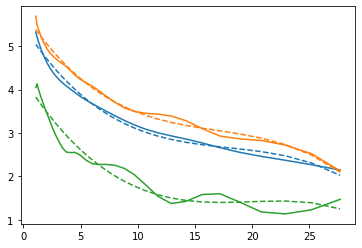

In [369]:
import csv

R = []
vrot = []
vrotmax = []
vrotmin = []
with open('vrot_sofue.csv') as f:
    reader = csv.reader(f)
    print(next(reader))
    for l in reader:
        if float(l[0]) < 1 or float(l[0]) > 30:
            continue
        if 7 < float(l[0]) < 9:
            print(l)
        R.append(float(l[0]))
        vrot.append(float(l[1]))
        vrotmax.append(float(l[1]) + float(l[2]))
        vrotmin.append(float(l[1]) - float(l[2]))
R, vr, vrotmax, vrotmin = (np.array(i) for i in (R, vrot, vrotmax, vrotmin))
        

#plt.plot(R, vr)

w = vr/R
plt.plot(R, np.log(w))
pol = np.poly1d(np.polyfit(R, np.log(w), 3))
plt.plot(R, pol(R), ls='--', c='C0')

dR = np.gradient(R)
dw2 = np.gradient(w**2)
k = np.sqrt(R * dw2/dR + 4 * w**2)
plt.plot(R, np.log(k))
pol2 = np.poly1d(np.polyfit(R, np.log(k), 3))
plt.plot(R, pol2(R), ls='--', c='C1')
freq = w - k/2
plt.plot(R, np.log(freq))
#pol = np.poly1d(np.polyfit(R, np.log(freq), 3))
ffreq = np.exp(pol(R)) - np.exp(pol2(R))/2
plt.plot(R, np.log(ffreq), ls='--', c='C2')

#plt.xlim(0.1,15)
#plt.ylim(0,500)

rfreq = R


['R', 'vrot', 'stdev']
['7.289', '240.1', '4.1']
['8.018', '239.0', '4.4']
['8.82', '236.7', '5.4']


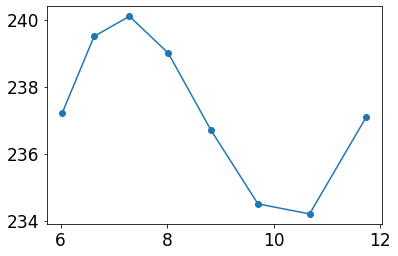

In [54]:
import csv

R = []
vrot = []
vrotmax = []
vrotmin = []
with open('vrot_sofue.csv') as f:
    reader = csv.reader(f)
    print(next(reader))
    for line in reader:
        if float(line[0]) < 5.5 or float(line[0]) > 12:
            continue
        if 7 < float(line[0]) < 9:
            print(line)
        R.append(float(line[0]))
        vrot.append(float(line[1]))
        vrotmax.append(float(line[1]) + float(line[2]))
        vrotmin.append(float(line[1]) - float(line[2]))
R, vr, vrotmax, vrotmin = (np.array(i) for i in (R, vrot, vrotmax, vrotmin))
rr = R

import astropy.units as u
ft=(1*u.km/u.second/u.kpc).to(1./u.Gyr).value

plt.plot(R,vr)
plt.scatter(R,vr)

def plot_segmented(rs, phi, c='C0'):
    nphi = (phi+np.pi)%(2*np.pi)-np.pi
    breaks = [0]
    for i in range(len(nphi)-1):
        if nphi[i] < nphi[i+1] and nphi[i] < 0 and nphi[i+1] > 0:
            breaks.append(i+1)
    breaks.append(len(rs))
    for ll, ul in zip(breaks[:-1], breaks[1:]):
        plt.plot(rs[ll:ul], nphi[ll:ul],c=c)

-0.030006426637438157


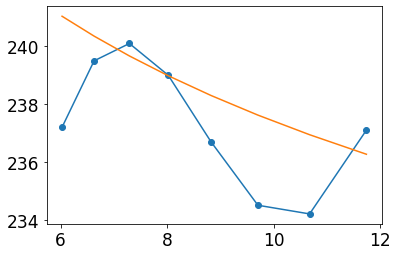

In [55]:
V0 = 239
R0 = 8
def vfun(R, n):
    return V0 * (R/R0)**n

vrinterp = interpolate.interp1d(rr, vr)
optn = optimize.curve_fit(vfun, rr, vr)[0][0]
print(optn)

plt.plot(rr,vr)
plt.scatter(rr,vr)
plt.plot(rr, vfun(rr,optn))

-0.06431559252273432


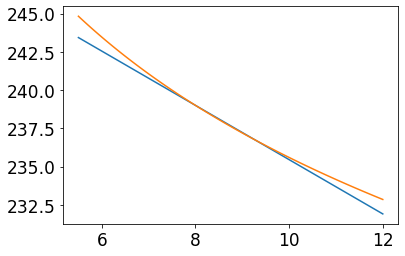

In [56]:
rr2 = np.linspace(5.5,12,100)
vrn = (V0/229)*(229-1.7*(rr2-R0))
plt.plot(rr2,vrn)


def vfun(R, n):
    return V0 * (R/R0)**n

optn = optimize.curve_fit(vfun, rr2, vrn)[0][0]
print(optn)

plt.plot(rr2, vfun(rr2,optn))

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

[ 11  50  79 102 140]
[ 2.4119859  -4.63938448]


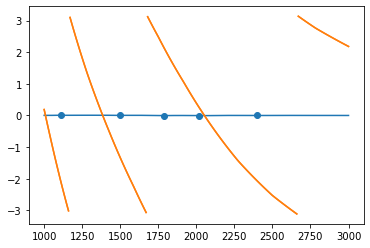

In [410]:
XMIN=1000
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = True

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)

plt.plot(nx,ny)

from scipy.signal import find_peaks
peaks, _ = find_peaks(-ny, prominence=1e-3, distance=10)
print(peaks)
plt.scatter(nx[peaks], ny[peaks])

#evenpeaks = peaks[::2]
#oddpeaks = peaks[1::2]
#plt.plot(nx[evenpeaks], 2*np.pi*np.arange(1, len(evenpeaks)+1))
#plt.plot(nx[oddpeaks], 2*np.pi*np.arange(1, len(oddpeaks)+1))


def an_R(phi, t, n):
    V0 = 240
    R0 = 8
    phi0 = 0
    pn = 1 - 0.5*np.sqrt(2**(n+1))
    return V0/(R0**n) * ((pn*t)/(phi-phi0))**(1/(1-n))

def an_phi(R, t, n, V0=240, phi0=0):
    #V0 = 240
    R0 = 8
    pn = 1 - 0.5*np.sqrt(2**(n+1))
    return phi0 + pn * t * (R * R0**n / V0)**(n-1)

LzR = rr*vr
rfromlz = interpolate.interp1d(LzR, rr)

def an_phi_mod(Lz, t, n, phi0):
    r = rfromlz(Lz)
    return an_phi(r,t,n,phi0=phi0)

fun = lambda Lz, t, phi0: an_phi_mod(Lz, t, optn, phi0)
optpar = optimize.curve_fit(fun, nx[peaks], np.pi*np.arange(len(peaks)+1,1,-1))[0]
#optpar = optimize.curve_fit(fun, nx[peaks], np.pi*np.arange(len(peaks)+1,1,-1),bounds=([0,-np.inf],[np.inf,np.inf]))[0]
#fun = lambda Lz, t, phi0, n: an_phi_mod(Lz, t, n, phi0)
#optpar = optimize.curve_fit(fun, nx[peaks], np.pi*np.arange(len(peaks)+1,1,-1),bounds=([0.0,-0.2,-np.inf],[5.0,0.2,np.inf]))[0]
#optpar = optimize.curve_fit(fun, nx[peaks], np.pi*np.arange(len(peaks)+1,1,-1))[0]
print(optpar)
#plt.plot(nx, fun(nx, *optpar))
#plt.plot(nx, an_phi(nx,1,0))
optpar2 = optpar
optpar2[1] += np.pi
plot_segmented(nx, fun(nx, *optpar), c='C1')
plot_segmented(nx, fun(nx, *optpar2), c='C1')

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

[  2.31972433 -10.13039902]


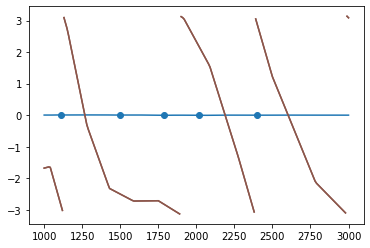

In [411]:

XMIN=1000
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = True

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)

plt.plot(nx,ny)

from scipy.signal import find_peaks
peaks, _ = find_peaks(-ny, prominence=1e-3, distance=10)
plt.scatter(nx[peaks], ny[peaks])

evenpeaks = peaks[::2]
oddpeaks = peaks[1::2]
#plt.plot(nx[evenpeaks], 2*np.pi*np.arange(1, len(evenpeaks)+1))
#plt.plot(nx[oddpeaks], 2*np.pi*np.arange(1, len(oddpeaks)+1))


#vcs_interp = np.poly1d(np.polyfit(rr, vr, 15))
#vcs_interp = interpolate.interp1d(R, vr, 'quadratic')
#plt.plot(rr, vcs_interp(rr), ls='--', c='C0')


w = vr/rr
dR = np.gradient(rr)
dw2 = np.gradient(w**2)
k = np.sqrt(rr * dw2/dR + 4 * w**2)
freq = ft*(w - k/2)
#plt.plot(rr, freq)
ffreq = interpolate.interp1d(rr, freq, 'linear')
def phiR(R, t, phi0=0):
    return phi0 + ffreq(R)*t

#rr = np.arange(2,25,0.5)
#n = -0.1
#vr = V0 * (rr/R0)**n
#w = vr/rr
#dR = np.gradient(rr)
#dw2 = np.gradient(w**2)
#k = np.sqrt(rr * dw2/dR + 4 * w**2)
#freq = ft*(w - k/2)

#rr = np.arange(3,25,0.5)
#n = 0.04
#vr = V0 * (rr/R0)**n
#w = vr/rr
#dR = np.gradient(rr)
#dw2 = np.gradient(w**2)
#k = np.sqrt(rr * dw2/dR + 4 * w**2)
#freq = ft*(w - k/2)

#rs = np.linspace(4,18,100)
#vcs = vcs_interp(rs)
#w = vcs/rs
##plt.plot(rs, w)
#dR = np.gradient(rs)
#dw2 = np.gradient(w**2)
#k = np.sqrt(rs * dw2/dR + 4 * w**2)
##plt.plot(rs, k)
#freq = w - k/2
##plt.plot(rs, freq)
#ffreq = interpolate.interp1d(rs, freq, 'linear')
#def phiR(R, t, phi0=0):
#    return phi0 + ffreq(R)*t

#plt.plot(np.arange(4,18,0.1), ffreq(np.arange(4,18,0.1)))
#plot_segmented(np.arange(4,18,0.1), phiR(np.arange(4,18,0.1), 2))

LzR = rr*vr
rfromlz = interpolate.interp1d(LzR, rr)

def phiR_mod(Lz, t, phi0):
    r = rfromlz(Lz)
    return phiR(r,t,phi0=phi0)

optpar = optimize.curve_fit(phiR_mod, nx[peaks], np.pi*np.arange(len(peaks)+1,1,-1),bounds=([0,-np.inf],[np.inf,np.inf]))[0]
print(optpar)
optpar2 = optpar
optpar2[1] += np.pi
plot_segmented(nx, phiR_mod(nx, *optpar), c=f'C{i+1}')
plot_segmented(nx, phiR_mod(nx, *optpar2), c=f'C{i+1}')
#for i, time in enumerate(np.arange(1,4,1)):
#    optpar = [time,-10]
#    optpar2 = optpar
#    optpar2[1] += np.pi
#    plot_segmented(nx, phiR_mod(nx, *optpar), c=f'C{i+1}')
#    plot_segmented(nx, phiR_mod(nx, *optpar2), c=f'C{i+1}')
#    #plt.plot(nx, fun(nx,*optpar), c=f'C{i+1}')

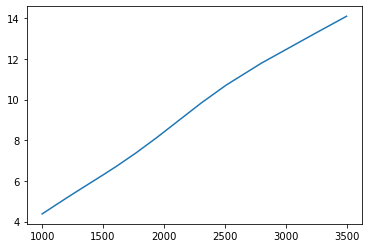

In [82]:

LzR = rr*vr
rfromlz = interpolate.interp1d(LzR, rr)
plt.plot(np.arange(1000,3500,1), rfromlz(np.arange(1000,3500,1)))

[0.00885839 0.09504666]


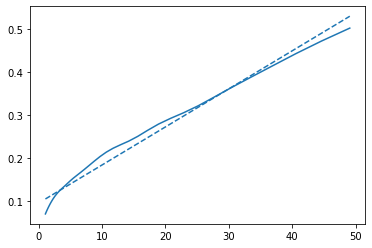

In [384]:

import csv

R = []
vrot = []
vrotmax = []
vrotmin = []
with open('vrot_sofue.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for l in reader:
        if float(l[0]) < 1 or float(l[0]) > 50:
            continue
        R.append(float(l[0]))
        vrot.append(float(l[1]))
        vrotmax.append(float(l[1]) + float(l[2]))
        vrotmin.append(float(l[1]) - float(l[2]))
R, vr, vrotmax, vrotmin = (np.array(i) for i in (R, vrot, vrotmax, vrotmin))
        

#plt.plot(R, vr)

w = np.sqrt(vr/R)
plt.plot(R, 1/w)
coeff = np.polyfit(R, 1/w, 1)
print(coeff)
pol = np.poly1d(coeff)
plt.plot(R, pol(R), ls='--', c='C0')

dR = np.gradient(R)
dw2 = np.gradient(w**2)
k = np.sqrt(R * dw2/dR + 4 * w**2)
#pol2 = np.poly1d(np.polyfit(R, 1/k, 8))
#def pol2g(R, c0, c1):
#    return R * (-2)*c1*(c1*R+c0)**(-3) + 4 / (c1*R+c0)**2
#def pol2g(R, c0, c1):
#    return R * (-2)*c1 / (c1*R+c0)**3 + 4 / (c1*R+c0)**2
#coeff2 = optimize.curve_fit(pol2g, R, k**2)[0]
#print(coeff2)
#pol2 = lambda R: np.sqrt(pol2g(R, coeff2[0], coeff2[1]))
#plt.plot(R, pol2(R), ls='--', c='C1')
#plt.plot(R, k)
#freq = w - k/2
#plt.plot(R, freq)
#ffreq = 1/pol(R) - (pol2(R))/2
#def freqR(R):
#    return 1/pol(R) - pol2(R)/2
#plt.plot(R, ffreq, ls='--', c='C2')
#print(R)
#print(ffreq)
#
#plt.xlim(0.1,15)
##plt.ylim(0,500)
#
rfreq = R

In [5]:
rs = np.linspace(4,16,100)
vcs_interp = interpolate.interp1d(rfreq, vr, 'linear')
vcs = vcs_interp(rs)
plt.plot(rs, np.sqrt(vcs/rs))

NameError: name 'rfreq' is not defined

(-20.0, 20.0)

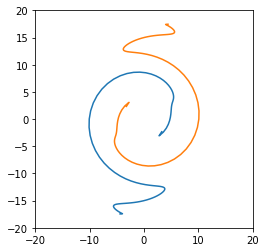

In [371]:
#plt.plot(R, vr)
#plt.scatter(R, vr)
vcs_interp = np.poly1d(np.polyfit(R, vr, 15))
#vcs_interp = interpolate.interp1d(R, vr, 'quadratic')
#plt.plot(R, vcs_interp(R), ls='--', c='C0')

rs = np.linspace(4,18,100)
vcs = vcs_interp(rs)
w = vcs/rs
#plt.plot(rs, w)
dR = np.gradient(rs)
dw2 = np.gradient(w**2)
k = np.sqrt(rs * dw2/dR + 4 * w**2)
#plt.plot(rs, k)
freq = w - k/2
#plt.plot(rs, freq)
ffreq = interpolate.interp1d(rs, freq, 'linear')
def phiR(R, t):
    return ffreq(R)*t
#plt.plot(rs, phiR(rs, 0.5))

xl = []
yl = []
xl2 = []
yl2 = []
t = .7
for r in rs:
    xl.append(r*np.sin(phiR(r,t)))
    yl.append(r*np.cos(phiR(r,t)))
    xl2.append(r*np.sin(phiR(r,t)+np.pi))
    yl2.append(r*np.cos(phiR(r,t)+np.pi))
plt.plot(xl,yl)
plt.plot(xl2,yl2)
plt.axis('square')
plt.xlim(-20,20)
plt.ylim(-20,20)

#XMIN=1000
#XMAX=3000
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = True

/tmp/ipykernel_4655/1122758272.py:16: RuntimeWarning: overflow encountered in power
  return phi0 + pn * t * (R * R0**n / V0)**(n-1)

0.019261646738759162


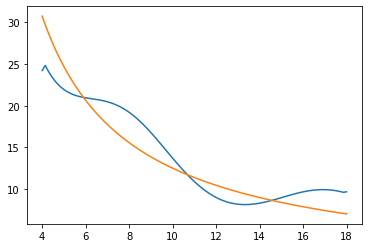

In [372]:
T = 2.0
plt.plot(rs, phiR(rs, T))

def an_R(phi, t, n):
    V0 = 240
    R0 = 8
    phi0 = 0
    pn = 1 - 0.5*np.sqrt(2**(n+1))
    return V0/(R0**n) * ((pn*t)/(phi-phi0))**(1/(1-n))

def an_phi(R, t, n, V0=240):
    #V0 = 240
    R0 = 8
    phi0 = 0
    pn = 1 - 0.5*np.sqrt(2**(n+1))
    return phi0 + pn * t * (R * R0**n / V0)**(n-1)

#lsphi = np.linspace(3,10,100)
#plt.plot(an_R(lsphi, 0.8, 0.01), lsphi)
#plt.plot(rs, an_phi(rs, T, 0))

ofn = lambda r, n: an_phi(r,T,n)
optn = optimize.curve_fit(ofn, rs, phiR(rs,T))[0][0]
print(optn)
plt.plot(rs, an_phi(rs, T, optn))

/tmp/ipykernel_4655/1122758272.py:16: RuntimeWarning: overflow encountered in power
  return phi0 + pn * t * (R * R0**n / V0)**(n-1)



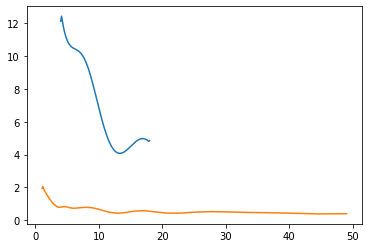

In [385]:
optn = optimize.curve_fit(ofn, rs, phiR(rs,T))[0][0]
plt.plot(rs, ffreq(rs))
plt.plot(rfreq, w-k/2)

(-20.0, 20.0)

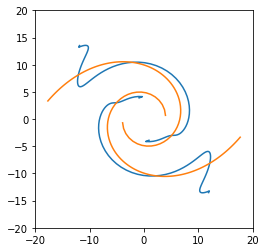

In [373]:

xl = []
yl = []
xl2 = []
yl2 = []
t = .5
for r in rs:
    xl.append(r*np.sin(phiR(r,t)))
    yl.append(r*np.cos(phiR(r,t)))
    xl2.append(r*np.sin(phiR(r,t)+np.pi))
    yl2.append(r*np.cos(phiR(r,t)+np.pi))
plt.plot(xl,yl,c='C0')
plt.plot(xl2,yl2,c='C0')
plt.axis('square')
plt.xlim(-20,20)
plt.ylim(-20,20)

xl = []
yl = []
xl2 = []
yl2 = []
for r in rs:
    ph = an_phi(r,t,optn)
    xl.append(r*np.sin(ph))
    yl.append(r*np.cos(ph))
    xl2.append(r*np.sin(ph+np.pi))
    yl2.append(r*np.cos(ph+np.pi))
plt.plot(xl,yl,c='C1')
plt.plot(xl2,yl2,c='C1')
plt.axis('square')
plt.xlim(-20,20)
plt.ylim(-20,20)

In [9]:
T = 1.6
PHI0 = 0
rs = np.linspace(4,18,200)
vcs = vcs_interp(rs)
        
#plt.plot(rs, nphi)
plot_segmented(rs*vcs, phiR(rs, T)+PHI0, c='C0')
plot_segmented(rs*vcs, phiR(rs, T)+PHI0+np.pi, c='C0')
plot_segmented(rs*vcs, an_phi(rs, T, optn)+PHI0, c='C1')
plot_segmented(rs*vcs, an_phi(rs, T, optn)+PHI0+np.pi, c='C1')
plt.ylim(-np.pi, np.pi)

NameError: name 'vcs_interp' is not defined

(-3.141592653589793, 3.141592653589793)

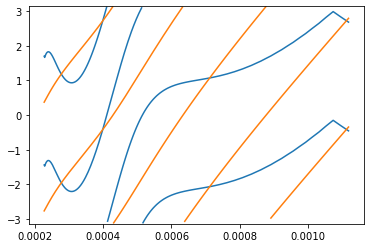

In [380]:

T = 1.0
PHI0 = 0
rs = np.linspace(4,18,200)
vcs = vcs_interp(rs)
def plot_segmented(rs, phi, c='C0'):
    nphi = (phi+np.pi)%(2*np.pi)-np.pi
    breaks = [0]
    for i in range(len(nphi)-1):
        if nphi[i] < nphi[i+1] and nphi[i] < 0 and nphi[i+1] > 0:
            breaks.append(i+1)
    breaks.append(len(rs))
    for ll, ul in zip(breaks[:-1], breaks[1:]):
        plt.plot(rs[ll:ul], nphi[ll:ul],c=c)
        
#plt.plot(rs, nphi)
plot_segmented(1/(rs*vcs), phiR(rs, T)+PHI0, c='C0')
plot_segmented(1/(rs*vcs), phiR(rs, T)+PHI0+np.pi, c='C0')
plot_segmented(1/(rs*vcs), an_phi(rs, T, optn)+PHI0, c='C1')
plot_segmented(1/(rs*vcs), an_phi(rs, T, optn)+PHI0+np.pi, c='C1')
plt.ylim(-np.pi, np.pi)

(5, 3)
22
30
30


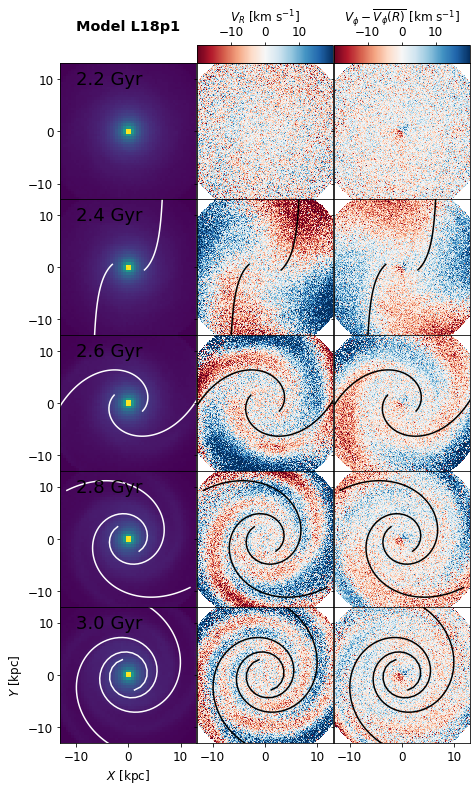

In [36]:
plt.rcParams['font.size'] = 12

ti=22
tf=30
nrows=tf-ti+1
times=[23,24,23+5,23+10]

times=np.arange(22,32,2)
lab='3a'
label='Model L18p1'
#times=np.arange(44,53,2)
#lab='3b'
#label='Model L18p2'
#times=np.arange(55,60,1)
#lab='3c'
#label='Model L18p3'
#times=np.arange(60,65,1)
#lab='3d'
#label='Model L18p45'

#times=np.arange(1,69,1)
#lab='3d'
#label='Model L18p45'

nrows=len(times)
ncols=3
fig = plt.figure(constrained_layout=False,figsize=(ncols*2.45,nrows*2.5))
gs = fig.add_gridspec(nrows,ncols, hspace=0., wspace=0.)
ax = gs.subplots(sharex=True,sharey=True)
print(np.shape(ax))
    

#for t in (range(ti,tf+1)):
for t,i in zip(times,range(len(times))):
    time=0.10*t #Gyr
    if t==ti:print(t)
    if t % 10 == 0:
            print(t)
    if t==tf:print(t)
        
    #i=t-ti
    Rmax=16.
    snap=str(int(time*100)) if time>=1 else '0'+str(int(time*100))
    df = Table.read('MW_Sgr/disk'+snap+'.fits', format='fits').to_pandas()
    df['X'],df['Y'],df['Z'],df['VX'],df['VY'],df['VZ']=cyl2cart(df['R'],df['phi'],df['Z'],df['VR'],df['Vphi'],df['VZ'])
    ind=df['R']<Rmax
    df=df[ind]    
    x,y,z,VR,Vphi,VZ,R,phi=df['X'],df['Y'],df['Z'],df['VR'],df['Vphi'],df['VZ'],df['R'],df['phi']
    Vphi=Vphi*-1.

    bins=100
    Xmax=15.
    DX=0.1
    binsX=np.arange(-1.*Xmax,Xmax+DX,DX)
    binsY=binsX
    binsR=np.arange(0.,Rmax+DX,DX)
    mVR,xedge,yedge,binnumber=stats.binned_statistic_2d(x,y,VR, statistic='mean', bins=[binsX,binsY])    
    mVphi,xedge,yedge,binnumber=stats.binned_statistic_2d(x,y,Vphi, statistic='mean', bins=[binsX,binsY])

 

   #fractional change in Vphi with respect to average in that radius
    binsR=np.arange(0.,Rmax+DX,DX)
    m2,redges0,binnumber=stats.binned_statistic(R,Vphi,bins=[binsR], statistic='mean')
    rcenter0= redges0[1:] - DX/2.
    for ii in range(len(xedge)-1):
        for jj in range(len(yedge)-1):
            rr=np.sqrt((xedge[ii].T)**2.+(yedge[jj])**2.)
            idx = (np.abs(rcenter0 - rr)).argmin()
            mVphi[ii,jj]=(mVphi[ii,jj]-m2[idx])
  


    DX=0.5
    #DX=1.
    binsX=np.arange(-1.*Xmax,Xmax+DX,DX)
    binsR=np.arange(0.,Rmax+DX,DX)
    binsY=binsX
    #ax[i,0].hist2d(x,y, bins=[binsX,binsY])
    hist, bin_edges = np.histogram(R,bins=binsR,density=True)
    norm=1./np.sqrt(hist)
    indw=np.digitize(R,bins=binsR)-1
    weights=norm[indw]
    h0,xedges,yedges=np.histogram2d(x,y,bins=[binsX,binsY],weights=weights)
    h5=gaussian_filter(h0, 1)#, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)[source]¶
    h10=gaussian_filter(h0, 4)#, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)[source]¶
    h=h0-h10
    h=h0/h10-1. 
    #h=h5/h10-1. 
    im0=ax[i,0].pcolormesh(xedges, yedges, h0.T)#,norm=mcolors.LogNorm())#,norm=mcolors.PowerNorm(0.6)

    
    #ax[i,0].scatter(x,y,s=0.01)
    #ax[i,0].set_title(str(time))
    ax[i,0].text(-10., 9, str(np.round(time,1))+' Gyr',color='k',fontsize=18.)


    im1 = ax[i,1].pcolormesh(xedge,yedge, mVR.T, cmap='RdBu',vmin=-20,vmax=20)#,norm=mcolors.PowerNorm(nn), cmap=mycolormap)

    im2 = ax[i,2].pcolormesh(xedge,yedge, mVphi.T, cmap='RdBu',vmin=-20,vmax=20)#,norm=mcolors.PowerNorm(nn), cmap=mycolormap)
    
    for jj in range(3):
        ax[i,jj].set_xlim(-13,13)
        ax[i,jj].set_ylim(-13,13)
        ax[i,jj].set_aspect('equal')
    ax[nrows-1,0].set_xlabel('$X$ [kpc]')
    ax[nrows-1,0].set_ylabel('$Y$ [kpc]')

    ax[0,0].set_title(label, y=1.2,fontweight='bold')
    #ind=abs(phi)<0.3
    #h,xe,ye,im=ax[i,3].hist2d(R[ind],Vphi[ind], bins=bins)
    #ax[i,3].set_xlim(4.5,14)
    #ax[i,3].set_ylim(195,205)
    
plt.draw()
p0 = ax[0,0].get_position().get_points().flatten()
p1 = ax[0,1].get_position().get_points().flatten()
p2 = ax[0,2].get_position().get_points().flatten()
#ax_cbar = fig.add_axes([p0[0], 0, p1[2]-p0[0], 0.05])
#plt.colorbar(sc1, cax=ax_cbar, orientation='horizontal')
#[left, bottom, width, height]
ax_cbar1 = fig.add_axes([p1[0], p2[3], p1[2]-p1[0], 0.02])
cb1=plt.colorbar(im1, cax=ax_cbar1, orientation='horizontal') 
cb1.ax.xaxis.set_ticks_position("top")
cb1.ax.xaxis.set_label_position('top')   
cb1.set_label(r'$V_R$ [km s$^{-1}$]')
ticks=[-10,0,10]
cb1.ax.xaxis.set_ticks(ticks)
ax_cbar2 = fig.add_axes([p2[0], p2[3], p2[2]-p2[0], 0.02])
cb2=plt.colorbar(im2, cax=ax_cbar2, orientation='horizontal')        
cb2.ax.xaxis.set_ticks_position("top")
cb2.ax.xaxis.set_label_position('top')   
cb2.ax.xaxis.set_ticks(ticks)
cb2.set_label(r'$V_\phi-\overline{V_\phi(R)}$ [km s$^{-1}$]')

peritime = 23
#peritime = 45
for i,time in enumerate(times):
    if time < peritime:
        continue
    rad = np.linspace(1,15,100)
    xl = []
    yl = []
    xl2 = []
    yl2 = []
    rfreqq = np.linspace(1,15,100)
    #ffreq = np.exp(pol(rfreq)) - np.exp(pol2(rfreq))/2
    ffreqq = 1/pol(rfreq) - (pol2(rfreq))/2
    for r,f in zip(rfreqq, ffreqq):
        if r < 3:
            continue
        phi = f*(time-peritime)/10
        xl.append(r*np.sin(phi))
        yl.append(r*np.cos(phi))
        xl2.append(r*np.sin(phi+np.pi))
        yl2.append(r*np.cos(phi+np.pi))
#    for r,f in zip(rfreq, freq):
#        if r < 3:
#            continue
#        phi = f*(time-peritime)/10
#        xl.append(r*np.sin(phi))
#        yl.append(r*np.cos(phi))
#        xl2.append(r*np.sin(phi+np.pi))
#        yl2.append(r*np.cos(phi+np.pi))
#    interp = interpolate.interp1d(rfreq, freq)
#    for r in np.arange(3,25,0.1):
#        phi = interp(r)*(time-basetime)/10
#        xl.append(r*np.sin(phi))
#        yl.append(r*np.cos(phi))
#        xl2.append(r*np.sin(phi+np.pi))
#        yl2.append(r*np.cos(phi+np.pi))
    ax[i,0].plot(xl, yl, c='w')
    ax[i,0].plot(xl2, yl2, c='w')
    ax[i,1].plot(xl, yl, c='k')
    ax[i,1].plot(xl2, yl2, c='k')
    ax[i,2].plot(xl, yl, c='k')
    ax[i,2].plot(xl2, yl2, c='k')

# Lz = Vc*R when VR=0

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other



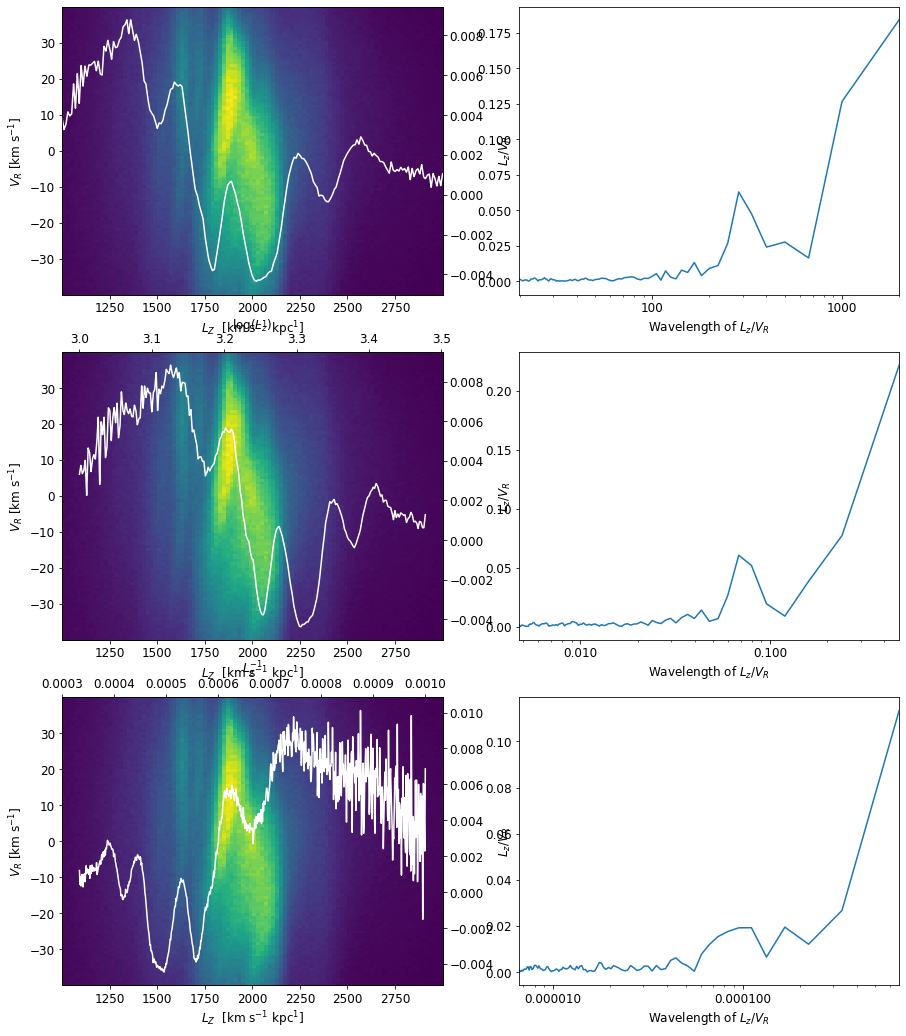

In [722]:
XMIN=1000
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = True

fig, ax = plt.subplots(3,2,figsize=(15,18))

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
#f = interpolate.interp1d(nx, ny, kind='linear')
#xpol = np.linspace(nx[0], nx[-1], N)
#ypol = f(xpol)
for i in range(3):
    ax[i][0].hist2d(Lz[abs(VR)<40], VR[abs(VR)<40], bins=100);
    ax[i][0].set_aspect('auto')
    ax[i][0].set_xlabel(r'$L_Z$  [km s$^{-1}$ kpc$^{1}$]')
    ax[i][0].set_ylabel(r'$V_R$ [km s$^{-1}$] ')

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[0][0].twinx()
ax_right.plot(xpol, ypol, c='white')
ax_right.set_ylabel('$L_z/V_R$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
ax[0][1].plot(xfr, np.abs(yf)/np.sum(np.abs(yf)))
ax[0][1].set_xlim(xfr[100], max(xfr))
ax[0][1].set_xscale('log')
ax[0][1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[0][1].set_aspect('auto')
ax[0][1].set_xlabel('Wavelength of $L_z/V_R$')

nx, ny = smooth_bins(np.log10(Lz), VR/Lz, np.min(np.log10(Lz)), np.max(np.log10(Lz)), 0.002)
N = 100000
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[1][0].twiny()
ax_right.set_xlabel('log($L_z$)')
ax_right = ax_right.twinx()
ax_right.plot(xpol, ypol, c='white')
ax_right.set_ylabel('$L_z/V_R$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
ax[1][1].plot(xfr, np.abs(yf)/np.sum(np.abs(yf)))
ax[1][1].set_xlim(xfr[100], max(xfr))
ax[1][1].set_xscale('log')
ax[1][1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[1][1].set_aspect('auto')
ax[1][1].set_xlabel('Wavelength of $L_z/V_R$')

nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), np.max(1/Lz), 1e-6)
N = 100000
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[2][0].twiny()
ax_right.set_xlabel('$L_z^{-1}$')
ax_right = ax_right.twinx()
ax_right.plot(xpol, ypol, c='white')
ax_right.set_ylabel('$L_z/V_R$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
ax[2][1].plot(xfr, np.abs(yf)/np.sum(np.abs(yf)))
ax[2][1].set_xlim(xfr[100], max(xfr))
ax[2][1].set_xscale('log')
ax[2][1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[2][1].set_aspect('auto')
ax[2][1].set_xlabel('Wavelength of $L_z/V_R$')

namef='plots/fourier_data'+'.png'
plt.savefig(namef, bbox_inches='tight')

(100000, 5)


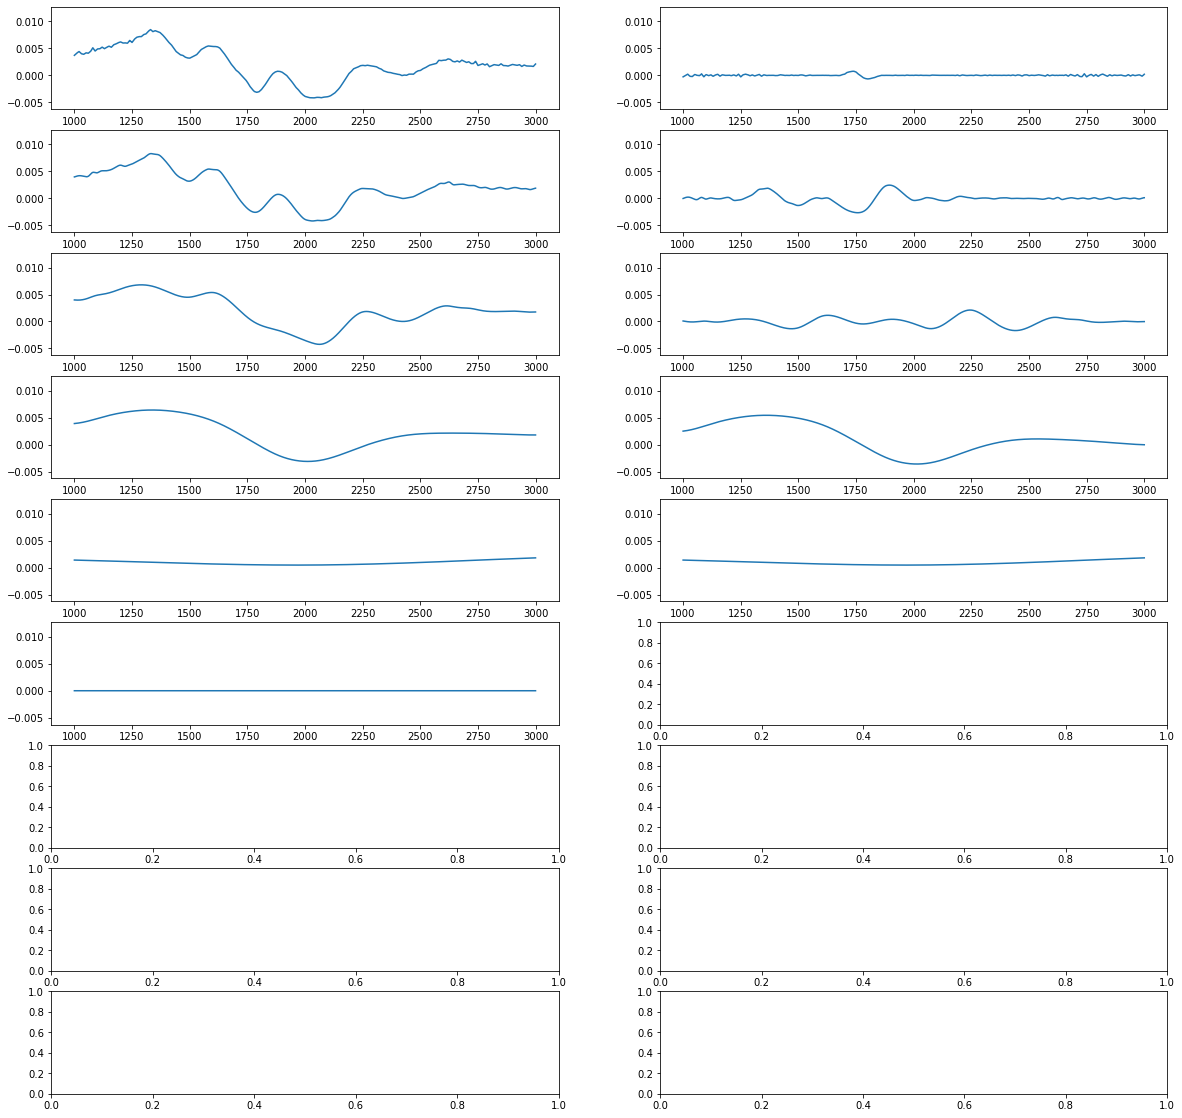

In [23]:
#TIME = 1.5
#XMIN=1200
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = False

#TIME = 2.9
#XMIN=1000
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
#DATA = False

XMIN=1000
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2, new=True)
DATA = True

fig, ax = plt.subplots(9,2,figsize=(20,20))


nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
#nx, ny = smooth_bins(1/Lz, VR/Lz, 1/XMAX, 1/XMIN, 1e-6)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax[0][0].plot(xpol, ypol)
ax[0][0].set_ylim(min(ypol)*1.5, max(ypol)*1.5)


imf = emd.sift.sift(ypol)
print(imf.shape)
rypol = ypol.copy()
for i in range(imf.shape[1]):
    ax[i][1].plot(xpol, imf[:,i])
    ax[i][1].set_ylim(min(ypol)*1.5, max(ypol)*1.5)
    rypol -= imf[:,i]
    ax[i+1][0].plot(xpol, rypol)
    ax[i+1][0].set_ylim(min(ypol)*1.5, max(ypol)*1.5)

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

0 10365.91788025049
1 36980.376637047106
2 125110.43209915062
3 512916.942435521


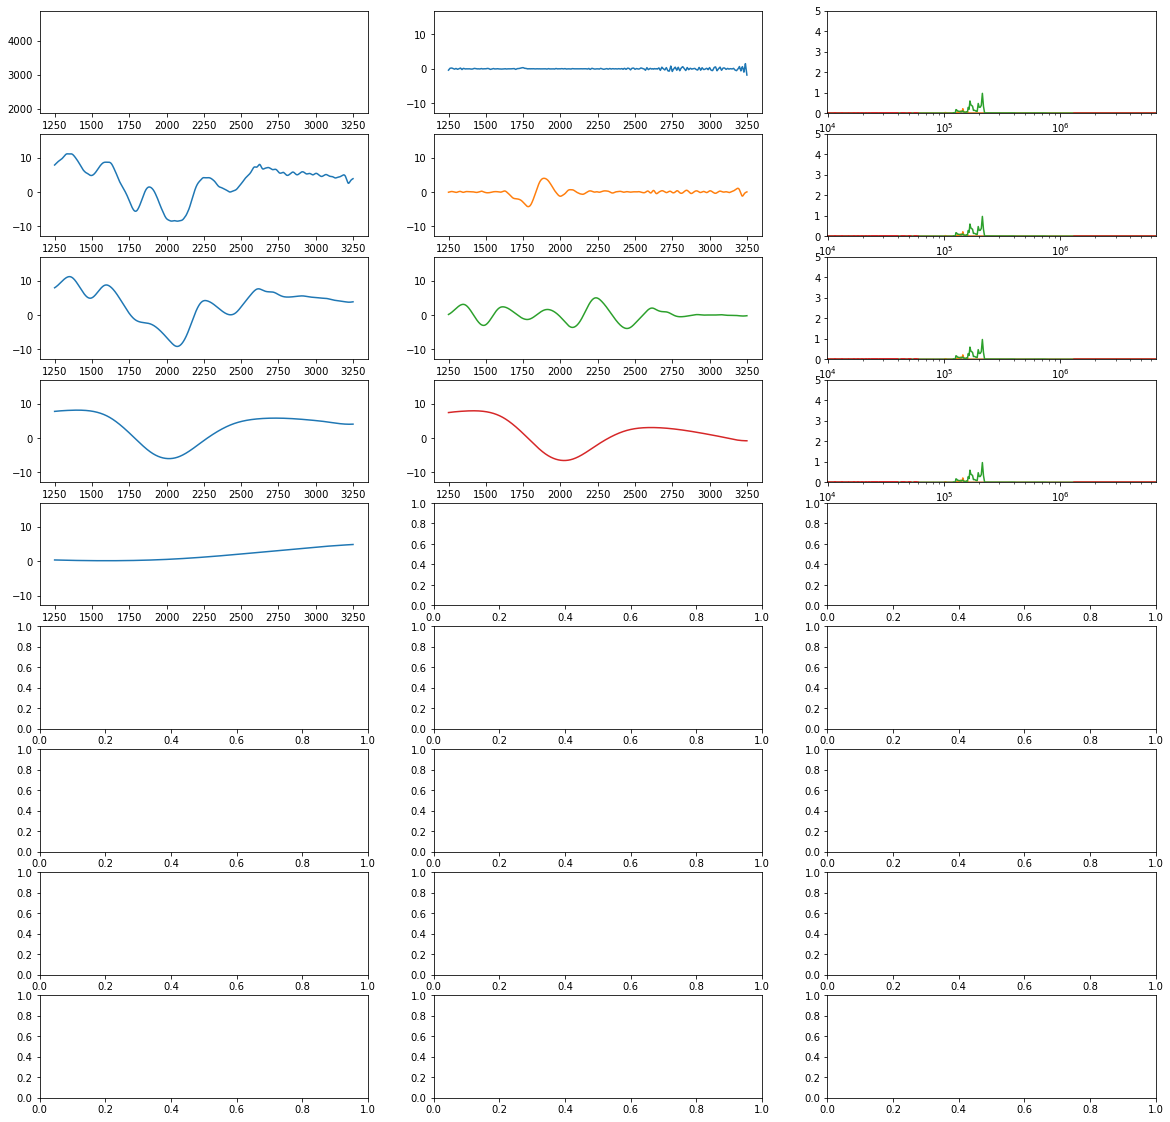

In [33]:
TIME = 1.5
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = False

#TIME = 2.9
#XMIN=1000
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
#DATA = False
#
XMIN=1250
XMAX=3250
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2, new=True)
DATA = True


fig, ax = plt.subplots(9,3,figsize=(20,20))


#nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = len(nx)
#nx, ny = smooth_bins(1/Lz, VR/Lz, 1/XMAX, 1/XMIN, 1e-6)
ax[0][0].plot(nx, ny)
ax[0][0].set_ylim(min(ny)*1.5, max(ny)*1.5)

#xfr = ((nx[-1]-nx[0]) / abs(xf * N))

sample_rate=1
imf = emd.sift.sift(ypol)
#IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
rypol = ypol.copy()
for i in range(imf.shape[1]):
    ax[i][1].plot(xpol, imf[:,i], c=f'C{i}')
    ax[i][1].set_ylim(min(ypol)*1.5, max(ypol)*1.5)
    #ax[i][2].plot(xpol, IF[:,i])
    print(i, (nx[-1]-nx[0]) / abs(np.mean(IF[:,i]) * N))
    rypol -= imf[:,i]
    ax[i+1][0].plot(xpol, rypol)
    ax[i+1][0].set_ylim(min(ypol)*1.5, max(ypol)*1.5)
    for j in range(imf.shape[1]):
        freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 1000, 'linear')
        hht_f, spec = emd.spectra.hilberthuang(IF[:,j], IA[:,j], freq_edges, scaling='density')
        #hht_f, spec = emd.spectra.hilberthuang(IF[:,j], np.ones(IA[:,j].shape), freq_edges, scaling='density')
        hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
        ax[i][2].plot(hhtfr, spec)
        ax[i][2].xaxis.set_major_formatter(ticker.ScalarFormatter())
        ax[i][2].set_xlim(min(hhtfr), max(hhtfr))
        ax[i][2].set_xscale('log')
        ax[i][2].set_ylim(0,5)


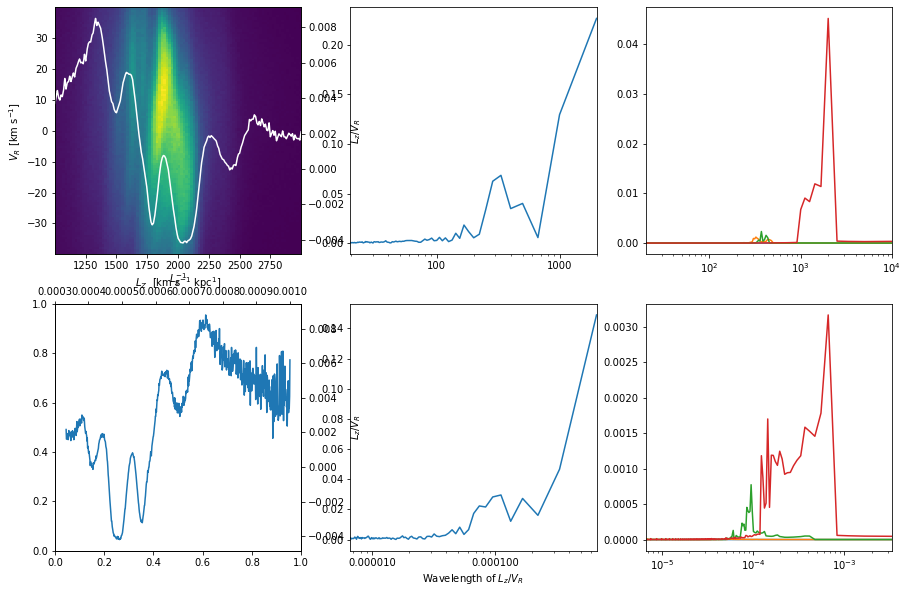

In [38]:

#TIME = 2.0
#XMIN=1200
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = False

#TIME = 2.9
#XMIN=1000
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
#DATA = False

XMIN=1000
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2, new=True)
DATA = True

fig, ax = plt.subplots(2,3,figsize=(15,10))

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
#f = interpolate.interp1d(nx, ny, kind='linear')
#xpol = np.linspace(nx[0], nx[-1], N)
#ypol = f(xpol)
ax[0][0].hist2d(Lz[abs(VR)<40], VR[abs(VR)<40], bins=100);
ax[0][0].set_aspect('auto')
ax[0][0].set_xlabel(r'$L_Z$  [km s$^{-1}$ kpc$^{1}$]')
ax[0][0].set_ylabel(r'$V_R$ [km s$^{-1}$] ')

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[0][0].twinx()
ax_right.plot(xpol, ypol, c='white')
ax_right.set_ylabel('$L_z/V_R$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
ax[0][1].plot(xfr, np.abs(yf)/np.sum(np.abs(yf)))
ax[0][1].set_xlim(xfr[100], max(xfr))
ax[0][1].set_xscale('log')
ax[0][1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[0][1].set_aspect('auto')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
sample_rate=1
imf = emd.sift.sift(ypol)
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 500, 'linear')
#freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')

for i in range(4):
    hht_f, spec = emd.spectra.hilberthuang(IF[:,i], IA[:,i], freq_edges, scaling='density')
    hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
    ax[0][2].plot(hhtfr, spec)
    ax[0][2].xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax[0][2].set_xlim(min(hhtfr), max(hhtfr))
    ax[0][2].set_xscale('log')


nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), np.max(1/Lz), 1e-6)
N = 100000
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[1][0].twiny()
ax_right.set_xlabel('$L_z^{-1}$')
ax_right = ax_right.twinx()
ax_right.plot(xpol, ypol)
ax_right.set_ylabel('$L_z/V_R$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
ax[1][1].plot(xfr, np.abs(yf)/np.sum(np.abs(yf)))
ax[1][1].set_xlim(xfr[100], max(xfr))
ax[1][1].set_xscale('log')
ax[1][1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[1][1].set_aspect('auto')
ax[1][1].set_xlabel('Wavelength of $L_z/V_R$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
sample_rate=1
imf = emd.sift.sift(ypol)
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 500, 'linear')
#freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')
hht_f, spec = emd.spectra.hilberthuang(IF, IA, freq_edges, scaling='density')
hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
#ax[1][2].plot(hhtfr, spec)
#ax[1][2].xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax[1][2].set_xlim(min(hhtfr), max(hhtfr))
#ax[1][2].set_xscale('log')

for i in range(4):
    hht_f, spec = emd.spectra.hilberthuang(IF[:,i], IA[:,i], freq_edges, scaling='density')
    hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
    ax[1][2].plot(hhtfr, spec)
    ax[1][2].xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax[1][2].set_xlim(min(hhtfr), max(hhtfr))
    ax[1][2].set_xscale('log')


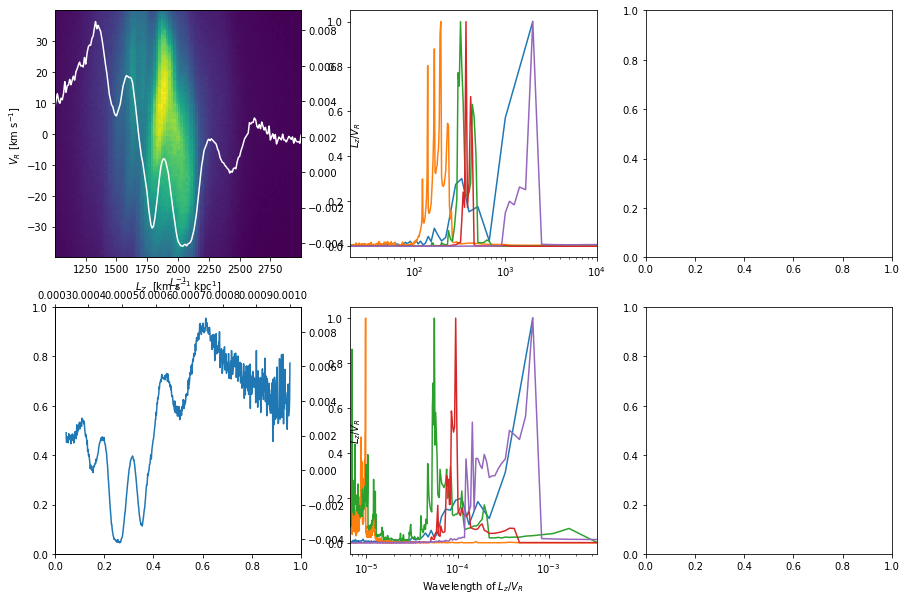

In [40]:

#TIME = 2.0
#XMIN=1200
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = False

#TIME = 2.9
#XMIN=1000
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
#DATA = False

XMIN=1000
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2, new=True)
DATA = True

fig, ax = plt.subplots(2,3,figsize=(15,10))

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
#f = interpolate.interp1d(nx, ny, kind='linear')
#xpol = np.linspace(nx[0], nx[-1], N)
#ypol = f(xpol)
ax[0][0].hist2d(Lz[abs(VR)<40], VR[abs(VR)<40], bins=100);
ax[0][0].set_aspect('auto')
ax[0][0].set_xlabel(r'$L_Z$  [km s$^{-1}$ kpc$^{1}$]')
ax[0][0].set_ylabel(r'$V_R$ [km s$^{-1}$] ')

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[0][0].twinx()
ax_right.plot(xpol, ypol, c='white')
ax_right.set_ylabel('$L_z/V_R$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
ax[0][1].plot(xfr, np.abs(yf)/np.max(np.abs(yf)))
ax[0][1].set_xlim(xfr[100], max(xfr))
ax[0][1].set_xscale('log')
ax[0][1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[0][1].set_aspect('auto')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
sample_rate=1
imf = emd.sift.sift(ypol)
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 500, 'linear')
#freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')

for i in range(4):
    hht_f, spec = emd.spectra.hilberthuang(IF[:,i], IA[:,i], freq_edges, scaling='density')
    hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
    ax[0][1].plot(hhtfr, spec/np.max(spec))
    ax[0][1].xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax[0][1].set_xlim(min(hhtfr), max(hhtfr))
    ax[0][1].set_xscale('log')


nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), np.max(1/Lz), 1e-6)
N = 100000
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[1][0].twiny()
ax_right.set_xlabel('$L_z^{-1}$')
ax_right = ax_right.twinx()
ax_right.plot(xpol, ypol)
ax_right.set_ylabel('$L_z/V_R$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
ax[1][1].plot(xfr, np.abs(yf)/np.max(np.abs(yf)))
ax[1][1].set_xlim(xfr[100], max(xfr))
ax[1][1].set_xscale('log')
ax[1][1].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[1][1].set_aspect('auto')
ax[1][1].set_xlabel('Wavelength of $L_z/V_R$')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
sample_rate=1
imf = emd.sift.sift(ypol)
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 500, 'linear')
#freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')
hht_f, spec = emd.spectra.hilberthuang(IF, IA, freq_edges, scaling='density')
hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
#ax[1][2].plot(hhtfr, spec)
#ax[1][2].xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax[1][2].set_xlim(min(hhtfr), max(hhtfr))
#ax[1][2].set_xscale('log')

for i in range(4):
    hht_f, spec = emd.spectra.hilberthuang(IF[:,i], IA[:,i], freq_edges, scaling='density')
    hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
    ax[1][1].plot(hhtfr, spec/np.max(spec))
    ax[1][1].xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax[1][1].set_xlim(min(hhtfr), max(hhtfr))
    ax[1][1].set_xscale('log')


/tmp/ipykernel_4655/2487271385.py:4: RuntimeWarning: divide by zero encountered in true_divide
  wef = (nx[-1]-nx[0])/(wef*N)



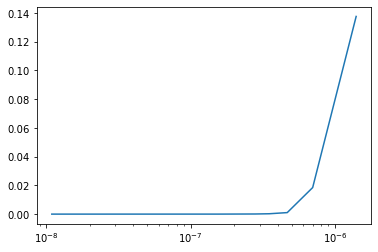

In [487]:
import scipy.signal

wef, wea = scipy.signal.welch(ypol)
wef = (nx[-1]-nx[0])/(wef*N)
#wef = wef * N
plt.plot(wef, wea)
plt.xscale('log')
#plt.xlim(0,0.1)

Dhot_log
Dhotn10_pn10
Dhotn_10_pn_10
Dhot_log_2perturb


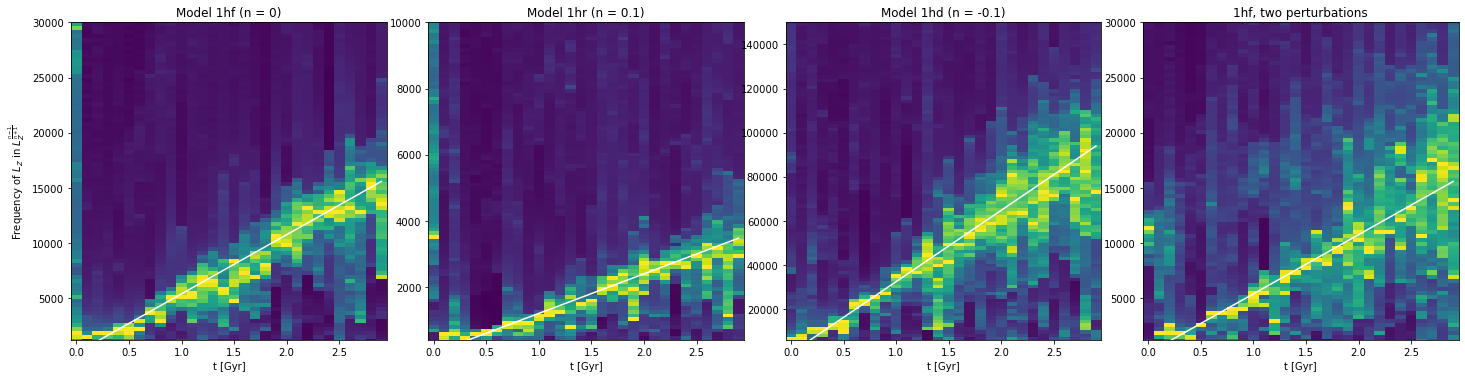

In [517]:

#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')


eps = 0.00001
times = np.arange(eps, 3.0+eps, 0.1)
vtimes = list(times)

fig, ax = plt.subplots(1,4,figsize=(20,5))
fig.tight_layout()
#fig = plt.figure(constrained_layout=False,figsize=(ncols*2.45,nrows*2.5))
#gs = fig.add_gridspec(nrows,ncols, hspace=0., wspace=0.)
#ax = gs.subplots(sharex=True,sharey=True)

ns = [0,0.1,-0.1,0]
ylims=[30000,10000,150000,30000]
model_labels = ['Model 1hf (n = 0)', 'Model 1hr (n = 0.1)', 'Model 1hd (n = -0.1)', '1hf, two perturbations']
for model_i, model in enumerate(['Dhot_log', 'Dhotn10_pn10', 'Dhotn_10_pn_10', 'Dhot_log_2perturb']):
#for model_i, model in enumerate(['Dhot_log']):
    print(model)
    fourier = []
    freqs = []
    freqs2 = []
    for time in times:
        XMIN=1200
        XMAX=3500
        BINSIZE = 10
        x,y,VR,Vphi,R,Lz,phi=l.load_model(model, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)
        DATA = False

        n = ns[model_i]
        nx, ny = smooth_bins(Lz**((n-1)/(n+1)), VR/Lz, np.min(Lz**((n-1)/(n+1))), np.max(Lz**((n-1)/(n+1))), 1e-6)
        N = 100000
        f = interpolate.interp1d(nx, ny, kind='linear')
        xpol = np.linspace(nx[0], nx[-1], N)
        ypol = f(xpol)
        xpol = xpol[~np.isnan(ypol)]
        ypol = ypol[~np.isnan(ypol)]
        N = len(ypol)

        #ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
        #yf = fft(ypol)
        #xf = fftfreq(N)
        #yf = yf[xf>0]
        #xf = xf[xf>0]
        #xfr = ((nx[-1]-nx[0]) / abs(xf * N))
        #fourier.append(yf)
        
        ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
        sample_rate=1
        imf = emd.sift.sift(ypol)
        
        IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
        freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 500, 'linear')
        #freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')
        hht_f, spec = emd.spectra.hilberthuang(IF, IA, freq_edges, scaling='spectrum')
        spec = spec / np.max(spec)
        #hht_f, spec = emd.spectra.hilberthuang(IF, np.ones(IA.shape), freq_edges, scaling='spectrum')
        hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
        fourier.append(spec)
        
        #IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
        #freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 200, 'linear')
        ##freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')
        #hht_f, spec = emd.spectra.hilberthuang(IF[:,0], IA[:,0], freq_edges, scaling='spectrum')
        #spec = np.zeros(spec.shape)
        #for j in range(imf.shape[1]):
        #    sp = emd.spectra.hilberthuang(IF[:,j], IA[:,j], freq_edges, scaling='spectrum')[1]
        #    sp = np.nan_to_num(sp)
        #    spec += sp
        #hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
        #fourier.append(spec)

    #fourier = np.abs(np.array(fourier))
    #xfr = hhtfr[:100]
    #fourier = fourier[:,:100]
    fourier = np.array(fourier)
    xfr = hhtfr

    #Z = fourier.T/np.max(fourier, axis=1)
    Z = fourier.T
    #Z = fourier.T/np.sum(fourier, axis=1)
    #f = [interpolate.interp1d(xfr,fou,kind='linear') for fou in fourier]
    #y_coords = np.linspace(min(xfr),max(xfr),500)
    #Z = [fi(y_coords) for fi in f]
    #Z = np.array(Z).T
    #plt.imshow(fourier,extent=[min(times),max(times),0,max(times)],origin="lower")
    #f = interpolate.interp2d(times,xfr,fourier,kind="linear")
    #x_coords = times
    #y_coords = np.linspace(min(xfr),max(xfr),200)
    #Z = f(x_coords,y_coords)
    #Z = Z/Z.sum(axis=1,keepdims=1)
    #plt.imshow((Z/np.max(Z)),extent=[min(times),max(times),min(xfr),max(xfr)],origin="lower",aspect="auto",cmap='viridis')
    #plt.pcolormesh(times, xfr, fourier.T, shading='gouraud', cmap='viridis')
    #plt.pcolormesh(times, 1/xfr, fourier.T, cmap='viridis')
    ax[model_i].pcolormesh(times, 1/xfr, np.sqrt(Z), cmap='viridis')
    ax[model_i].set_xlabel('t [Gyr]')
    ax[model_i].set_ylim(ylims[model_i]/25,ylims[model_i])
    ax[model_i].set_title(model_labels[model_i])
    ax[0].set_ylabel(r'Frequency of $L_Z$ in $L_Z^{\frac{n-1}{n+1}}$')
    #if model_i > 0:
    #    ax[model_i].yaxis.set_ticklabels([])
    
    def freqcurve(t, n):
        Vc = 240
        R0 = 8
        #return 1/((Vc/R0**n)**(-2/(1+n)) * (1-0.5*np.sqrt(2*n+2)) / t * (2*np.pi))
        ct = (Vc / R0**n) ** (2/(1+n)) * (1-0.5*np.sqrt(2*n+2)) / np.pi
        return ct * t
    
    ax[model_i].plot(times, freqcurve(times, n=ns[model_i]), c='w')



In [518]:
#N = 100000

#f = interpolate.interp1d(Lz, AR, kind='linear')
#xpol = np.linspace(1200, 3600, N)
#ypol = f(xpol)
#plt.plot(xpol, ypol, c='white')

eps = 0.00001
#times = np.arange(eps, 3.0+eps, 0.02)
times = np.arange(0.1, 7.0, 0.1)
vtimes = list(times)

binsizes = [10, 1e-6]
n = (-0.1-1)/(-0.1+1)
for tfi, tf in enumerate([lambda x: x, lambda x: x**n]):
    fourier = []
    freqs = []
    freqs2 = []
    for time in times:
        print(time)

        #XMIN=1200
        #XMAX=3500
        #BINSIZE = 10
        #x,y,VR,Vphi,R,Lz,phi=l.load_model(CURMODEL, time, xmin=XMIN, xmax=XMAX, phi_range=0.2)

        XMIN=1000
        XMAX=3500
        BINSIZE = 50
        x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', time, xmin=XMIN, xmax=XMAX, phi_range=0.2, maxvr=100)
        DATA = False

        nx, ny = smooth_bins(tf(Lz), VR/Lz, np.min(tf(Lz)), np.max(tf(Lz)), binsizes[tfi])
        N = 100000
        f = interpolate.interp1d(nx, ny, kind='linear')
        xpol = np.linspace(nx[0], nx[-1], N)
        ypol = f(xpol)
        xpol = xpol[~np.isnan(ypol)]
        ypol = ypol[~np.isnan(ypol)]
        N = len(ypol)

        ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
        sample_rate=1
        imf = emd.sift.sift(ypol)
        IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
        freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 200, 'linear')
        #freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')
        hht_f, spec = emd.spectra.hilberthuang(IF, IA, freq_edges, scaling='spectrum')
        #hht_f, spec = emd.spectra.hilberthuang(IF, np.ones(IA.shape), freq_edges, scaling='spectrum')
        hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))
        fourier.append(spec)

    np.save(f'hht_time_mwsgr_10_35_{tfi}.npy', fourier)
    np.save(f'hhfr_time_mwsgr_10_35_{tfi}.npy', hhtfr)


0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5000000000000004
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1
4.2
4.3
4.3999999999999995
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.50000000000000

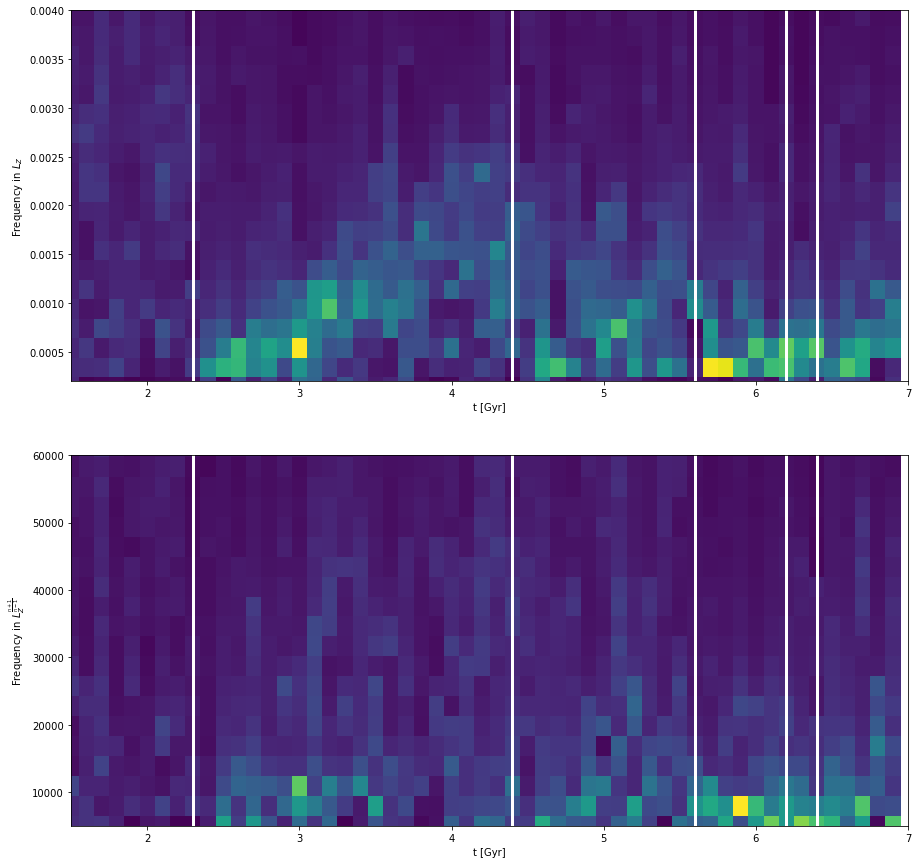

In [519]:
fig, ax = plt.subplots(2,1,figsize=(15,15))
times = np.arange(0.1, 7.0, 0.1)
ylims = [[0.00020,0.004], [5000,60000]]
desc = ["L_Z", r"L_Z^{\frac{n+1}{n-1}}"]
for tfi in range(2):
    fourier = np.load(f'hht_time_mwsgr_10_35_{tfi}.npy')
    xfr = np.load(f'hhfr_time_mwsgr_10_35_{tfi}.npy')
    fourier = np.abs(np.array(fourier))
    xfr = xfr[:100]
    fourier = fourier[:,:100]

    #Z = fourier.T/np.max(fourier, axis=1)
    Z = fourier.T
    #Z = fourier.T/np.sum(fourier, axis=1)
    #f = [interpolate.interp1d(xfr,fou,kind='linear') for fou in fourier]
    #y_coords = np.linspace(min(xfr),max(xfr),500)
    #Z = [fi(y_coords) for fi in f]
    #Z = np.array(Z).T
    #plt.imshow(fourier,extent=[min(times),max(times),0,max(times)],origin="lower")
    #f = interpolate.interp2d(times,xfr,fourier,kind="linear")
    #x_coords = times
    #y_coords = np.linspace(min(xfr),max(xfr),200)
    #Z = f(x_coords,y_coords)
    #Z = Z/Z.sum(axis=1,keepdims=1)
    #plt.imshow((Z/np.max(Z)),extent=[min(times),max(times),min(xfr),max(xfr)],origin="lower",aspect="auto",cmap='viridis')
    #plt.pcolormesh(times, xfr, fourier.T, shading='gouraud', cmap='viridis')
    #plt.pcolormesh(times, 1/xfr, fourier.T, cmap='viridis')
    ax[tfi].pcolormesh(times, 1/xfr, np.sqrt(Z), cmap='viridis')
    ax[tfi].set_xlabel('t [Gyr]')
    ax[tfi].set_ylabel(fr'Frequency in ${desc[tfi]}$')
    ax[tfi].set_ylim(*ylims[tfi])
    ax[tfi].set_xlim(1.5,7)
    
    for peri in [2.3, 4.4, 5.6, 6.2, 6.4]:
        ax[tfi].axvline(peri, c='w', lw=3)


    #plt.plot(vtimes, np.array(freqs), color='w')

    #fit = np.polyfit(vtimes, 1/np.array(freqs), 1)
    #pol = np.poly1d(fit)
    ##plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w')
    #ax[model_i].plot(times, pol(times), c='w')
#
    #if model == 'Dhot_log_2perturb':
    #    fit = np.polyfit(vtimes, 1/np.array(freqs2), 1)
    #    pol = np.poly1d(fit)
    #    #plt.plot(times[1/pol(times) < max(y_coords)], 1/pol(times)[1/pol(times)<max(y_coords)], c='w', ls='--')
    #    ax[model_i].plot(times, pol(times), c='w', ls='--')


/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

0.00059945
[9.9950e-05 1.9985e-04 2.9975e-04 3.9965e-04 4.9955e-04 5.9945e-04
 6.9935e-04 7.9925e-04 8.9915e-04 9.9905e-04]
[0.00014133 0.00024476 0.00034611 0.00044682 0.00054723 0.00064748
 0.00074763 0.00084773 0.00094778 0.00104781]
-1.2222222222222223
7073.451327433649
[ 1769.02654867  3537.16814159  5305.30973451  7073.45132743
  8841.59292035 10609.73451327 12377.87610619 14146.01769912
 15914.15929204 17682.30088496]
[ 2501.46843866  4331.94789606  6125.91627302  7908.26006016
  9685.39898814 11459.75476722 13232.44703279 15004.06541614
 16774.95016186 18545.31143549]


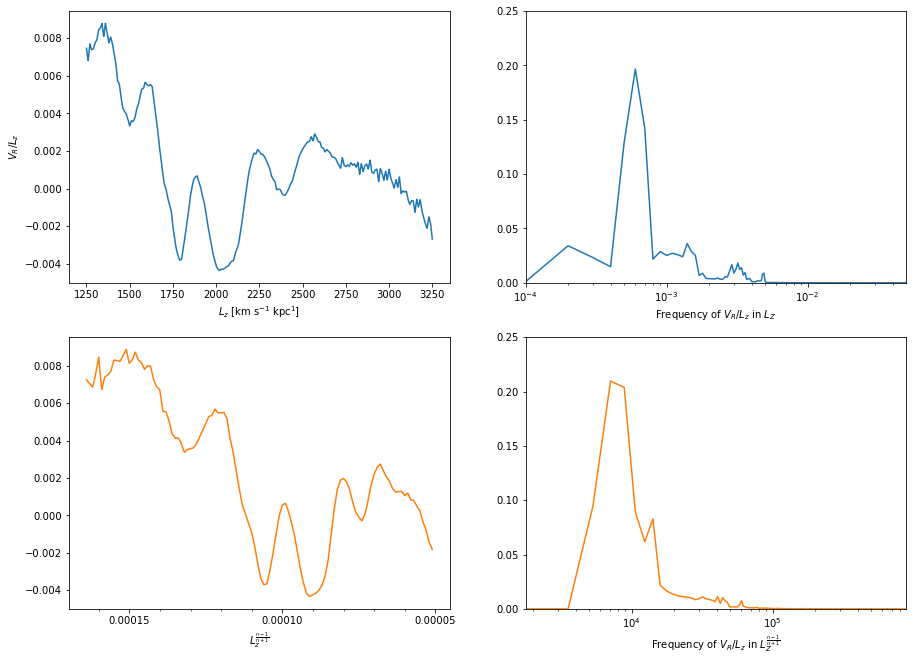

In [364]:
XMIN=1250
XMAX=3250
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = True

fig, ax = plt.subplots(2,2,figsize=(15,11))
#fig = plt.figure(figsize=(15,4))
#subfigs = fig.subfigures(1, 2, wspace=0, width_ratios=(1,2))
#ax = []
#ax.append(subfigs[0].add_subplot(111))
#gs = subfigs[1].add_gridspec(1,2, hspace=0., wspace=0.)
#ax.extend(gs.subplots(sharey=True))
#fig, axs = plt.subplots(1,4,figsize=(15,4))
#gs = axs[1:3].get_gridspec()
#for ax in axs[1:3]:
#    ax.remove()
#ax = axs[0] + gs.subplots(sharey=True)

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000
#f = interpolate.interp1d(nx, ny, kind='linear')
#xpol = np.linspace(nx[0], nx[-1], N)
#ypol = f(xpol)
#for i in range(3):
#    ax[i][0].hist2d(Lz[abs(VR)<40], VR[abs(VR)<40], bins=100);
#    ax[i][0].set_aspect('auto')
#    ax[i][0].set_xlabel(r'$L_Z$  [km s$^{-1}$ kpc$^{1}$]')
#    ax[i][0].set_ylabel(r'$V_R$ [km s$^{-1}$] ')

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
#ax_right = ax[0][0].twinx()
#ax_right.plot(xpol, ypol, c='white')
#ax_right.set_ylabel('$L_z/V_R$')
ax[0][0].plot(xpol, ypol, c='C0')
ax[0][0].set_aspect('auto')
#ax[0][0].spines['bottom'].set_color('C0')
#ax[0][0].tick_params(axis='x', colors='C0')
ax[0][0].set_xlabel(r'$L_z$ [km s$^{-1}$ kpc$^{1}$]')
#ax[0][0].xaxis.label.set_color('C0')
ax[0][0].set_ylabel(r'$V_R/L_z$')


ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
sample_rate=1
imf = emd.sift.sift(ypol)
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 500, 'linear')
#freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')
hht_f, spec = emd.spectra.hilberthuang(IF, IA, freq_edges, scaling='spectrum')
hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))

yf = spec
xfr = hhtfr

print(1/xfr[np.argmax(np.abs(yf))])
ax[0][1].plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C0')
ax[0][1].set_xlim(1/max(xfr), 1/min(xfr))
ax[0][1].set_xscale('log')
ax[0][1].set_aspect('auto')
ax[0][1].set_xlabel('Frequency of $V_R/L_z$ in $L_Z$')
ax[0][1].set_ylim(0,0.25)
#ax[0][1].spines['top'].set_color('C1')
#ax[0][1].tick_params(axis='x', colors='C0')
#ax[0][1].xaxis.label.set_color('C0')
print(1/xfr[:10])
avgs = np.sqrt(xfr[1:] * xfr[:-1])
print(1/avgs[:10])

#ax[0][1].errorbar(x=1/xfr[1], y=0.075, xerr=[[abs(1/xfr[1]-1/avgs[0])], [abs(1/xfr[1]-1/avgs[1])]], color='C0', capsize=5)
#ax[0][1].errorbar(x=1/xfr[6], y=0.075, xerr=[[abs(1/xfr[6]-1/avgs[5])], [abs(1/xfr[6]-1/avgs[6])]], color='C0', capsize=5)


n = -0.1
print((n-1)/(n+1))
nx, ny = smooth_bins(Lz**((n-1)/(n+1)), VR/Lz, np.min(Lz**((n-1)/(n+1))), np.max(Lz**((n-1)/(n+1))), 1e-6)
N = 100000
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
#ax_right = ax[2][0].twiny()
#ax_right.set_xlabel('$L_z^{-1}$')
#ax_right = ax_right.twinx()
#ax_right.plot(xpol, ypol, c='white')
#ax_right.set_ylabel('$L_z/V_R$')
axb = ax[1][0]
axb.plot(xpol, ypol, c='C1')
#axb.spines['top'].set_position(('outward', 40))
#axb.spines['top'].set_color('C1')
#axb.tick_params(axis='x', colors='C1')
axb.set_xlabel(r'$L_z^\frac{n-1}{n+1}$')
#axb.xaxis.label.set_color('C1')
axb.set_xlim(axb.get_xlim()[::-1])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
axb.xaxis.set_minor_locator(AutoMinorLocator())
#axb.ticklabel_format(style='sci', axis='x', scilimits=(1e-3,1e4))
axb.locator_params(axis='x', nbins=4)


ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
sample_rate=1
imf = emd.sift.sift(ypol)
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 500, 'linear')
#freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 50, 'log')
hht_f, spec = emd.spectra.hilberthuang(IF, IA, freq_edges, scaling='spectrum')
hhtfr = ((nx[-1]-nx[0]) / (hht_f * N))

yf = spec
xfr = hhtfr

axb = ax[1][1]
axb.plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C1')
print(1/xfr[np.argmax(np.abs(yf))])
axb.set_xlim(1/max(xfr), 1/min(xfr))
axb.set_ylim(0,0.25)
axb.set_xscale('log')
#ax[2].xaxis.set_major_formatter(ticker.ScalarFormatter())
axb.set_aspect('auto')
axb.set_xlabel(r'Frequency of $V_R/L_z$ in $L_Z^{\frac{n-1}{n+1}}$')
#axb.spines['top'].set_color('C1')
#axb.tick_params(axis='x', colors='C1')
#axb.xaxis.label.set_color('C1')

print(1/xfr[:10])
avgs = np.sqrt(xfr[1:] * xfr[:-1])
print(1/avgs[:10])
#axb.vlines(x=1/avgs[0], ymin=0, ymax=0.125, c='C1', ls='-')
#axb.axvspan(1/avgs[1], 1/avgs[5], color='C1', alpha=0.2)
#axb.axvspan(0, 1/avgs[0], color='C1', alpha=0.2)

#axb.errorbar(x=0, y=0.075, xerr=[[0], [1/avgs[0]]], color='C1', capsize=5)
#axb.errorbar(x=1/avgs[3], y=0.075, xerr=[[abs(1/avgs[3]-1/avgs[1])], [abs(1/avgs[3]-1/avgs[5])]], color='C1', capsize=5)


#for i in range(1,4):
#    ax[i].set_ylim(0,0.175)


11227.09105410586


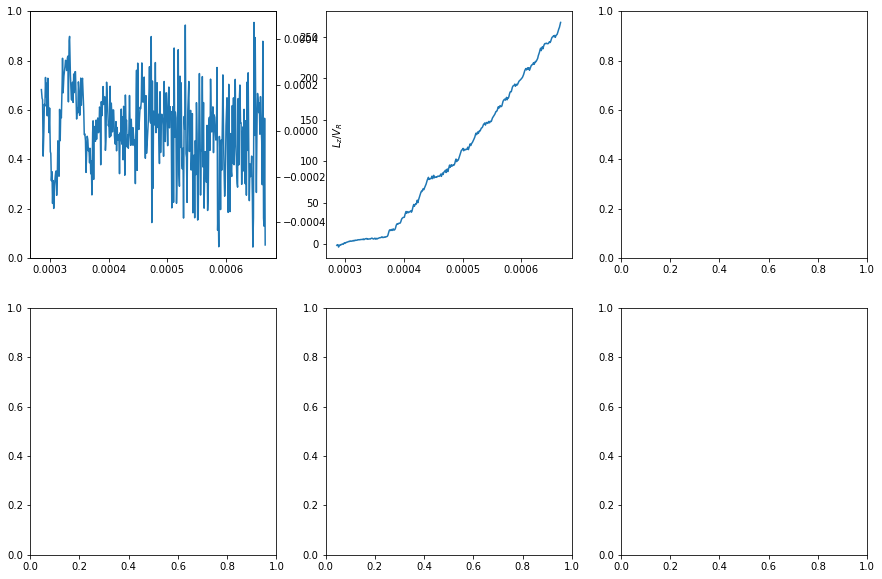

In [209]:

#TIME = 2.5
#TIME = 2.5
#XMIN=1200
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = False

TIME = 3.5
XMIN=1000
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
DATA = False

#XMIN=1000
#XMAX=3000
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = True

fig, ax = plt.subplots(2,3,figsize=(15,10))

#nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
#nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), np.max(1/Lz), 1e-6)
nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), 1/1500, 1e-6)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[0][0].twinx()
ax_right.plot(xpol, ypol)
ax_right.set_ylabel('$L_z/V_R$')

from scipy.signal import hilbert
analytic_signal = hilbert(ny)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * N)
ax[0][1].plot(nx, instantaneous_phase)
#ax[0][1].plot(nx[1:], instantaneous_frequency)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
ifs = np.convolve(instantaneous_frequency, kernel, mode='same')
#ax[0][1].plot(nx[1:], ifs)
print(np.mean(instantaneous_frequency))
#XMIN=1200
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = False

TIME = 3.5
XMIN=1000
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
DATA = False

#XMIN=1000
#XMAX=3000
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = True

fig, ax = plt.subplots(2,3,figsize=(15,10))

#nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
#nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), np.max(1/Lz), 1e-6)
nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), 1/1500, 1e-6)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
ax_right = ax[0][0].twinx()
ax_right.plot(xpol, ypol)
ax_right.set_ylabel('$L_z/V_R$')

from scipy.signal import hilbert
analytic_signal = hilbert(ny)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * N)
ax[0][1].plot(nx, instantaneous_phase)
#ax[0][1].plot(nx[1:], instantaneous_frequency)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
ifs = np.convolve(instantaneous_frequency, kernel, mode='same')
#ax[0][1].plot(nx[1:], ifs)
print(np.mean(instantaneous_frequency))

/home/hpc/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',

[  1.47876715   0.         -36.93420132]
/home/hpc/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',

[  1.42728838   0.         -39.26446512]


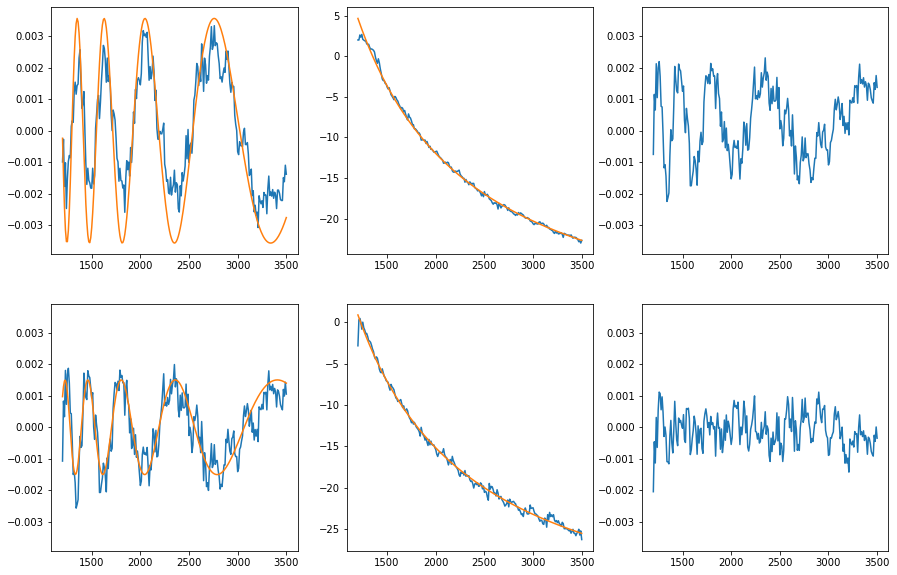

In [405]:

TIME = 1.5
XMIN=1200
XMAX=3500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = False

#TIME = 3.0
#XMIN=1000
#XMAX=3500
#BINSIZE = 20
#x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
#DATA = False

#XMIN=1000
#XMAX=3000
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = True

fig, ax = plt.subplots(2,3,figsize=(15,10))

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
ny -= ny.mean()
#nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), np.max(1/Lz), 1e-6)
#nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), 1/1500, 1e-6)
N = 100000
P = 1
ax[0][0].plot(nx, ny)

from scipy.signal import hilbert
analytic_signal = hilbert(ny)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = -np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * N)
ax[0][1].plot(nx, instantaneous_phase)
#ax[0][1].plot(nx[1:], instantaneous_frequency)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
ifs = np.convolve(instantaneous_frequency, kernel, mode='same')
#ax[0][1].plot(nx[1:], ifs)

def an_phi_mod(Lz, t, n, phi0):
    V0 = 240
    R0 = 8
    pn = 1 - 0.5*np.sqrt(2**(n+1))
    return phi0 + 2 * (V0/(R0)**n)**(2/(1+n)) * pn * t * Lz ** ((n-1)/(1+n))
 
FIXN = 0
fun = lambda Lz, t, n, phi0: an_phi_mod(Lz, t, FIXN, phi0)
#fun = lambda Lz, t, n, phi0: an_phi_mod(Lz, t, n, phi0)
optpar = optimize.curve_fit(fun, nx, instantaneous_phase, p0=[0,FIXN,0], maxfev=10000)[0]
ax[0][1].plot(nx, fun(nx, *optpar))
#ax[0][0].plot(nx, np.sin(fun(nx, *optpar)))
sign = np.max(amplitude_envelope) * np.cos(fun(nx, *optpar))
ax_right.plot(nx, sign, c='C1')
ax[0][0].plot(nx, sign)
ax[0][2].plot(nx, ny - sign)
ax[0][2].set_ylim(ax[0][0].get_ylim())
ax[1][0].set_ylim(ax[0][0].get_ylim())
ax[1][2].set_ylim(ax[0][0].get_ylim())
print(optpar)

ny = ny - sign
ny -= ny.mean()
N = 100000
P = 1
ax[1][0].plot(nx, ny)

from scipy.signal import hilbert
analytic_signal = hilbert(ny)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = -np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * N)
ax[1][1].plot(nx, instantaneous_phase)
#ax[0][1].plot(nx[1:], instantaneous_frequency)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
ifs = np.convolve(instantaneous_frequency, kernel, mode='same')
#ax[0][1].plot(nx[1:], ifs)

def an_phi_mod(Lz, t, n, phi0):
    V0 = 240
    R0 = 8
    pn = 1 - 0.5*np.sqrt(2**(n+1))
    return phi0 + 2 * (V0/(R0)**n)**(2/(1+n)) * pn * t * Lz ** ((n-1)/(1+n))
 
fun = lambda Lz, t, n, phi0: an_phi_mod(Lz, t, FIXN, phi0)
optpar = optimize.curve_fit(fun, nx, instantaneous_phase, p0=[0,FIXN,0], maxfev=10000)[0]
ax[1][1].plot(nx, fun(nx, *optpar))
#ax[0][0].plot(nx, np.sin(fun(nx, *optpar)))
sign = np.max(amplitude_envelope)/2 * np.cos(fun(nx, *optpar))
ax_right.plot(nx, sign, c='C1')
ax[1][0].plot(nx, sign)
ax[1][2].plot(nx, ny - sign)
print(optpar)

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

/home/hpc/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',

[ 0.37681046  0.054      -9.19709853]
/home/hpc/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',

[  1.40462525   0.054      -37.33507797]


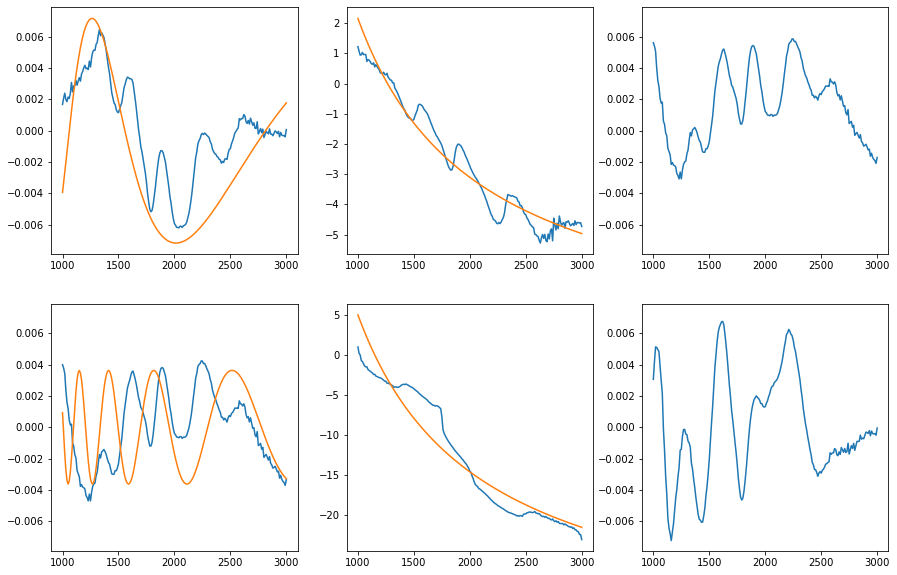

In [27]:

#TIME = 1.5
#XMIN=1200
#XMAX=3500
#BINSIZE = 10
#x,y,VR,Vphi,R,Lz,phi=l.load_model('Dhot_log_2perturb', TIME, xmin=XMIN, xmax=XMAX, phi_range=0.2)
#DATA = False

#TIME = 3.0
#XMIN=1000
#XMAX=3500
#BINSIZE = 20
#x,y,VR,Vphi,R,Lz,phi=l.load_model('MW_Sgr', TIME, xmin=XMIN, xmax=XMAX, phi_range=np.pi)
#DATA = False

XMIN=1000
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2, new=True)
DATA = True

fig, ax = plt.subplots(2,3,figsize=(15,10))

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
ny -= ny.mean()
#nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), np.max(1/Lz), 1e-6)
#nx, ny = smooth_bins(1/Lz, VR/Lz, np.min(1/Lz), 1/1500, 1e-6)
N = 100000
P = 1
ax[0][0].plot(nx, ny)

from scipy.signal import hilbert
analytic_signal = hilbert(ny)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = -np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * N)
ax[0][1].plot(nx, instantaneous_phase)
#ax[0][1].plot(nx[1:], instantaneous_frequency)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
ifs = np.convolve(instantaneous_frequency, kernel, mode='same')
#ax[0][1].plot(nx[1:], ifs)

def an_phi_mod(Lz, t, n, phi0):
    V0 = 240
    R0 = 8
    pn = 1 - 0.5*np.sqrt(2**(n+1))
    return phi0 + 2 * (V0/(R0)**n)**(2/(1+n)) * pn * t * Lz ** ((n-1)/(1+n))
 
#FIXN = -0.1
FIXN = 0.054
fun = lambda Lz, t, n, phi0: an_phi_mod(Lz, t, FIXN, phi0)
#fun = lambda Lz, t, n, phi0: an_phi_mod(Lz, t, n, phi0)
optpar = optimize.curve_fit(fun, nx, instantaneous_phase, p0=[0,FIXN,0], maxfev=10000)[0]
ax[0][1].plot(nx, fun(nx, *optpar))
#ax[0][0].plot(nx, np.sin(fun(nx, *optpar)))
sign = np.max(amplitude_envelope) * np.cos(fun(nx, *optpar))
ax[0][0].plot(nx, sign)
ax[0][2].plot(nx, ny - sign)
ax[0][2].set_ylim(ax[0][0].get_ylim())
ax[1][0].set_ylim(ax[0][0].get_ylim())
ax[1][2].set_ylim(ax[0][0].get_ylim())
print(optpar)

ny = ny - sign
ny -= ny.mean()
N = 100000
P = 1
ax[1][0].plot(nx, ny)

from scipy.signal import hilbert
analytic_signal = hilbert(ny)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = -np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * N)
ax[1][1].plot(nx, instantaneous_phase)
#ax[0][1].plot(nx[1:], instantaneous_frequency)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
ifs = np.convolve(instantaneous_frequency, kernel, mode='same')
#ax[0][1].plot(nx[1:], ifs)

def an_phi_mod(Lz, t, n, phi0):
    V0 = 240
    R0 = 8
    pn = 1 - 0.5*np.sqrt(2**(n+1))
    return phi0 + 2 * (V0/(R0)**n)**(2/(1+n)) * pn * t * Lz ** ((n-1)/(1+n))
 
fun = lambda Lz, t, n, phi0: an_phi_mod(Lz, t, FIXN, phi0)
optpar = optimize.curve_fit(fun, nx, instantaneous_phase, p0=[0,FIXN,0], maxfev=10000)[0]
ax[1][1].plot(nx, fun(nx, *optpar))
#ax[0][0].plot(nx, np.sin(fun(nx, *optpar)))
sign = np.max(amplitude_envelope)/2 * np.cos(fun(nx, *optpar))
ax[1][0].plot(nx, sign)
ax[1][2].plot(nx, ny - sign)
print(optpar)

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

[ 0.36400189 -8.8604501 ]


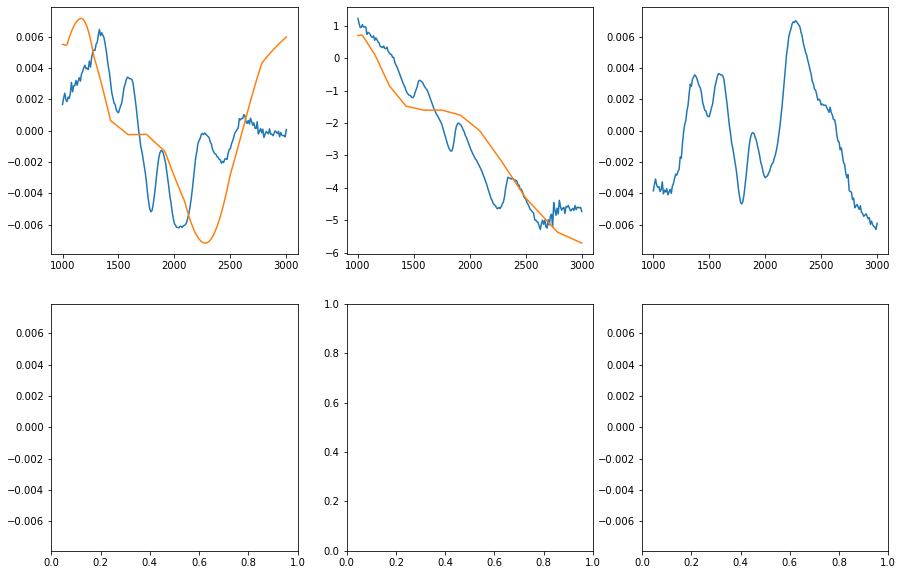

In [32]:

XMIN=1000
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2, new=True)
DATA = True

fig, ax = plt.subplots(2,3,figsize=(15,10))

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
ny -= ny.mean()
N = 100000
ax[0][0].plot(nx, ny)

from scipy.signal import hilbert
analytic_signal = hilbert(ny)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = -np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * N)
ax[0][1].plot(nx, instantaneous_phase)
#ax[0][1].plot(nx[1:], instantaneous_frequency)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
ifs = np.convolve(instantaneous_frequency, kernel, mode='same')
#ax[0][1].plot(nx[1:], ifs)

w = vr/rr
dR = np.gradient(rr)
dw2 = np.gradient(w**2)
k = np.sqrt(rr * dw2/dR + 4 * w**2)
freq = ft*(w - k/2)
#plt.plot(rr, freq)
ffreq = interpolate.interp1d(rr, freq, 'linear')
def phiR(R, t, phi0=0):
    return phi0 + 2*ffreq(R)*t

LzR = rr*vr
rfromlz = interpolate.interp1d(LzR, rr)

def phiR_mod(Lz, t, phi0):
    r = rfromlz(Lz)
    return phiR(r,t,phi0=phi0)

fun = lambda Lz, t, phi0: phiR_mod(Lz, t, phi0)
#fun = lambda Lz, t, n, phi0: an_phi_mod(Lz, t, n, phi0)
optpar = optimize.curve_fit(fun, nx, instantaneous_phase, p0=[0,0], maxfev=10000)[0]
ax[0][1].plot(nx, fun(nx, *optpar))
#ax[0][0].plot(nx, np.sin(fun(nx, *optpar)))
sign = np.max(amplitude_envelope) * np.cos(fun(nx, *optpar))
ax[0][0].plot(nx, sign)
ax[0][2].plot(nx, ny - sign)
ax[0][2].set_ylim(ax[0][0].get_ylim())
ax[1][0].set_ylim(ax[0][0].get_ylim())
ax[1][2].set_ylim(ax[0][0].get_ylim())
print(optpar)

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other



(-0.004222316762368498, 0.004219270063157736)

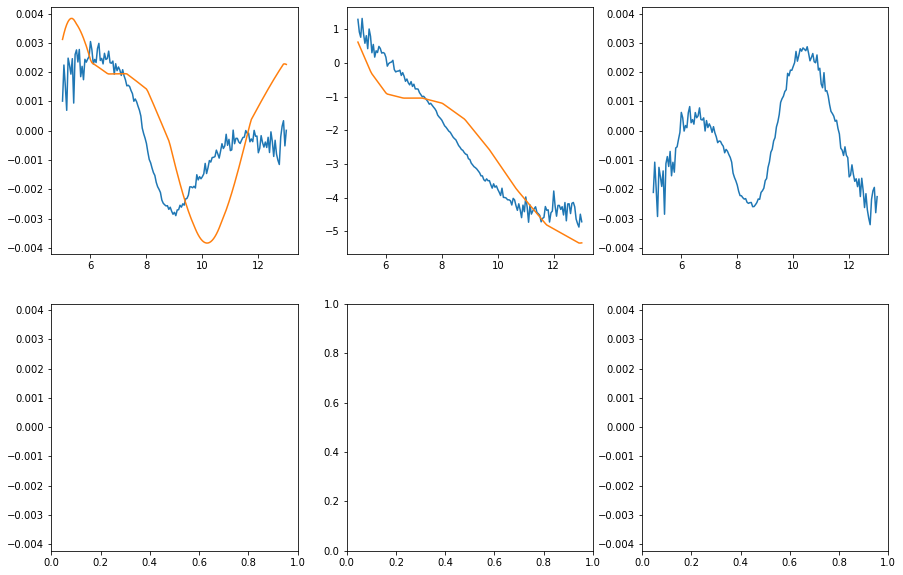

In [403]:

XMIN=1000
XMAX=3000
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2)
DATA = True

fig, ax = plt.subplots(2,3,figsize=(15,10))

nx, ny = smooth_bins(R, VR/Lz, 5, 13, 0.05)
ny -= ny.mean()
N = 100000
ax[0][0].plot(nx, ny)

from scipy.signal import hilbert
analytic_signal = hilbert(ny)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = -np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * N)
ax[0][1].plot(nx, instantaneous_phase)
#ax[0][1].plot(nx[1:], instantaneous_frequency)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
ifs = np.convolve(instantaneous_frequency, kernel, mode='same')
#ax[0][1].plot(nx[1:], ifs)

w = vr/rr
dR = np.gradient(rr)
dw2 = np.gradient(w**2)
k = np.sqrt(rr * dw2/dR + 4 * w**2)
freq = ft*(w - k/2)
#plt.plot(rr, freq)
ffreq = interpolate.interp1d(rr, freq, 'linear')
def phiR(R, t, phi0=0):
    return phi0 + 2*ffreq(R)*t

fun = lambda R, t, phi0: phiR(R, t, phi0)
#fun = lambda Lz, t, n, phi0: an_phi_mod(Lz, t, n, phi0)
optpar = optimize.curve_fit(fun, nx, instantaneous_phase, p0=[0,0], maxfev=10000)[0]
ax[0][1].plot(nx, fun(nx, *optpar))
#ax[0][0].plot(nx, np.sin(fun(nx, *optpar)))
sign = np.max(amplitude_envelope) * np.cos(fun(nx, *optpar))
ax_right.plot(nx, sign, c='C1')
ax[0][0].plot(nx, sign)
ax[0][2].plot(nx, ny - sign)
ax[0][2].set_ylim(ax[0][0].get_ylim())
ax[1][0].set_ylim(ax[0][0].get_ylim())
ax[1][2].set_ylim(ax[0][0].get_ylim())
#print(optpar)

(0.0, 200.0)

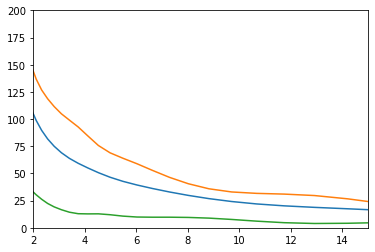

In [3]:
import csv

R = []
vrot = []
vrotmax = []
vrotmin = []
with open('vrot_sofue.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for l in reader:
        R.append(float(l[0]))
        vrot.append(float(l[1]))
        vrotmax.append(float(l[1]) + float(l[2]))
        vrotmin.append(float(l[1]) - float(l[2]))
R, vr, vrotmax, vrotmin = (np.array(i) for i in (R, vrot, vrotmax, vrotmin))
        

#plt.plot(R, vr)

w = vr/R
plt.plot(R, w)

dR = np.gradient(R)
dw2 = np.gradient(w**2)
k = np.sqrt(R * dw2/dR + 4 * w**2)
plt.plot(R, k)
plt.plot(R, w-k/2)

plt.xlim(2,15)
plt.ylim(0,200)

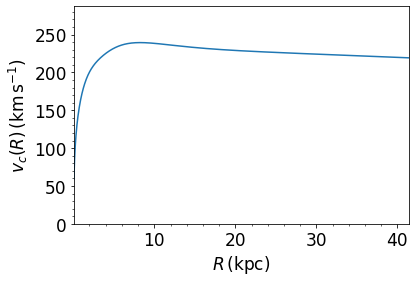

In [52]:
R0=8.277
V0=251.5-12.24

from galpy.potential.mwpotentials import MWPotential2014, McMillan17, Irrgang13I
from galpy.potential import plotRotcurve
rc = plotRotcurve(McMillan17, ro=R0, vo=V0);
R = np.array(rc[0].get_xdata())
Vc = np.array(rc[0].get_ydata())

relR = (R >= 5.5) & (R <= 12)
R = R[relR]
Vc = Vc[relR]
mcm_Lz = Vc*R

[-0.00103636]


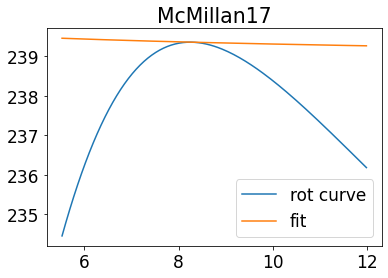

In [53]:
plt.plot(R, Vc, label='rot curve')
interpv = interpolate.interp1d(R,Vc)

def trc(r, n, ro, vo):
    return vo * (r/ro)**n
fitf = lambda R, n: trc(R, n, ro=R0, vo=interpv(R0))

optn = optimize.curve_fit(fitf, R, Vc)[0]
plt.plot(R, trc(R,optn,R0,interpv(R0)), label='fit')
plt.title('McMillan17')
plt.legend()
print(optn)

namef='plots/mcmillan_nfit'+'.png'
plt.savefig(namef, bbox_inches='tight')

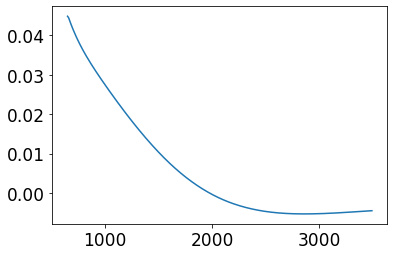

In [38]:
#plt.plot(Lz_Vc, Vc)
mcm_n = np.gradient(Vc)/np.gradient(mcm_Lz)
plt.plot(mcm_Lz, mcm_n)

/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

0.0008
1512.8593040846831


<ErrorbarContainer object of 3 artists>

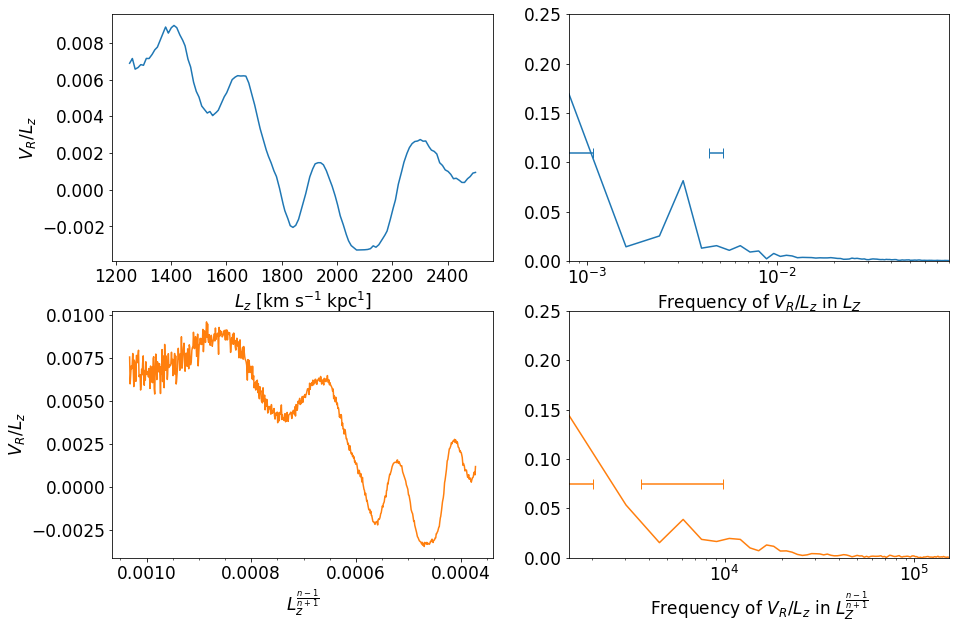

In [36]:
# Plot the untransformed and transformed (with Lz**((n+1)/(n-1))) Gaia data and the corresponding Fourier transforms

plt.rcParams['font.size'] = 17

XMIN=1250
XMAX=2500
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2, new=True)
DATA = True

fig, ax = plt.subplots(2,2,figsize=(15,10))

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
cplt = ax[0][0]
cplt.plot(xpol, ypol, c='C0')
cplt.set_aspect('auto')
cplt.set_xlabel(r'$L_z$ [km s$^{-1}$ kpc$^{1}$]')
cplt.set_ylabel(r'$V_R/L_z$')
#cplt.xaxis.label.set_color('C0')
#cplt.spines['bottom'].set_color('C0')
#cplt.tick_params(axis='x', colors='C0')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
print(1/xfr[np.argmax(np.abs(yf))])
cplt = ax[0][1]
cplt.plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C0')
cplt.set_xlim(1/max(xfr), 1/xfr[100])
cplt.set_xscale('log')
cplt.set_aspect('auto')
cplt.set_xlabel('Frequency of $V_R/L_z$ in $L_Z$')
cplt.set_ylim(0,0.25)
#cplt.spines['top'].set_color('C1')
#cplt.tick_params(axis='x', colors='C0')
#cplt.xaxis.label.set_color('C0')

avgs = (xfr[1:] + xfr[:-1])/2
cplt.errorbar(x=0, y=0.11, xerr=[[0], [1/avgs[0]]], color='C0', capsize=5)
cplt.errorbar(x=1/xfr[5], y=0.11, xerr=[[abs(1/xfr[5]-1/avgs[4])], [abs(1/xfr[5]-1/avgs[5])]], color='C0', capsize=5)

#freqs = 1/xfr
#print(freqs[:10])
#val = np.abs(yf)/np.sum(np.abs(yf)) 
#print(val[:10])

interpn = interpolate.interp1d(mcm_Lz, mcm_n)
n = interpn(Lz)
Lzl = Lz**((n-1)/(n+1))
nx, ny = smooth_bins(Lzl, VR/Lz, np.min(Lzl), np.max(Lzl), 1e-6)
N = 100000
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
axb = ax[1][0]
axb.plot(xpol, ypol, c='C1')
axb.set_xlabel(r'$L_z^\frac{n-1}{n+1}$')
axb.set_ylabel(r'$V_R/L_z$')
#axb.spines['top'].set_color('C1')
#axb.tick_params(axis='x', colors='C1')
#axb.xaxis.label.set_color('C1')
axb.set_xlim(axb.get_xlim()[::-1])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
axb.xaxis.set_minor_locator(AutoMinorLocator())
axb.locator_params(axis='x', nbins=4)


ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
axb = ax[1][1]
axb.plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C1')
print(1/xfr[np.argmax(np.abs(yf))])
axb.set_xlim(1/max(xfr), 1/xfr[100])
axb.set_ylim(0,0.25)
axb.set_xscale('log')
axb.set_aspect('auto')
axb.set_xlabel(r'Frequency of $V_R/L_z$ in $L_Z^{\frac{n-1}{n+1}}$')
#axb.spines['top'].set_color('C1')
#axb.tick_params(axis='x', colors='C1')
#axb.xaxis.label.set_color('C1')

avgs = (xfr[1:] + xfr[:-1])/2
axb.errorbar(x=0, y=0.075, xerr=[[0], [1/avgs[0]]], color='C1', capsize=5)
axb.errorbar(x=1/avgs[3], y=0.075, xerr=[[abs(1/avgs[3]-1/avgs[1])], [abs(1/avgs[3]-1/avgs[5])]], color='C1', capsize=5)


/home/hpc/anaconda3/lib/python3.9/site-packages/astropy/table/table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other

0.0007142857142857143


ValueError: x and y arrays must be equal in length along interpolation axis.

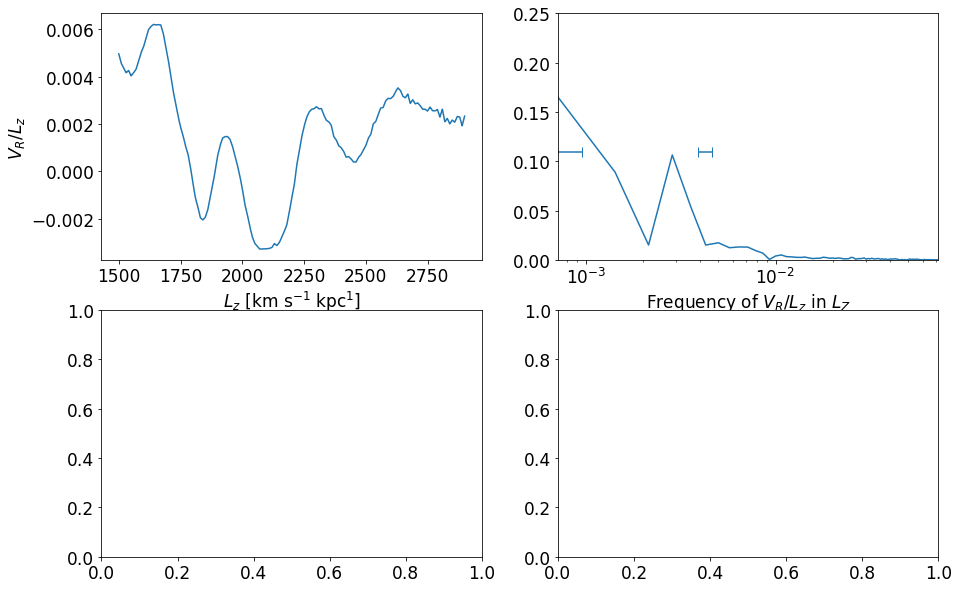

In [57]:
# Plot the untransformed and transformed (with Lz**((n+1)/(n-1))) Gaia data and the corresponding Fourier transforms

plt.rcParams['font.size'] = 17

XMIN=1500
XMAX=2900
BINSIZE = 10
x,y,VR,Vphi,R,Lz,phi=l.load_data(xmin=XMIN, xmax=XMAX, phi_range=0.2, new=True)
DATA = True

fig, ax = plt.subplots(2,2,figsize=(15,10))

nx, ny = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE)
N = 100000

nx, ny = smooth_bins(Lz, VR/Lz, XMIN, XMAX, BINSIZE)
N = 100000
P = 1
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
cplt = ax[0][0]
cplt.plot(xpol, ypol, c='C0')
cplt.set_aspect('auto')
cplt.set_xlabel(r'$L_z$ [km s$^{-1}$ kpc$^{1}$]')
cplt.set_ylabel(r'$V_R/L_z$')
#cplt.xaxis.label.set_color('C0')
#cplt.spines['bottom'].set_color('C0')
#cplt.tick_params(axis='x', colors='C0')

ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
print(1/xfr[np.argmax(np.abs(yf))])
cplt = ax[0][1]
cplt.plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C0')
cplt.set_xlim(1/max(xfr), 1/xfr[100])
cplt.set_xscale('log')
cplt.set_aspect('auto')
cplt.set_xlabel('Frequency of $V_R/L_z$ in $L_Z$')
cplt.set_ylim(0,0.25)
#cplt.spines['top'].set_color('C1')
#cplt.tick_params(axis='x', colors='C0')
#cplt.xaxis.label.set_color('C0')

avgs = (xfr[1:] + xfr[:-1])/2
cplt.errorbar(x=0, y=0.11, xerr=[[0], [1/avgs[0]]], color='C0', capsize=5)
cplt.errorbar(x=1/xfr[5], y=0.11, xerr=[[abs(1/xfr[5]-1/avgs[4])], [abs(1/xfr[5]-1/avgs[5])]], color='C0', capsize=5)

#freqs = 1/xfr
#print(freqs[:10])
#val = np.abs(yf)/np.sum(np.abs(yf)) 
#print(val[:10])

interpn = interpolate.interp1d(mcm_Lz, mcm_n)
n = interpn(Lz)
Lzl = Lz**((n-1)/(n+1))
nx, ny = smooth_bins(Lzl, VR/Lz, np.min(Lzl), np.max(Lzl), 1e-6)
N = 100000
f = interpolate.interp1d(nx, ny, kind='linear')
xpol = np.linspace(nx[0], nx[-1], N)
ypol = f(xpol)
xpol = xpol[~np.isnan(ypol)]
ypol = ypol[~np.isnan(ypol)]
N = len(ypol)
axb = ax[1][0]
axb.plot(xpol, ypol, c='C1')
axb.set_xlabel(r'$L_z^\frac{n-1}{n+1}$')
axb.set_ylabel(r'$V_R/L_z$')
#axb.spines['top'].set_color('C1')
#axb.tick_params(axis='x', colors='C1')
#axb.xaxis.label.set_color('C1')
axb.set_xlim(axb.get_xlim()[::-1])
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
axb.xaxis.set_minor_locator(AutoMinorLocator())
axb.locator_params(axis='x', nbins=4)


ypol = (ypol - ypol.mean()) / (ypol.max() - ypol.min())
yf = fft(ypol)
xf = fftfreq(N)
yf = yf[xf>0]
xf = xf[xf>0]

xfr = ((nx[-1]-nx[0]) / abs(xf * N))
axb = ax[1][1]
axb.plot(1/xfr, np.abs(yf)/np.sum(np.abs(yf)), color='C1')
print(1/xfr[np.argmax(np.abs(yf))])
axb.set_xlim(1/max(xfr), 1/xfr[100])
axb.set_ylim(0,0.25)
axb.set_xscale('log')
axb.set_aspect('auto')
axb.set_xlabel(r'Frequency of $V_R/L_z$ in $L_Z^{\frac{n-1}{n+1}}$')
#axb.spines['top'].set_color('C1')
#axb.tick_params(axis='x', colors='C1')
#axb.xaxis.label.set_color('C1')

avgs = (xfr[1:] + xfr[:-1])/2
axb.errorbar(x=0, y=0.075, xerr=[[0], [1/avgs[0]]], color='C1', capsize=5)
axb.errorbar(x=1/avgs[3], y=0.075, xerr=[[abs(1/avgs[3]-1/avgs[1])], [abs(1/avgs[3]-1/avgs[5])]], color='C1', capsize=5)
